In [3]:
import numpy as np
import scipy as sp
# from pydmd import DMD
# from pydmd.plotter import plot_summary
# from pydmd.preprocessing import hankel_preprocessing

import matplotlib.pyplot as plt
import tristanVis.isolde as isolde
from tqdm import tqdm

%matplotlib inline

out_dir = "../slurm_scripts/output/"
# out_dir = "../vault/output_psi0.5_mul1_3_mul2_0.1_TT_1.9e-2_rad_drag_temp/"
# out_dir = "/scratch/10446/anindya_12/tristan_mp_v2/vault/output_psi0.5_mul1_3_mul2_0.1_TT_1.9e-4_rad_drag/"
out_dir_prtl = "/scratch/10446/anindya_12/tristan_mp_v2/vault/output_psi0.5_mul1_3_mul2_0.1_TT_1.9e-4_rad_drag_prtl_maxxed/"
# out_dir = "../vault/output_psi0.5_mul1_3_mul2_0.1_TT_1.9e-2_long/"
# out_dir = "../vault/output_psi0.5_mul1_4_mul2_4_TT_1.9e-3_long/"
run_no = "18"
"""
Typical stuff read from the input file
"""
# "../slurm_scripts/" + "temp_input_psi0.5_mul10.in"
# input_file_name = out_dir + "temp_input_psi0.5_mul13_mul20.1_TT1.9e-4.in" #"temp_input_psi0.5_mul13_mul20.5.in"  #"../inputs/inputAG.2d_EM_wave_emb_2"
input_file_name_prtl = out_dir_prtl + "temp_input_psi0.5_mul13_mul20.1_TT1.9e-4.in" #"temp_input_psi0.5_mul13_mul20.5.in"  #"../inputs/inputAG.2d_EM_wave_emb_2"

# input_file_name = "/scratch/10446/anindya_12/tristan_mp_v2/slurm_scripts/temp_input_psi0.5_mul13_mul20.1_TT1.9e-2.in"

input_file_name = "../slurm_scripts/" + "temp_input_psi0.5_mul13_mul20.1_TT1.9e-2.in" #+ "temp_input_psi0.5_mul13_mul20.1.in"
# input_file_name = "../slurm_scripts/inputAG.2dtwostream_thermal_Bfield_0"
# hist            = isolde.parseHistory(out_dir + "history")
input_params    = isolde.parseInput(input_file_name)
m1              = input_params["particles"]["m1"]
m2              = input_params["particles"]["m2"]
interval_flds   = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
grid_x          = int(input_params["grid"]["mx0"])
grid_y          = int(input_params["grid"]["my0"])
Nsteps          = int(lst_time// interval_flds)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
ppc0            = input_params["plasma"]["ppc0"]
SIGMA           = input_params["plasma"]["sigma"]
stride          = input_params["output"]["stride"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
unit_ch         = CC**2 / (ppc0 * COMP**2)
weight_fac      = 2.0473518E-03 #1.9316248E-03 #4.2996384E-02 #1.9316248E-03 #2.2946008E-02
wA_wp           = input_params["problem"]["wA_wp"]
# omegap0         = CC / COMP #* np.sqrt(weight_fac)
# time            = hist["time"] * omegap0
B_0             = input_params["problem"]["B_0"]#["B_0""B_field"]
B_amp           = input_params["problem"]["B_amplitude"]
# duration        = input_params["problem"]["duration"]
# freq            = input_params["problem"]["frequency"]
spread          = input_params["problem"]["spread"]
mode            = input_params["problem"]["mode"]
psi             = input_params["problem"]["psi"]
mult1           = input_params["problem"]["multiplicity_1"]
mult2           = input_params["problem"]["multiplicity_2"]
TT              = input_params["problem"]["temperature"]
ramp_width      = input_params["problem"]["ramp_width"]
init_x_boundary = int(5 * np.pi / mode) + 1
fin_x_boundary  = init_x_boundary + ramp_width * (2 * np.pi / mode)

ds              = wA_wp * 2 * np.pi / mode
omegap0         = CC / ds

input_params_prtl    = isolde.parseInput(input_file_name_prtl)
interval_prtl        = input_params_prtl["output"]["interval"]
stride_prtl          = input_params_prtl["output"]["stride"]

Nsteps_prtl          = int(lst_time// interval_prtl)

#  Weight factor:   1.696659 (upcoming)

"""
A WORD FROM ANINDYA (2/6/2024) ABOUT UNITS !!
#############################################

In my experience with Tristan code units, its most convenient to use dimensionless units of time and space.
Set code time steps and space steps to 1 (like, mentally : you don't have to do anything).
dt = 1
dx = 1

Then omegap0 is the plasma frequency in this units = CC / COMP dt^-1 = CC/COMP
And Debye length / skin-depth, d_e = COMP dx = COMP.

If (x,t) is (space,time) in code units then use the dimensionless (x/d_e, omegap0 * t) for all physics expressions/ theory.

BTW, in these units defined as such speed of light is c = CC dx/dt = CC.
"""

def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + r"$\times 10^{}$".format('{' + str(b) + '}')

# print(sci_notation(10000, sig_fig=4))


def fetch_var_at_step(out_dir, var, step, rad = False):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        
        return(isolde.getParticles(filename))
    elif var == "flds":
        
        return(isolde.getFields(filename))
    
    elif var == "spec":        
        return(isolde.getSpectra(filename, radiation = rad))
    
    else:
        print("Not supported yet!")
        return False

"""
TEMPLATES to fetch density, electric field and particle positions / velocities
##############################################################################

# density = np.zeros(shape = (2, Nsteps,grid_x))
# for step in range(Nsteps):
#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]

# Ex = np.zeros(shape = (Nsteps,grid_x))
# for step in range(Nsteps):
#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]

"""
# density1 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# density2 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ex = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ey = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bz = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jy = np.zeros(shape = (Nsteps, grid_y, grid_x))

# X1 = []
# ux_1 = []
# Y1 = []
# uy_1 = []
# X2 = []
# ux_2 = []
# Y2 = []
# uy_2 = []


# for step in tqdm(range(Nsteps)):
#     # density1[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)
#     # density2[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,:], axis = 0)
    # X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
    # ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
    # Y1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['y'])
    # uy_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['v'])

    # X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
    # ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
    # Y2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['y'])
    # uy_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['v'])
    
    # Jx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jx"][:,:,:], axis = 0)
    # Ex[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ex"][:,:,:], axis = 0)
    # Jy[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jy"][:,:,:], axis = 0)
    # Ey[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ey"][:,:,:], axis = 0)
    #Ey[step,:,:]       = fetch_var_at_step(out_dir, "flds", step)["ey"][0,:,:]
    #Bx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bx"][:,:,:], axis = 0)
    # Bz[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bz"][:,:,:], axis = 0)
# X1=np.array(X1)
# ux_1 = np.array(ux_1)
# Y1=np.array(Y1)
# uy_2 = np.array(uy_2)

# data = isolde.parseUsrOutput(out_dir +'usroutput')[400]['eparr_av']

# plt.plot(data[np.abs(data) <= 1e1 ])
print(grid_x, grid_y, lst_time, ds)
# print(COMP/np.sqrt(weight_fac))

print(init_x_boundary, fin_x_boundary)
print(interval_flds, interval_prtl)
print(mode)

5000 100 67500.0 15.707963267948967
3927 13351.77796076938
100.0 2.0
0.004


In [2]:
plt.plot(hist["time"] * omegap0, hist['Ex^2'] + hist['Ey^2'] + hist['Ez^2'] + hist['Bx^2'] + hist['By^2'] + hist['Bz^2'] - 50,
        label = "Field energy - 50")
plt.plot(hist["time"] * omegap0, hist["Esp1"] + hist["Esp2"], label = "Particle energy")
plt.plot(hist["time"] * omegap0, hist["Etot"]-50, label = "Total energy - 50")
plt.legend()
plt.xlabel(r"$t\omega_{\rm p0}$") 
plt.ylabel(r"$E$")
plt.grid()

NameError: name 'hist' is not defined

In [4]:
def bg_density_scaled(x):
    n_0_local = mult1
    if mult1 != mult2:        
        k = np.log((mult1-mult2) / (0.01 * mult2))/ (fin_x_boundary - init_x_boundary)
        if x < init_x_boundary:
            n_0_local = mult1
        else:
            n_0_local = mult1 + (mult2 - mult1) * (1.0 - (1.0 + k*(x - init_x_boundary)) * np.exp(-k*(x - init_x_boundary)))
        # n_0_local = mult1 * np.exp(- k * (x - init_x_boundary))
    # if (x <= init_x_boundary):
    #     n_0_local = mult1
    
    # elif (x > fin_x_boundary):
    #     n_0_local = mult2

    # else :
    #     t = (x - init_x_boundary)/(fin_x_boundary - init_x_boundary)        
    #     n_0_local = mult1 + (mult2 - mult1) * (3.0*t**2 - 2.0*t**3)
    return n_0_local

from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

scale_x = lambda x: CC / omegap0 * np.sqrt(bg_density_scaled(0)/bg_density_scaled(x))
scale_x_inv = lambda x: 1/scale_x(x)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.0f}'.format(sp.integrate.quad(scale_x_inv, 0, x)[0]))

def make_y_ticks_formatter(x_fixed):
    scale_at_x = scale_x(x_fixed)
    scale_inv_y = lambda y: 1.0 / scale_at_x
    return ticker.FuncFormatter(lambda y, pos: '{0:.0f}'.format(sp.integrate.quad(scale_inv_y, 0, y)[0]))


In [10]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster
"""
%matplotlib inline


# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 12))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 4))
# fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

# ax1.set_title(r"charge density $=|e^-| (n_{e^+}-n_{e^-})$")
# ax1.set_title(r"Density fluctuations $\delta n_e/ n_{e,0}$",fontsize=16)
# ax1.set_title(r"$j_{||}/B_0 (x,y) $ ")


div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')



def arr_func(frame):
    d1 = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = 0)#/B_norm
    d2 = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = 0)#/B_norm
    # Ex = np.average(fetch_var_at_step(out_dir, "flds", frame)["ex"][:,:,:], axis = 0)*B_norm
    # Ey = np.average(fetch_var_at_step(out_dir, "flds", frame)["ey"][:,:,:], axis = 0)*B_norm
    # E_parr = (Ex * np.cos(psi) + Ey * np.sin(psi))
    # d1_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = 0)#/B_norm
    # d2_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens2"][:,:,:], axis = 0)#/B_norm
    # bz  = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[:, :]
    # del_x_bz     = np.gradient(bz, axis = 1) 
    # del_y_bz     = np.gradient(bz, axis = 0) 

    # curl_b_parr  = del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi)

    # j_req = curl_b_parr * CC / (ppc0 * weight_fac * unit_ch)
    
    # j_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = 0)[:, :]
    # j_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = 0)[:, :]
    
    # j_parr = (j_x * np.cos(psi) + j_y * np.sin(psi)) / (ppc0 * weight_fac * unit_ch)
    # e_fiducial = CC**2/(ppc0 * COMP**2)
    # # d_fluc = (d1 + d2 - d1_0 -  d2_0)/(d1_0 + d2_0)
    rho_d = d1 - d2
    # return  j_parr - j_req #jx * np.cos(psi) + jy * np.sin(psi)#Ex * np.cos(psi) + Ey * np.sin(psi) 
    return  rho_d /(ppc0 * weight_fac)
    # return E_parr

im = ax1.imshow(arr_func(30)[:,:], origin='lower', aspect = 'auto',cmap='viridis') 
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=13)
tx = ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
ax1.set_ylabel(r"$y \omega_{p}/ c$", fontsize = 14)
# ax1.xaxis.set_major_formatter(ticks_x)
# ax1.yaxis.set_major_formatter(ticks_x)



# ax1.set_title(r"$(j_{||} - j_A)/j_0$")
ax1.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax1.tick_params(axis='both', which='major', labelsize=13)
# ax1.set_ylim(0, 1000)
# ax1.set_xlim(500, 10000)

# bz_max = np.max(Bz)/B_norm
# bz_min = np.min(Bz)/B_norm



# Function to update the frame
def animate_scalar(frame, ax1, ax2, im, tx):
    x_lim_low  = 10214 #frame * CC * interval * np.cos(psi) + 1000
    x_lim_high = 12214 #frame * CC * interval * np.cos(psi) + 3000    
    x_fixed = 0.5 * (x_lim_low + x_lim_high)
    ticks_y = make_y_ticks_formatter(x_fixed)
    ax1.set_xlim(x_lim_low, x_lim_high)
    ax1.yaxis.set_major_formatter(ticks_y)
    ax1.xaxis.set_major_formatter(ticks_x)
    
    if im is not None:
        arr = arr_func(frame)[:, int(x_lim_low):int(x_lim_high)]
        vmax     = np.max(arr)
        vmin     = np.min(arr)
        im.set_data(arr)
        im.set_clim(np.min(arr), np.max(arr))
    
    # tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))
    tx.set_text(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval_flds * omegap0))
    
    ax2.clear()
#     bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = (0,1))[:]
#     ax2.plot(xx, bz/(B_norm * B_0))     
    n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac)
    n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac)
    ax2.set_ylabel(r"$n(x)/n_0$", fontsize = 14)
    ax2.plot(xx, n_p, color = 'red', linewidth = 0.7, label = r'$e^{+}$')
    ax2.plot(xx, n_e, color = 'blue', linewidth = 0.7, label = r'$e^{-}$')
    # ax2.set_xlabel(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))
    ax2.set_xlabel(r"x-axis, $t$ = " + "{:.2f}".format(frame * interval_flds))
#     ax2.set_ylabel(r"$B_z(x)$")
#     ax2.set_ylim(-1.2*B_amp, 1.2*B_amp)  
    ax2.set_ylim(0, 2)  
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    ax1.annotate(r"$B_0$",
            xytext=(100 + x_lim_low, 0), xycoords='data',  # Head of the arrow
            xy=(100 + x_lim_low + int(np.cos(psi) * 1000), 0 + int(np.sin(psi) * 1000)), textcoords='data',  # Tail of the arrow
            arrowprops=dict(arrowstyle="->", lw=4),  # Arrow style and properties
            fontsize = 15
            )

    # print(psi, np.sin(psi))

    return ax2.get_children()


# # Create the animation
# ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(2300, 3000)), blit=False)

# # Save the animation
# # writer = FFMpegWriter(fps=20, bitrate=2400)
# # ani.save("./ch_dens(x,y)_PARAMS_B_amp_plasma= {:.2f}, mode = {:.3f}, angle = {:.2f}.mp4".format(B_amp, mode, psi), 
# #          writer=writer, dpi=800)
# writer = PillowWriter(fps=20, bitrate=2400)  # You can increase FPS if needed
# ani.save("./ch_dens(x,y)_PARAMS_B_amp_plasma= {:.2f}, mode = {:.3f}, angle = {:.2f}.gif".format(B_amp, mode, psi),
#          writer=writer, dpi=800)  # Lower dpi to reduce file size
# animate_scalar(2500, ax1, ax2, im, tx)

# plt.show()


<IPython.core.display.Javascript object>


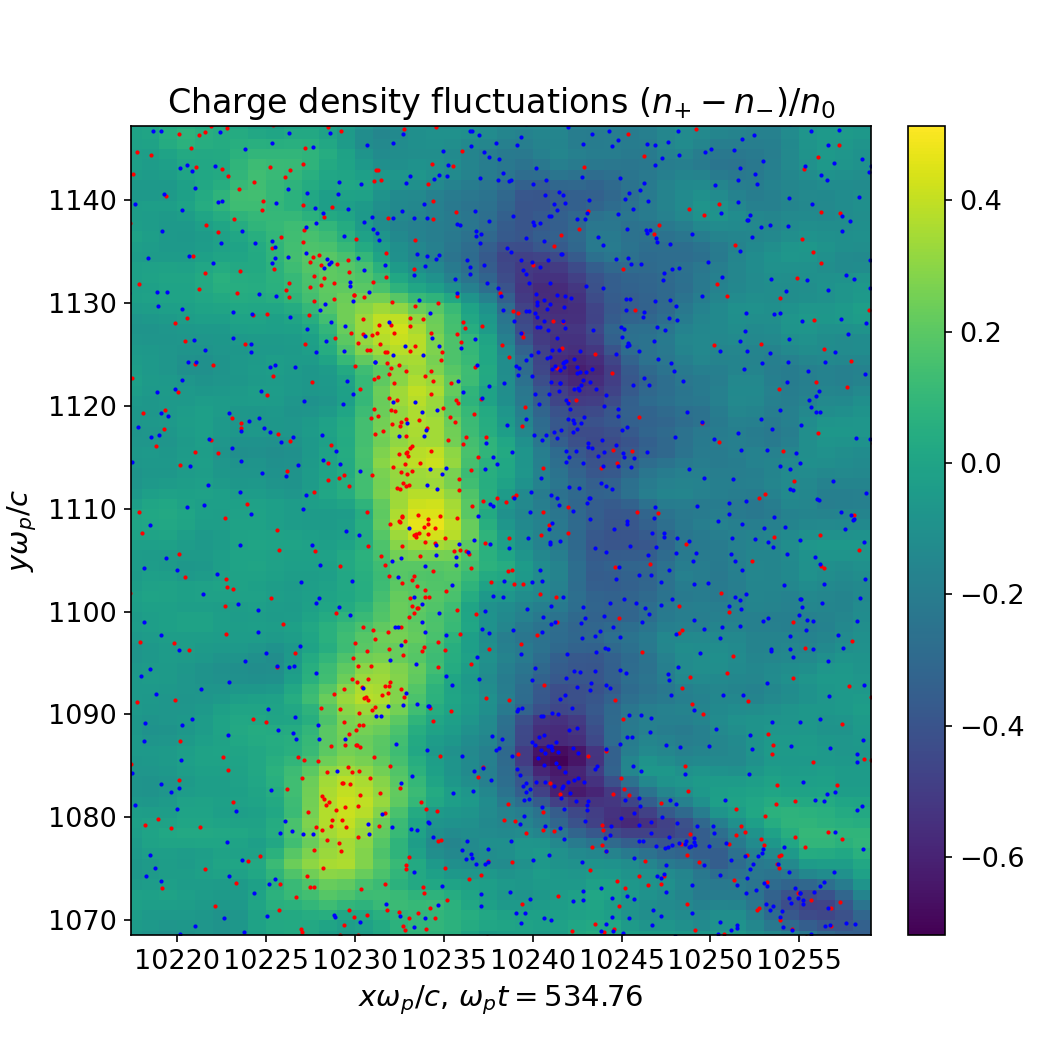

'./temp_frames/frame_02400.png'

In [4]:
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend for multiprocessing-safe rendering
%matplotlib notebook
from PIL import Image
from multiprocessing import Pool
import os

# ------------------ Movie Generation Params ------------------ #

frame_range = range(2300, 2650)
frame_dir = "./temp_frames"
gif_path = "./ch_dens(x,y)_phase_PARAMS_B_amp_plasma= {:.2f}, mode = {:.3f}, angle = {:.2f}.gif".format(B_amp, mode, psi)

os.makedirs(frame_dir, exist_ok=True)

# ------------------ Frame Rendering Wrapper ------------------ #

def render_frame(frame):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
#     fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Get data and set up limits FIRST
    x_lim_low  = 10214
    x_lim_high = 11214
    x_fixed = 0.5 * (x_lim_low + x_lim_high)
    
    # Get the full array and crop it
    arr = arr_func(frame)
    arr_cropped = arr[:, int(x_lim_low):int(x_lim_high)]
    
    # Set up the image with proper extent to match the coordinate system
    extent = [x_lim_low, x_lim_high, 0, arr.shape[0]]  # [left, right, bottom, top]
    im = ax1.imshow(arr_cropped, origin='lower', aspect='auto', extent=extent, cmap='plasma')
    
    
    # Set up colorbar
    div = make_axes_locatable(ax1)
    cax = div.append_axes('right', '5%', '5%')
    cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=13)
    
    # Set up axes properties
    ax1.set_xlim(x_lim_low, x_lim_high)
    ax1.set_ylim(0, 500)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(150))
    ax1.tick_params(axis='both', which='major', labelsize=13)
    
    # Set up formatters (you'll need these from your original code)
    ticks_y = make_y_ticks_formatter(x_fixed)
    ax1.yaxis.set_major_formatter(ticks_y)
    ax1.xaxis.set_major_formatter(ticks_x)
    
    # Set labels and title
    tx = ax1.set_xlabel(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval_flds * omegap0), fontsize=14)
    ax1.set_ylabel(r"$y \omega_{p}/ c$", fontsize=14)
    
    # Add the magnetic field arrow
    ax1.annotate(r"$B_0$",
                xytext=(50 + x_lim_low, 50), xycoords='data',
                xy=(50 + x_lim_low + int(np.cos(psi) * 500), 50 + int(np.sin(psi) * 500)), 
                textcoords='data',
                arrowprops=dict(arrowstyle="->", lw=4),
                fontsize=15)
    
#     # Set up bottom panel (ax2)
    n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis=(0,1))[:]/(ppc0 * weight_fac)
    n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis=(0,1))[:]/(ppc0 * weight_fac)
    
    ax2.plot(xx, n_p, color='red', linewidth=0.7, label=r'$e^{+}$')
    ax2.plot(xx, n_e, color='blue', linewidth=0.7, label=r'$e^{-}$')
    ax2.set_ylabel(r"$n(x)/n_0$", fontsize=14)
    ax2.set_xlabel(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval_flds * omegap0), fontsize=14)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax2.legend()
    
    # Save the figure
    path = os.path.join(frame_dir, f"frame_{frame:05d}.png")
    fig.savefig(path, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return path


def render_frame2(frame):
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    fig, ax1 = plt.subplots(figsize=(7, 7))
    
    # Get data and set up limits FIRST
    x_lim_low  = 10200 #10214
    x_lim_high = 10300 #11214
    x_fixed = 0.5 * (x_lim_low + x_lim_high)
    
    # Get the full array and crop it
    arr = arr_func(frame)
    arr_cropped = arr[:, int(x_lim_low):int(x_lim_high)]
    
    # Set up the image with proper extent to match the coordinate system
    extent = [x_lim_low, x_lim_high, 0, arr.shape[0]]  # [left, right, bottom, top]
    im = ax1.imshow(arr_cropped, origin='lower', aspect='auto', extent=extent, cmap='viridis')
    
    
    # Set up colorbar
    div = make_axes_locatable(ax1)
    cax = div.append_axes('right', '5%', '5%')
    cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=13)
    
    # Set up axes properties
    ax1.set_xlim(x_lim_low, x_lim_high)
    ax1.set_ylim(1000, 1100)
#     ax1.yaxis.set_major_locator(ticker.MultipleLocator(150))
    ax1.tick_params(axis='both', which='major', labelsize=13)
    
# #     Set up formatters (you'll need these from your original code)
#     ticks_y = make_y_ticks_formatter(x_fixed)
#     ax1.yaxis.set_major_formatter(ticks_y)
#     ax1.xaxis.set_major_formatter(ticks_x)
    
    # Set labels and title
    tx = ax1.set_xlabel(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval_flds * omegap0), fontsize=14)
    ax1.set_ylabel(r"$y \omega_{p}/ c$", fontsize=14)
    
    ax1.set_title(r"Charge density fluctuations $(n_{+} - n_{-}) / n_0$", fontsize = 16)
    
    # Add the magnetic field arrow
    ax1.annotate(r"$B_0$",
                xytext=(600 + x_lim_low, 200), xycoords='data',
                xy=(600 + x_lim_low + int(np.cos(psi) * 400), 200 + int(np.sin(psi) * 400)), 
                textcoords='data',
                arrowprops=dict(arrowstyle="->", lw=2),
                fontsize=15)
    
    x1 = fetch_var_at_step(out_dir_prtl, "prtl", frame*5)["1"]['x']
    x2 = fetch_var_at_step(out_dir_prtl, "prtl", frame*5)["2"]['x']
    y1 = fetch_var_at_step(out_dir_prtl, "prtl", frame*5)["1"]['y']
    y2 = fetch_var_at_step(out_dir_prtl, "prtl", frame*5)["2"]['y']
    
    sstride = 1
    ax1.scatter(x1[: : sstride], y1[: : sstride], s = 1, color = "red", label=r"$e^{+}$")
    ax1.scatter(x2[: : sstride], y2[: : sstride], s = 1, color = "blue", label=r"$e^{-}$")    
    
#     x_points_scat = np.array([10226.325,  10248.324,  10240.106,  10222.374,  10228.311,  10226.303,
#  10228.808,  10230.199,  10225.0205, 10225.309 ])
#     y_points_scat = np.array([1041.9053, 1047.6799, 1059.8616, 1050.6611, 1048.8605, 1063.3688, 1061.7341,
#  1060.99,   1057.9078, 1054.3301])
#     ax1.scatter(x_points_scat, y_points_scat)
    
#     # Set up bottom panel (ax2)
#     x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
#     ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
#     uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']
#     x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
#     ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
#     uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']       
#     sstride = 1
#     ax2.scatter(x1[: : sstride], ux_1[: : sstride] * np.cos(psi) + uy_1[: : sstride] * np.sin(psi), s = 0.1, color = "red", label=r"$e^{+}$")
#     ax2.scatter(x2[: : sstride], ux_2[: : sstride] * np.cos(psi) + uy_2[: : sstride] * np.sin(psi), s = 0.1, color = "blue", label=r"$e^{-}$")    
#     ax2.set_xlim(x_lim_low, x_lim_high)  
#     ax2.set_ylim(-4, 10)
#     ax2.xaxis.set_major_formatter(ticks_x)    
#     ax2.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
#     ax2.set_xlabel(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval * omegap0), fontsize=14)
# #     ax2.text(0.85, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax1.transAxes)
#     ax2.grid()
#     ax2.legend(loc="upper right", fontsize = 13, markerscale=30)
#     ax2.tick_params(axis='both', which='major', labelsize=13)
    
    # Save the figure
    path = os.path.join(frame_dir, f"frame_{frame:05d}.png")
    fig.savefig(path, dpi=100, bbox_inches='tight')
    plt.show()
#     plt.close(fig)
    return path




# ------------------ Parallel Frame Generation ------------------ #

def generate_movie_from_frames():
    with Pool(processes=10) as pool:
        frame_paths = list(tqdm(pool.imap(render_frame2, frame_range), total=len(frame_range)))

    # Create GIF using PIL
    images = [Image.open(fp) for fp in sorted(frame_paths)]
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=1000 // 20,  # 20 fps
        loop=0
    )
    print(f"\n Saved animation to: {gif_path}")

    # Optional: clean up temp frames
    # import shutil; shutil.rmtree(frame_dir)

# ------------------ Run it ------------------ #

# generate_movie_from_frames()
render_frame2(2400)



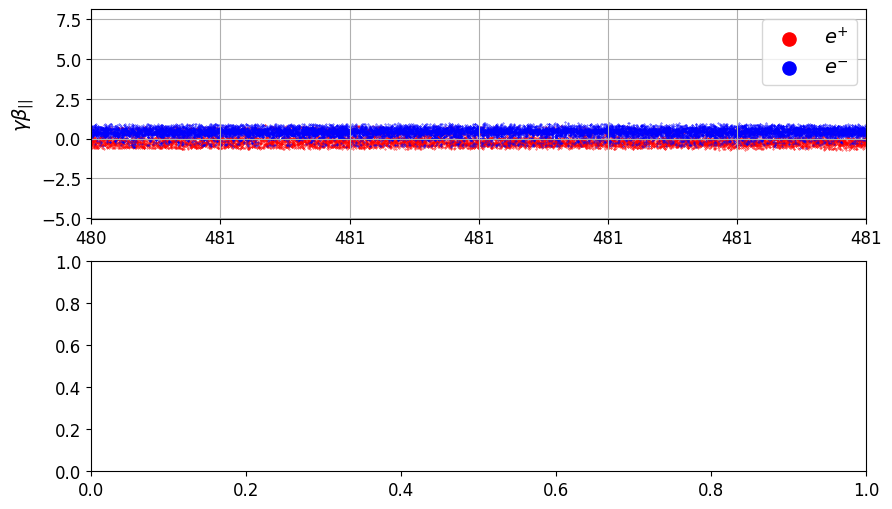

In [16]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from graphet import Data
from graphet.plugins import TristanV2
%matplotlib inline

# Vectorized approach
def calculate_acceleration_fast(frame, species):
    d = Data(
    TristanV2,
    steps=range(frame-1, frame+2),  # Load the frames you need: frame-1, frame, frame+1
    path=out_dir_prtl,
    
    cfg_fname=input_file_name, # configuration file
    params=True,            # read configuration file
    # Add other parameters as needed
    )
    # Get particle data for all three frames
    particles_prev = d.particles[species].sel(t=frame-1)
    particles_curr = d.particles[species].sel(t=frame)
    particles_next = d.particles[species].sel(t=frame+1)
    
    # Get IDs from all frames
    prev_ids = set(particles_prev.idx.values)
    current_ids = set(particles_curr.idx.values)
    next_ids = set(particles_next.idx.values)
    
    # Find common IDs across all frames
    common_ids = list(prev_ids.intersection(current_ids).intersection(next_ids))
    
    # Convert to numpy arrays for faster operations
    common_ids_array = np.array(common_ids)
    
    # Create dictionaries mapping ID to index for fast lookup
    prev_id_to_idx = {id_val: i for i, id_val in enumerate(particles_prev.idx.values)}
    next_id_to_idx = {id_val: i for i, id_val in enumerate(particles_next.idx.values)}
    curr_id_to_idx = {id_val: i for i, id_val in enumerate(particles_curr.idx.values)}
    
    # Get indices in each frame's arrays for the common particles
    prev_indices = np.array([prev_id_to_idx[idx] for idx in common_ids])
    next_indices = np.array([next_id_to_idx[idx] for idx in common_ids])
    curr_indices = np.array([curr_id_to_idx[idx] for idx in common_ids])
    
    # Extract data using vectorized operations
    u_prev = particles_prev.u.values[prev_indices]
    v_prev = particles_prev.v.values[prev_indices]
    
    u_next = particles_next.u.values[next_indices]
    v_next = particles_next.v.values[next_indices]
    
    u_now = particles_curr.u.values[curr_indices]
    v_now = particles_curr.v.values[curr_indices]
    
    # Calculate parallel velocities (vectorized)
    v_parr_prev = u_prev * np.cos(psi) + v_prev * np.sin(psi)
    v_parr_next = u_next * np.cos(psi) + v_next * np.sin(psi)
    v_parr_now = u_next * np.cos(psi) + v_next * np.sin(psi)
    
    # Calculate acceleration (vectorized)
    acc = (v_parr_next - v_parr_prev) / (2 * interval_prtl)
    
    # Get current positions (vectorized)
    x_positions = particles_curr.x.values[curr_indices]# / (ds/wA_wp)
    
    return x_positions, v_parr_now, acc, common_ids_array


fig, (ax1,  ax3) = plt.subplots(2, 1, figsize=(10, 6))
# fig, (ax1, ax3, ax2, ax5, ax4) = plt.subplots(5, 1, figsize=(10, 15))
# fig, ax2= plt.subplots(1, 1, figsize=(12, 6))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
# scale_x = CC / omegap0
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
# ax4.tick_params(axis='both', which='major', labelsize=12)
# ax5.tick_params(axis='both', which='major', labelsize=12)




# Function to update the frame
def animate_particle(frame):
    ax1.clear()
    x1 = fetch_var_at_step(out_dir_prtl, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir_prtl, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    uy_1=fetch_var_at_step(out_dir_prtl, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir_prtl, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir_prtl, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    uy_2=fetch_var_at_step(out_dir_prtl, "prtl", frame)["2"]['v']

    x_lim_low  = 10220#int(frame * CC * 1.0  * interval * np.cos(psi) - 500 )
    x_lim_high = 10250#int(frame * CC * 1.0  * interval * np.cos(psi) + 5250 )
    
    

    # random_indices1 = np.random.choice(len(x1), size=len(x1)//2, replace=False)
    # random_indices2 = np.random.choice(len(x2), size=len(x2)//2, replace=False)
    # ax1.scatter(x1[random_indices1], ux_1[random_indices1] * np.cos(psi) + uy_1[random_indices1] * np.sin(psi), s = 0.03, color = "red", label="positrons")
    # ax1.scatter(x2[random_indices2], ux_2[random_indices2] * np.cos(psi) + uy_2[random_indices2] * np.sin(psi), s = 0.01, color = "blue", label="electrons")
    sstride = 1
    ax1.scatter(x1[: : sstride], ux_1[: : sstride] * np.cos(psi) + uy_1[: : sstride] * np.sin(psi), s = 0.1, color = "red", label=r"$e^{+}$")
    ax1.scatter(x2[: : sstride], ux_2[: : sstride] * np.cos(psi) + uy_2[: : sstride] * np.sin(psi), s = 0.1, color = "blue", label=r"$e^{-}$")

    # ax1.set_ylim(-0.4, 0.4)
    ax1.set_xlim(x_lim_low, x_lim_high)
    # ax1.axvline(init_x_boundary, color='black', linestyle='--')
    # ax1.axvline(fin_x_boundary, color='black', linestyle='--')
    ax1.xaxis.set_major_formatter(ticks_x)
    # ax1.set_xlabel(r"$x \omega_{p}/ c$")
    ax1.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
    # ax1.text(0, 0, r"$t$ = " + r"{:.2f} $\omega_p$".format(frame * interval * omegap0), fontsize=10, transform=ax1.transAxes)
    ax1.legend(loc="upper right", fontsize = 14, markerscale=30)
    ax1.grid()
    
#     ax2.clear()
#     # bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[0,:]
#     # ax2.plot(xx, bz/(B_norm * B_0))   
    
#     # n_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:]) 
#     # n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = 0)[0,:]
#     # ax2.plot(xx, n_e)
#     # n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = 0)[0,:]
#     # ax2.plot(xx, n_p)
#     j_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = (0, 1))[:]/B_norm
#     j_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = (0, 1))[:]/B_norm
#     j_parr = (j_x * np.cos(psi) + j_y * np.sin(psi)) / (ppc0 * weight_fac * unit_ch)

#     bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)/B_norm
#     del_x_bz     = np.gradient(bz, axis = 1) / (ppc0 * weight_fac * unit_ch)
#     del_y_bz     = np.gradient(bz, axis = 0) / (ppc0 * weight_fac * unit_ch)

#     curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)

    
#     ax2.plot(xx, j_parr, linewidth = 0.8, color = "black", label = r"$j_{||}$")
#     ax2.plot(xx, CC * curl_b_parr, linewidth = 0.8, color = "red", label = r"$c \nabla \times B_{||}$")
#     ax2.legend(fontsize = 14, markerscale=20)
#     # ax2.plot(xx, n_p/n_0 - n_e/n_0)
#     ax2.set_ylim(-1.2*B_amp, 1.2*B_amp)
#     ax2.set_ylim(-0.3, 0.3)
#     # ax2.axvline(init_x_boundary, color='black', linestyle='--')
#     # ax2.axvline(fin_x_boundary, color='black', linestyle='--')
#     ax2.set_xlim(x_lim_low, x_lim_high)
#     ax2.xaxis.set_major_formatter(ticks_x)
#     # ax2.set_xlabel(r"$x \omega_{p}/ c$, $t$ = " + "{:.2f}".format(frame * interval * omegap0))    
#     # ax2.set_ylabel(r"$B_z(x)$", fontsize = 14)
#     ax2.set_ylabel(r"$j(x)/j_0$", fontsize = 14)
#     ax2.grid()

#     x1, v_parr_1, acc_1, _ = calculate_acceleration_fast(frame, 1)
#     x2, v_parr_2, acc_2, _ = calculate_acceleration_fast(frame, 2)
#     sstride = 1
#     ax3.scatter(x1[::sstride], CC * acc_1[::sstride], s=0.1, color="red", label=r"$e^{+}$")
#     ax3.scatter(x2[::sstride], CC * acc_2[::sstride], s=0.1, color="blue", label=r"$e^{-}$")
#     ax3.set_xlim(x_lim_low, x_lim_high)
#     ax3.xaxis.set_major_formatter(ticks_x)
#     ax3.set_ylabel(r"$1/c$ $d(\gamma \beta_{||})/dt$", fontsize=14)
# #     ax3.set_ylim(-9e-4, 9e-4)
#     ax3.legend(loc="upper right", fontsize=14, markerscale=30)
#     # ax3.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(fr * interval * omegap0 * wA_wp), fontsize=14)
#     ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#     ax3.yaxis.set_major_locator(ticker.MultipleLocator(2e-4))
#     ax3.grid()
    

    
#     ax4.clear()
#     # n_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:]) 
#     n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) * 0.857
#     # ax4.plot(xx, n_e, color = 'blue', linewidth = 0.7, label = r'$e^{-}$ density')
#     n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) * 0.857
#     ax4.plot(xx, n_p - n_e, color = 'green', linewidth = 0.8, label = r'$e^{+} - e^{-}$ density')

#     # ax4.set_ylim(1, 3)
#     # ax4.axvline(init_x_boundary, color='black', linestyle='--')
#     # ax4.axvline(fin_x_boundary, color='black', linestyle='--')
#     ax4.set_xlim(x_lim_low, x_lim_high)
#     ax4.xaxis.set_major_formatter(ticks_x)
#     ax4.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(frame * interval * omegap0 * wA_wp), fontsize = 14)    
#     ax4.set_ylabel(r"$\rho(x)/n_0 |e|$", fontsize = 14)
#     ax4.legend(fontsize = 14, markerscale=20)
#     ax4.grid()
    
#     ax5.clear()    
    
#     E_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["ex"][:,:,:], axis = (0, 1))[:]/B_norm
#     E_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["ey"][:,:,:], axis = (0, 1))[:]/B_norm
#     E_parr = E_x * np.cos(psi) + E_y * np.sin(psi)
#     AW_lambda = int(ds/wA_wp /5)
#     print(1/wA_wp/5)#int(ds/wA_wp)//2
#     E_parr_av = np.convolve(E_parr, np.ones(AW_lambda)/AW_lambda, mode='same')
#     ax5.plot(xx, E_parr, color = 'green', linewidth = 1, label = r"$E_{||}$")
#     ax5.plot(xx, E_parr_av, color = 'black', linewidth = 0.9, label = r"$\langle E_{||} \rangle$ over $\lambda_A/5$")
    
#     ax5.set_xlim(x_lim_low, x_lim_high)
#     ax5.xaxis.set_major_formatter(ticks_x)
#     # ax5.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(frame * interval * omegap0 * wA_wp), fontsize = 14)    
#     ax5.set_ylabel(r"$E_{||}(x)/B_0$", fontsize = 14)
#     ax5.set_ylim(-9e-4, 5e-4)
#     # ax5.set_ylabel(r"${\partial E_{||}}/{\partial t}$ $(j_0)$", fontsize = 14)
#     ax5.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#     ax5.grid() 
#     ax5.legend( fontsize = 14, markerscale=20)
    # ax5.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    
    return ax1.get_children() + ax2.get_children() + ax3.get_children() + ax4.get_children() + ax5.get_children() #ax1.lines + [ax1.texts[-1]]  # Return a list of Artists




# Create the animation
# ani = FuncAnimation(fig, animate_particle, frames=tqdm(range(0, 900)), blit=False)

# # # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=8000)
# ani.save("./phase_long_T={:.2f}keV__B_amp = {:.2f}, dens1 = {:.1f}, dens2 = {:.1f}, angle = {:.2f}.mp4".format(TT*511, B_amp, mult1, mult2, psi), 
#          writer=writer, dpi=400)
# plt.show()
animate_particle(frame = 2400*5)
plt.show()

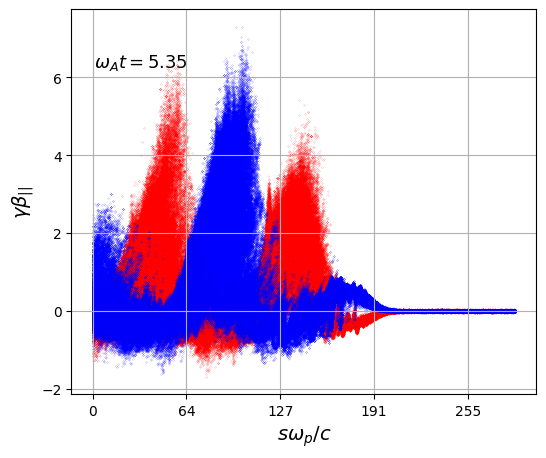

In [9]:
def B_parallel_frame(sw_mix, x_ref, x_coords, y_coords):
    
    w_lim = (1 - sw_mix) * grid_y / np.cos(psi)
    s_lim = sw_mix * grid_y / np.sin(psi)
    
    points = np.column_stack((x_coords, y_coords))
    
    origin = [x_ref, 0]

    # Unit vectors
    S = np.array([np.cos(psi), np.sin(psi)]) #s_vec / s_lim
    W = np.array([-np.sin(psi), np.cos(psi)]) #w_vec / w_lim

    # Project all points into rectangle coordinate system
    rel = points - origin
    s_proj = rel @ S
    w_proj = rel @ W

    # Inside test 
    mask = (
        (s_proj >= 0) & (s_proj <= s_lim) &
        (w_proj >= 0) & (w_proj <= w_lim)
    )
    return mask, s_proj, w_proj

def animate_particle_b_parr(ax1, frame):
    ax1.clear()
    
    x_ref = 8000
    sw_mix = 0.9
    
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    y1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']
    mask_1, s_proj1, w_proj_1 = B_parallel_frame(sw_mix, x_ref, x1, y1)
    
    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']
    mask_2, s_proj2, w_proj_2 = B_parallel_frame(sw_mix, x_ref, x2, y2)    
    
#     x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) )
#     x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 3500 )   
    sstride = 1
    ax1.scatter(s_proj1[mask_1], ux_1[mask_1] * np.cos(psi) + uy_1[mask_1] * np.sin(psi), s = 0.01, color = "red", label=r"$e^{+}$")
    ax1.scatter(s_proj2[mask_2], ux_2[mask_2] * np.cos(psi) + uy_2[mask_2] * np.sin(psi), s = 0.01, color = "blue", label=r"$e^{-}$")    
#     ax1.set_xlim(x_lim_low, x_lim_high)    
    ax1.xaxis.set_major_formatter(ticks_x)    
    ax1.set_xlabel(r"$s \omega_{p}/ c$", fontsize = 14)
    ax1.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
    ax1.text(0.15, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval_prtl * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax1.transAxes)
    ax1.grid()
    
fig, ax1 = plt.subplots(figsize=(6, 5))
animate_particle_b_parr(ax1, frame = 2400 * 5)
plt.show()

Found 73 overdense regions and 153 underdense regions
Overdense: area=1328.0, max=0.49, centroid=(np.float64(20.310993975903614), np.float64(25.20707831325301))
Overdense: area=49.0, max=0.24, centroid=(np.float64(3.0816326530612246), np.float64(18.918367346938776))
Overdense: area=698.0, max=0.38, centroid=(np.float64(25.73495702005731), np.float64(85.38538681948424))
Overdense: area=84.0, max=0.30, centroid=(np.float64(7.011904761904762), np.float64(212.3452380952381))
Overdense: area=84.0, max=0.18, centroid=(np.float64(37.833333333333336), np.float64(65.32142857142857))
Overdense: area=318.0, max=0.35, centroid=(np.float64(68.562893081761), np.float64(191.83962264150944))
Overdense: area=893.0, max=0.37, centroid=(np.float64(64.02911534154535), np.float64(23.31690929451288))
Overdense: area=110.0, max=0.31, centroid=(np.float64(54.38181818181818), np.float64(72.60909090909091))
Overdense: area=38.0, max=0.25, centroid=(np.float64(71.57894736842105), np.float64(127.97368421052632))


<IPython.core.display.Javascript object>


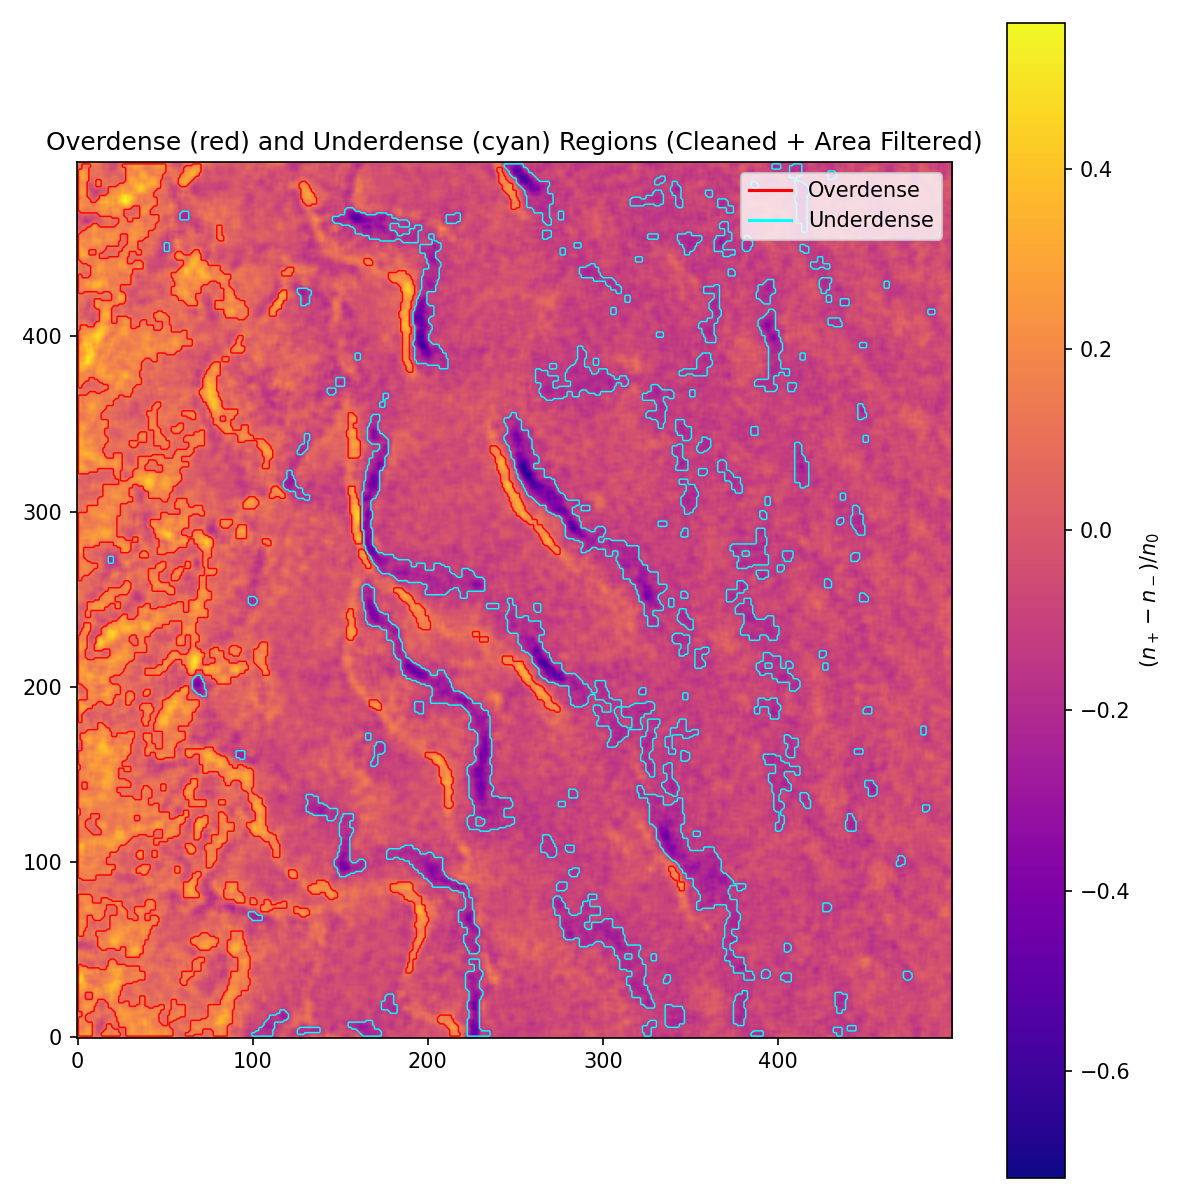

In [9]:
import numpy as np
from scipy import ndimage
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt

# --- Load data subset ---
rho = arr_func(2400)[1450:1950, 10000:10500]

# --- Compute thresholds (percentile-based) ---
pos_thresh = np.percentile(rho, 90)  # top 10%
neg_thresh = np.percentile(rho, 10)  # bottom 10%

# --- Create initial binary masks ---
mask_pos = rho > pos_thresh   # Overdense (positive)
mask_neg = rho < neg_thresh   # Underdense (negative)

# --- Morphological filtering ---
structure = np.ones((3, 3))

mask_pos_clean = ndimage.binary_opening(mask_pos, structure=structure)
mask_pos_clean = ndimage.binary_closing(mask_pos_clean, structure=structure)
mask_neg_clean = ndimage.binary_opening(mask_neg, structure=structure)
mask_neg_clean = ndimage.binary_closing(mask_neg_clean, structure=structure)

# --- Area filtering ---
# (remove small objects based on pixel count)
min_area = 10  # adjust based on resolution; typical values: 5–50 pixels

mask_pos_clean = remove_small_objects(mask_pos_clean.astype(bool), min_size=min_area)
mask_neg_clean = remove_small_objects(mask_neg_clean.astype(bool), min_size=min_area)

# --- Label connected regions after cleaning ---
labels_pos, n_pos = ndimage.label(mask_pos_clean)
labels_neg, n_neg = ndimage.label(mask_neg_clean)

# --- Extract region properties ---
regions_pos = regionprops(labels_pos, intensity_image=rho)
regions_neg = regionprops(labels_neg, intensity_image=rho)

print(f"Found {n_pos} overdense regions and {n_neg} underdense regions")

for r in regions_pos:
    print(f"Overdense: area={r.area}, max={r.max_intensity:.2f}, centroid={r.centroid}")

for r in regions_neg:
    print(f"Underdense: area={r.area}, min={r.min_intensity:.2f}, centroid={r.centroid}")

# --- Visualization ---
plt.figure(figsize=(8,8))
im = plt.imshow(rho, cmap='plasma', origin = 'lower')  # store mappable for colorbar
plt.contour(mask_pos_clean, colors='red', linewidths=0.7, levels=[0.5])
plt.contour(mask_neg_clean, colors='cyan', linewidths=0.7, levels=[0.5])
plt.plot([], [], color='red', label='Overdense')
plt.plot([], [], color='cyan', label='Underdense')
plt.colorbar(im, label=r'$(n_+ - n_-)/n_0$')
plt.legend()
plt.title('Overdense (red) and Underdense (cyan) Regions (Cleaned + Area Filtered)')
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


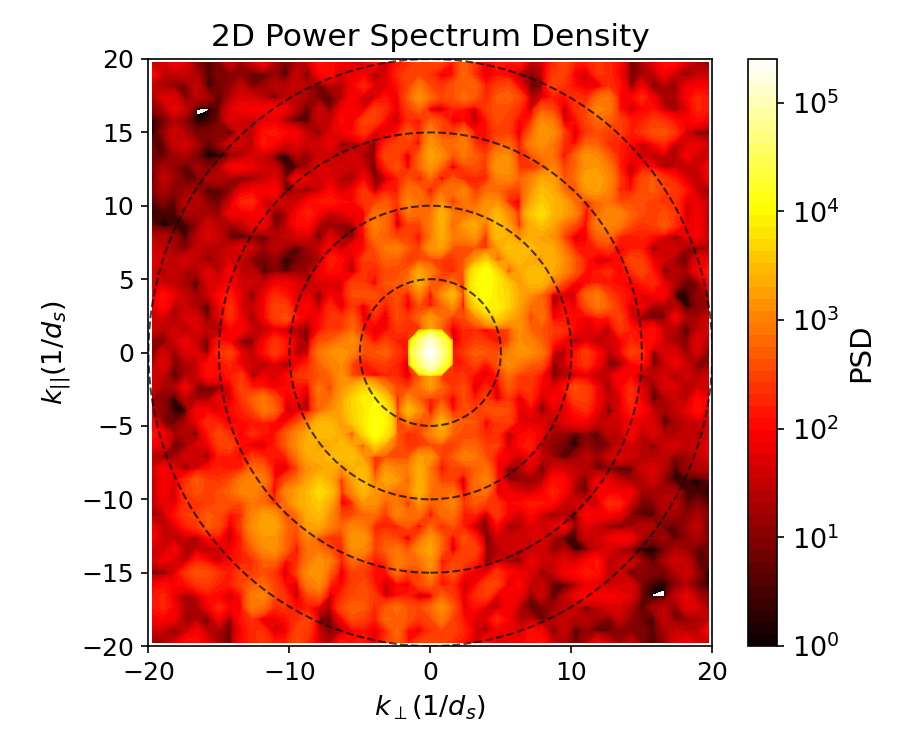

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import fftpack
from scipy.signal import windows  # For window functions

def calculate_2d_psd(image_data, dx, dy, window=True):
    """
    Calculate the 2D power spectrum density of an image with physical units.
    
    Parameters:
    -----------
    image_data : 2D numpy array
        The input image data
    dx, dy : float
        Physical size of each grid cell in x and y directions
    window : bool, optional
        Apply Hann window to reduce edge effects (default: True)
    
    Returns:
    --------
    k_x, k_y : 2D numpy arrays
        Wavenumber grids in x and y directions
    psd_2d : 2D numpy array
        The 2D power spectrum density
    """
    # Get dimensions
    ny, nx = image_data.shape
    
    # Apply window function to reduce edge effects
    if window:
        window_x = windows.hann(nx)  # Using scipy.signal.windows.hann
        window_y = windows.hann(ny)
        window_2d = np.outer(window_y, window_x)
        windowed_data = image_data * window_2d
    else:
        windowed_data = image_data
    
    # Compute the 2D FFT
    fft_data = fftpack.fft2(windowed_data)
    
    # Shift the zero frequency to the center
    fft_shifted = fftpack.fftshift(fft_data)
    
    # Calculate the PSD (power spectrum density)
    psd_2d = np.abs(fft_shifted)**2
    
    # Normalize by the number of elements and physical grid size
    psd_2d = psd_2d / (nx * ny * dx * dy)
    
    # Calculate the frequency grids with physical units
    # The frequency step is the reciprocal of the domain size
    df_x = 1.0 / (nx * dx)
    df_y = 1.0 / (ny * dy)
    
    # Create frequency grid centered at zero
    f_x = fftpack.fftshift(fftpack.fftfreq(nx, d=dx))
    f_y = fftpack.fftshift(fftpack.fftfreq(ny, d=dy))
    
    # Convert to wavenumber (k = 2π/λ = 2πf)
    k_x, k_y = np.meshgrid(2 * np.pi * f_x, 2 * np.pi * f_y)
    
    return k_x, k_y, psd_2d



def plot_2d_psd(k_x, k_y, psd_2d, k_limits=None, k_units="1/cm", log_scale=True, 
                title="2D Power Spectrum Density", save_path=None):
    """
    Plot the 2D power spectrum density using contourf with restricted k-range.
    
    Parameters:
    -----------
    k_x, k_y : 2D numpy arrays
        Wavenumber grids in x and y directions
    psd_2d : 2D numpy array
        The 2D power spectrum density
    k_limits : tuple, optional
        Limits for both axes in the form (k_min, k_max). If None, use data limits.
    k_units : str, optional
        Units for the wavenumbers (default: "1/cm")
    log_scale : bool, optional
        Use logarithmic color scale (default: True)
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Extract 1D wavenumber arrays
    k_x_1d = k_x[0, :]  # Length nx, varies with f_x
    k_y_1d = k_y[:, 0]  # Length ny, varies with f_y
    
    # Transpose psd_2d to match desired axis order (k_y on x-axis, k_x on y-axis)
    psd_2d_transposed = psd_2d.T  # Shape (nx, ny)
    
    # Apply mask if k_limits is specified
    if k_limits is not None:
        k_min, k_max = k_limits
        # Create 1D masks for k_x and k_y
        mask_x = (k_x_1d >= k_min) & (k_x_1d <= k_max)  # Length nx
        mask_y = (k_y_1d >= k_min) & (k_y_1d <= k_max)  # Length ny
        # Create 2D mask with shape (nx, ny)
        mask = np.outer(mask_x, mask_y)
        psd_masked = np.copy(psd_2d_transposed)
        # Set values OUTSIDE the range to NaN
        psd_masked[~mask] = np.nan
    else:
        psd_masked = psd_2d_transposed
        k_min = min(k_y_1d.min(), k_x_1d.min())
        k_max = max(k_y_1d.max(), k_x_1d.max())
    
    # Set levels for contourf
    if log_scale:
        psd_min = np.nanmin(psd_masked[psd_masked > 0])
        psd_max = np.nanmax(psd_masked)
        levels = np.logspace(0, np.log10(psd_max), 50)
        norm = LogNorm(vmin=1, vmax=psd_max)
    else:
        psd_min = np.nanmin(psd_masked)
        psd_max = np.nanmax(psd_masked)
        levels = np.linspace(psd_min, psd_max, 50)
        norm = None
    
    # Create the contour plot (k_y on x-axis, k_x on y-axis)
    contour = ax.contourf(k_y_1d, k_x_1d, psd_masked, levels=levels, norm=norm, cmap='hot')
    
    # Add colorbar
    cb = fig.colorbar(contour)
    cb.set_label('PSD', fontsize=14)
    cb.ax.tick_params(labelsize=13)
    
    if log_scale:
        min_exp = 0 #np.ceil(np.log10(psd_min))
        max_exp = np.floor(np.log10(psd_max))
        ticks = 10 ** np.arange(min_exp, max_exp + 1)
        cb.set_ticks(ticks)
        cb.set_ticklabels([f'$10^{{{int(exp)}}}$' for exp in np.arange(min_exp, max_exp + 1)])
   
    
    # Set labels and title
    ax.set_xlabel(r'$k_{\perp}$' + f'({k_units})', fontsize=13)
    ax.set_ylabel(r'$k_{||}$' + f'({k_units})', fontsize=13)
    ax.set_title(title, fontsize=15)
    
    # Set tick font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add circles for constant |k| values
    for k_radius in np.linspace(0, k_max, 5)[1:]:
        circle = plt.Circle((0, 0), k_radius, fill=False, color='black', linestyle='--', alpha=0.7)
        plt.gca().add_patch(circle)
    
    # plt.axis('equal')
    plt.tight_layout()

    ax.set_xlim(k_min, k_max)
    ax.set_ylim(k_min, k_max)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    plt.show()

x_lim_low = 10000
x_lim_high = 10500
d_s = scale_x((x_lim_low + x_lim_high)/2)

rho = arr_func(2400)[1450:1950, x_lim_low:x_lim_high]
k_x, k_y, psd_2d = calculate_2d_psd(rho, dx = 1/d_s, dy = 1/d_s, window = True)
plot_2d_psd(k_x, k_y ,psd_2d, k_limits=(-20, 20), k_units=r"$1/d_s$", log_scale=True)
plt.show()


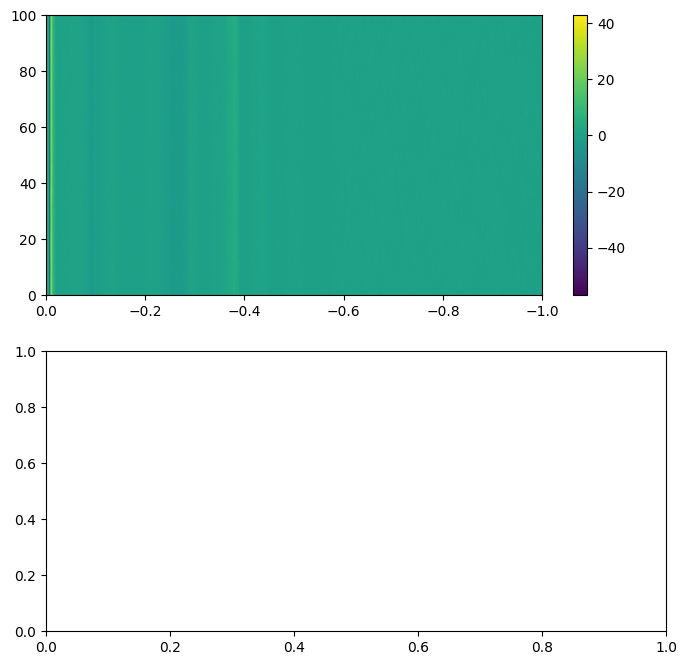

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

arr = arr_func(3000)
x_lim_low = 10214
x_lim_high = 12214
arr = arr[:, int(x_lim_low):int(x_lim_high)]
extent = [x_lim_low, x_lim_high, 0, arr.shape[0]]

im = ax1.imshow(arr, origin='lower', aspect='auto', extent=extent)
plt.colorbar(im, ax=ax1)

plt.show()


In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots(figsize=(8,2))

xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

def animate_By(frame):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[0,:]
    # ax.plot(xx, Bz[frame, 0, :]/(B_norm * B_0)) 
    ax.plot(xx, bz/(B_norm * B_0)) 
    ax.set_ylim(-0.015, 0.015)
    ax.set_xlabel(r"x-axis $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))    
    ax.set_ylabel(r"$B_z(x)/B_0$")
    #ax.legend(loc="upper left")
    return ax.lines  # Return a list of Artists

# Create the animation
ani = FuncAnimation(fig, animate_By, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=15, bitrate=1800)
ani.save("./Bz(x,t)_PARAMS_B_amp_plasma_test4= {:.2f}.mp4".format(B_amp), 
         writer=writer, dpi=400)

plt.show()

100%|██████████████████████████████████████████████████████████████████████| 250/250 [13:47<00:00,  3.31s/it]


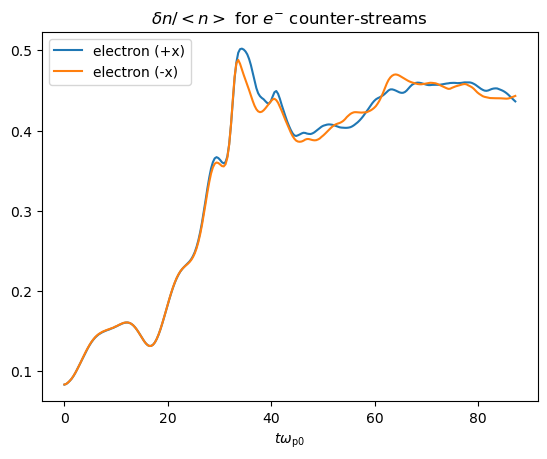

In [69]:
delta_d1 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens1"][0,:400,:5000]) for frame in tqdm(range(250))])
delta_d2 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens2"][0,:400,:5000]) for frame in tqdm(range(250))])

mean_d1  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens1"][0,:,:])
mean_d2  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens2"][0,:,:])

T =np.arange(delta_d1.shape[0]) * interval * omegap0
fig, ax = plt.subplots()
ax.plot(T, delta_d1/mean_d1, label = "electron (+x)")
ax.plot(T, delta_d2/mean_d2, label = "electron (-x)")
ax.set_title(r"$\delta n / <n>$ for $e^{-}$ counter-streams")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
# ax.set_xlim(0, 24)
# ax.set_ylabel(r"$U_E / E_{\rm tot}$")
plt.legend()

In [26]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
ax1.tick_params(axis='both', which='major', labelsize=13)
# scale_x = CC / omegap0
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
# ax1.xaxis.set_major_formatter(ticks_x)

# n0_data = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = (0,1))
# scale_x = lambda x: CC / omegap0 * np.sqrt(n0_data[5]/n0_data[int(x)])
# integ_scalex = lambda x: 1/scale_x(x)
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(sp.integrate.quad(integ_scalex ,0, x)[0]))

# Function to update the frame
def animate_ampere(frame):
    ex_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ex"][:,:,:], axis = 0)*B_norm
    ey_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ey"][:,:,:], axis = 0)*B_norm
    ex_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ex"][:,:,:], axis = 0)*B_norm
    ey_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ey"][:,:,:], axis = 0)*B_norm
    del_t_ex     = (ex_2 - ex_1)/(2 * interval_flds * omegap0)
    del_t_ey     = (ey_2 - ey_1)/(2 * interval_flds * omegap0)
    
    jx           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = 0) * B_norm /omegap0 * CC
    jy           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = 0) * B_norm /omegap0 * CC
    
    bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)*B_norm
    del_x_bz     = np.gradient(bz, axis = 1) / (omegap0/CC)
    del_y_bz     = np.gradient(bz, axis = 0) / (omegap0/CC)

    curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)
    del_t_e_parr = np.average(del_t_ex * np.cos(psi) + del_t_ey * np.sin(psi), axis = 0)
    j_parr       = np.average(      jx * np.cos(psi) +       jy * np.sin(psi), axis = 0)
    
    ax1.clear()
    
    ax1.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax1.plot(xx, bz[0]                        ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    ax1.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    ax1.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    ax1.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr  ,color = "black", linewidth = 0.7, label = r"$\nabla \times B_{||} - j_{||} - \partial_t E_{||}$")
    ax1.legend() 

    ax1.xaxis.set_major_formatter(ticks_x)
    
    # ax1.set_xlim(grid_x - 40 , grid_x)
    # ax1.set_xlim(18000, 26000)
#     ax1.set_xlim(frame * CC * interval_flds * np.cos(psi) - 500, frame * CC * interval_flds * np.cos(psi) + 20000) #grid_x/2
    # ax1.set_ylim(-5e-5, 5e-5)
    ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
    ax1.set_ylabel(r"Ampere's law terms (scale = $B_0$)", fontsize = 14)
    ax1.text(0, 0, r"$\omega_{p}t$ = " + "{:.2f}".format(frame * interval_flds * omegap0), fontsize=12, transform=ax1.transAxes)
    ax1.legend(loc="lower right", fontsize = 13)
    ax1.axvline(init_x_boundary, color='black', linestyle='--')
    ax1.axvline(fin_x_boundary, color='black', linestyle='--')
    ax1.grid()
    # # ax2.psd(del_t_e_parr[2500:6000], Fs = (omegap0/CC)**(-1))
    # ax2.clear()
    
    # ax2.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax2.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax2.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax2.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    # ax2.legend()
    # # ax2.set_xlim(grid_x/3, 2 * grid_x/3)
    # ax2.xaxis.set_major_formatter(ticks_x)
    # ax2.set_xlim(grid_x/2, grid_x)
    # ax2.set_xlabel(r"$x \omega_{p}/ c$")
    # ax2.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    # ax2.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    # ax2.legend(loc="lower right")

    # ax3.clear()
    
    # ax3.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax3.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax3.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax3.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    # ax3.legend()
    # ax3.set_xlim( 2 * grid_x/3, grid_x)
    # ax3.set_xlabel(r"$x-axis$")
    # ax3.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    # ax3.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    # ax3.legend(loc="lower right")
    # return ax1.get_children() + ax2.get_children() + ax3.get_children()  # Return a list of Artists

# # # Create the animation
# ani = FuncAnimation(fig, animate_ampere, frames=tqdm(range(1, 890)), blit=False)

# # # Save the animation
# writer = FFMpegWriter(fps=10, bitrate=2400)
# ani.save("Ampere(x)_B_amp = {:.2f}, dens1 = {:.1f}, dens2 = {:.1f}, angle = {:.2f}.mp4".format(B_amp, mult1, mult2, psi), 
#          writer=writer, dpi=400)

animate_ampere(100)
plt.show()

In [391]:
"""
Radiation post-processing from currents
"""



import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit 
# Constants
mu_0 = 1  # Permeability of free space
# c = 1  # Speed of light

# Function to compute retarded time
@jit
def retarded_time(x, x_prime, t):
    return t - np.linalg.norm(x - x_prime) / CC

# Function to perform linear interpolation for current density
@jit
def interpolate_current_density(j_data, t_r, t_data):
    # Find the two closest time points around t_r
    n = np.searchsorted(t_data, t_r)
    if n < len(t_data) and n > 0:
        j_tn = j_data[n-1]  # Current density at time t_n
        j_tn1 = j_data[n]    # Current density at time t_{n+1}
        # Linear interpolation across time
        j_t_r = j_tn + (t_r - t_data[n-1]) / (t_data[n] - t_data[n-1]) * (j_tn1 - j_tn)
        return j_t_r
    else:
        raise ValueError("Retarded time is outside the range of available time steps")

# Function to compute vector potential
@jit
def vector_potential(x, J_data, x_prime, jacob, t, t_data, grid_shape):
    A = np.zeros(3)  # Vector potential has 3 components (in 3D)
    # Reshape J_data to access spatial points easily
    # print(J_data.shape)
    J_data_reshaped = J_data.reshape(len(t_data), -1, 3)  # Shape: (Nt, N, 3)

    # Compute vector potential by summing contributions from all sources
    for i, x_p in enumerate(x_prime):
        t_r = retarded_time(x, x_p, t)  # Get the retarded time
        J_xp_t = J_data_reshaped[:, i, :]  # Time series for one point
        J_xp_tr = interpolate_current_density(J_xp_t, t_r, t_data)  # Interpolated current density
        distance = np.linalg.norm(x - x_p)
        if distance > 0:  # Avoid division by zero
            A += (mu_0 / (4 * np.pi)) * J_xp_tr / distance * jacob
    return A

# Function to compute electric field
def electric_field(A_t, A_t_plus_dt, dt):
    return -(A_t_plus_dt - A_t) / dt  # E = -dA/dt

# Function to compute luminosity
def luminosity(E):
    return np.sum(E**2)  # L ∝ |E|²



649.5789426803395 781.1184471999637
847.9635232985597 916.2907963137377


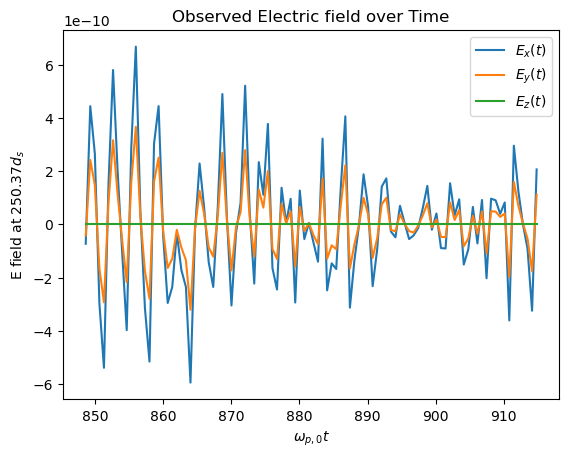

In [401]:
# 2D Simulation Parameters
frame_0 = 100
frame_f = 400

frame_data = np.arange(frame_0, frame_f)  # frames array
t_data = frame_data * interval * omegap0
dt = t_data[1] - t_data[0]

x_obs = np.array([frame_f * CC * interval * np.cos(psi) + 10000, grid_y//2]) * omegap0/CC # Observation point (in x-y plane, z is kept 0)

# Create a 2D grid of source points in the x-y plane
# grid_size = 100  # Number of grid points per axis
x_vals = np.arange(int(frame_0 * CC * interval * np.cos(psi)) - 200, int((frame_0 + 2) * CC * interval * np.cos(psi)) + 4500) * omegap0/CC
y_vals = np.arange(grid_y) * omegap0/CC

dx = (x_vals[-1] - x_vals[0])/x_vals.shape[0]
dy = (y_vals[-1] - y_vals[0])/y_vals.shape[0]

jacob = dx * dy
# Create a structured 2D grid (Nx, Ny)
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# # Define vector current density function J(x, y, t) with three components (Jx, Jy, Jz)
def J(frame):
    jx           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,int(frame_0 * CC * interval * np.cos(psi)) - 200 : int(frame_f * CC * interval * np.cos(psi)) + 4500], axis = 0)/B_norm 
    jy           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,int(frame_0 * CC * interval * np.cos(psi)) - 200 : int(frame_f * CC * interval * np.cos(psi)) + 4500], axis = 0)/B_norm  
    jz           = np.zeros_like(jx)
    return np.stack([jx, jy, jz], axis=-1)  # Stack components along last axis


# Compute J_data for all time steps (shape: (Nt, Nx, Ny, 3))
# J_data = np.array(Parallel(n_jobs=10)(delayed(J)(frame) for frame in tqdm(frame_data, desc = "Loading currents...")))


# J_data = np.array([J(frame) for frame in tqdm(frame_data, desc = "Loading currents...")])

# Flatten the 2D grid to pass as source points
x_prime_grid = np.vstack([X.ravel(), Y.ravel()]).T  # (N, 2)

# Precompute distances between the observation point and source points
distances = np.linalg.norm(x_obs[:2] - x_prime_grid, axis=1)  # Only x and y components

# Compute the min and max distances for retarded times
d_min = np.min(distances)
d_max = np.max(distances)

print(d_min/CC, d_max/CC)

t_min_obs = t_data[0] + d_max / CC  # Earliest observation time
t_max_obs = t_data[-1] + d_min / CC  # Latest observation time
obs_t_range = np.arange(t_min_obs + dt, t_max_obs - 2*dt, dt)

print(t_min_obs, t_max_obs)
# Parallel computation of luminosity using joblib
def compute_luminosity_for_time(t):
    A_t = vector_potential(x_obs, J_data, x_prime_grid, jacob, t, t_data, X.shape)
    A_t_plus_dt = vector_potential(x_obs, J_data, x_prime_grid, jacob, t + dt, t_data, X.shape)
    E = electric_field(A_t, A_t_plus_dt, dt)
    L = luminosity(E)
    return np.array(E)

# luminosity_values = [compute_luminosity_for_time(t) for t in obs_t_range]
E_values = np.array(Parallel(n_jobs=10)(delayed(compute_luminosity_for_time)(t) for t in obs_t_range))

# Plot the luminosity over time
# plt.plot(obs_t_range, luminosity_values)
plt.plot(obs_t_range, E_values[:, 0], label = r"$E_x (t)$")
plt.plot(obs_t_range, E_values[:, 1], label = r"$E_y (t)$")
plt.plot(obs_t_range, E_values[:, 2], label = r"$E_z (t)$")
plt.xlabel(r'$\omega_{p,0} t$')
# plt.ylabel('Luminosity')
plt.ylabel('E field at {:.2f}'.format((d_min + d_max) /2) + r'$d_s$')
# plt.title('Radiated Luminosity Over Time')
plt.title('Observed Electric field over Time')
plt.legend()
plt.show()



In [ ]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

#ax.set_title(r"Charge density $=|e^-| (n_{e^+}-n_{e^-})$")
ax1.set_title(r"$E_{||} (x,y) $ ")
div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')

def arr_func(step):
    return Ex[step,:,:]*np.cos(psi) + Ey[step,:,:]*np.sin(psi)#density1[step, : , : ] - density2[step, : , : ]

im = ax1.imshow(arr_func(0), origin='lower', aspect = 'auto') 
cb = fig.colorbar(im, cax=cax)
tx = ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")


# Function to update the frame
def animate_scalar(frame):
    arr = arr_func(frame)
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi)) 

    ax2.clear()
    ax2.plot(xx, Bz[frame, 0, :])   
    ax2.set_ylim(0, 0.3)
    ax2.set_xlabel(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))    
    ax2.set_ylabel(r"$B_z(x)$")
    return ax2.get_children()
# Create the animation
ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=15, bitrate=2400)
ani.save("../vault_out/Wave_embed/E_par(x,y)_PARAMS_B_amp_plasma_19 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
         writer=writer, dpi=400)

plt.show()


In [5]:

def dens_dat(step, spec = 1, diff = 0):
    dat = np.average(fetch_var_at_step(out_dir, "flds", step)["dens{}".format(spec)][:,:,:], axis = (0,1))
    dat0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens{}".format(spec)][:,:,:], axis = (0,1))
    dat = (dat - diff * dat0)/(ppc0 * weight_fac)
    return dat



fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7,6))

ax1.text(22000, 0.55 , r'$\omega_A t = {:.2f}$'.format(00 * interval * omegap0 * wA_wp), ha='center', fontsize=13)
ax2.text(22000, 0.55 , r'$\omega_A t = {:.2f}$'.format(2500 * interval * omegap0 * wA_wp), ha='center', fontsize=13)
ax3.text(22000, 0.55 , r'$\omega_A t = {:.2f}$'.format(5000 * interval * omegap0 * wA_wp), ha='center', fontsize=13)

ax1.set_ylim(0, 2.5)
ax2.set_ylim(0, 2.5)
ax3.set_ylim(0, 2.5)

ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_ylabel(r"$n_\pm/n_0$", fontsize = 14)
ax2.xaxis.set_major_formatter(ticks_x)
ax2.set_ylabel(r"$n_\pm/n_0$", fontsize = 14)
ax3.xaxis.set_major_formatter(ticks_x)
ax3.set_ylabel(r"$n_\pm/n_0$", fontsize = 14)

ax1.axvline(init_x_boundary, c = "black", linestyle = "--")
ax1.axvline(fin_x_boundary, c = "black", linestyle = "--")
ax2.axvline(init_x_boundary, c = "black", linestyle = "--")
ax2.axvline(fin_x_boundary, c = "black", linestyle = "--")
ax3.axvline(init_x_boundary, c = "black", linestyle = "--")
ax3.axvline(fin_x_boundary, c = "black", linestyle = "--")

ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid()
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.grid()
ax3.tick_params(axis='both', which='major', labelsize=13)
ax3.grid()


# ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)

# ax1.set_ylabel("$n({}) - n(0)$".format(step))

# ax1.set_xlim(10000, 20000)

start_x = 500

ax1.plot(dens_dat(00)[start_x:] , linewidth = 0.8, c = "red", label = r"$e^+$")
ax1.plot(dens_dat(00, 2)[start_x:] , linewidth = 0.8, c = "blue", label = r"$e^-$")
ax1.annotate('', 
            xy=(init_x_boundary, 1), xytext=(fin_x_boundary, 1),
            arrowprops=dict(arrowstyle='<->', color='black'))
ax1.text((init_x_boundary + fin_x_boundary)/2, 1.1, r'{}$\lambda_A$'.format(int(ramp_width)), ha='center', fontsize=13)
ax1.axhline(mult1/2, c = 'green', linestyle = "--")
ax1.text(21000, mult1/2 + 0.1, r'$mult_1/2 = 1.5$', ha='center', fontsize=13)
ax1.axhline(mult2/2, c = 'blue', linestyle = "--")
ax1.text(21000, mult2/2 + 0.1, r'$mult_2/2 = 0.05$', ha='center', fontsize=13)
ax1.set_title(r"Initial $n_+$ profile ($y$-averaged)", fontsize = 15)


ax2.plot(dens_dat(2500)[start_x:], linewidth = 0.8, c = "red", label = r"$e^+$")
ax2.plot(dens_dat(2500, 2)[start_x:], linewidth = 0.8, c = "blue", label = r"$e^-$")


ax3.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
ax3.plot(dens_dat(5000)[start_x:], linewidth = 0.8, c = "red", label = r"$e^+$")
ax3.plot(dens_dat(5000, 2)[start_x:], linewidth = 0.8, c = "blue", label = r"$e^-$")

ax1.legend(fontsize = 13)
ax2.legend(fontsize = 13)
ax3.legend(fontsize = 13)
# fig.suptitle(r'Evolution of $e^+ - e^-$ density profile', fontsize=16)
plt.tight_layout()
plt.show()

[100 200 300 400 500]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


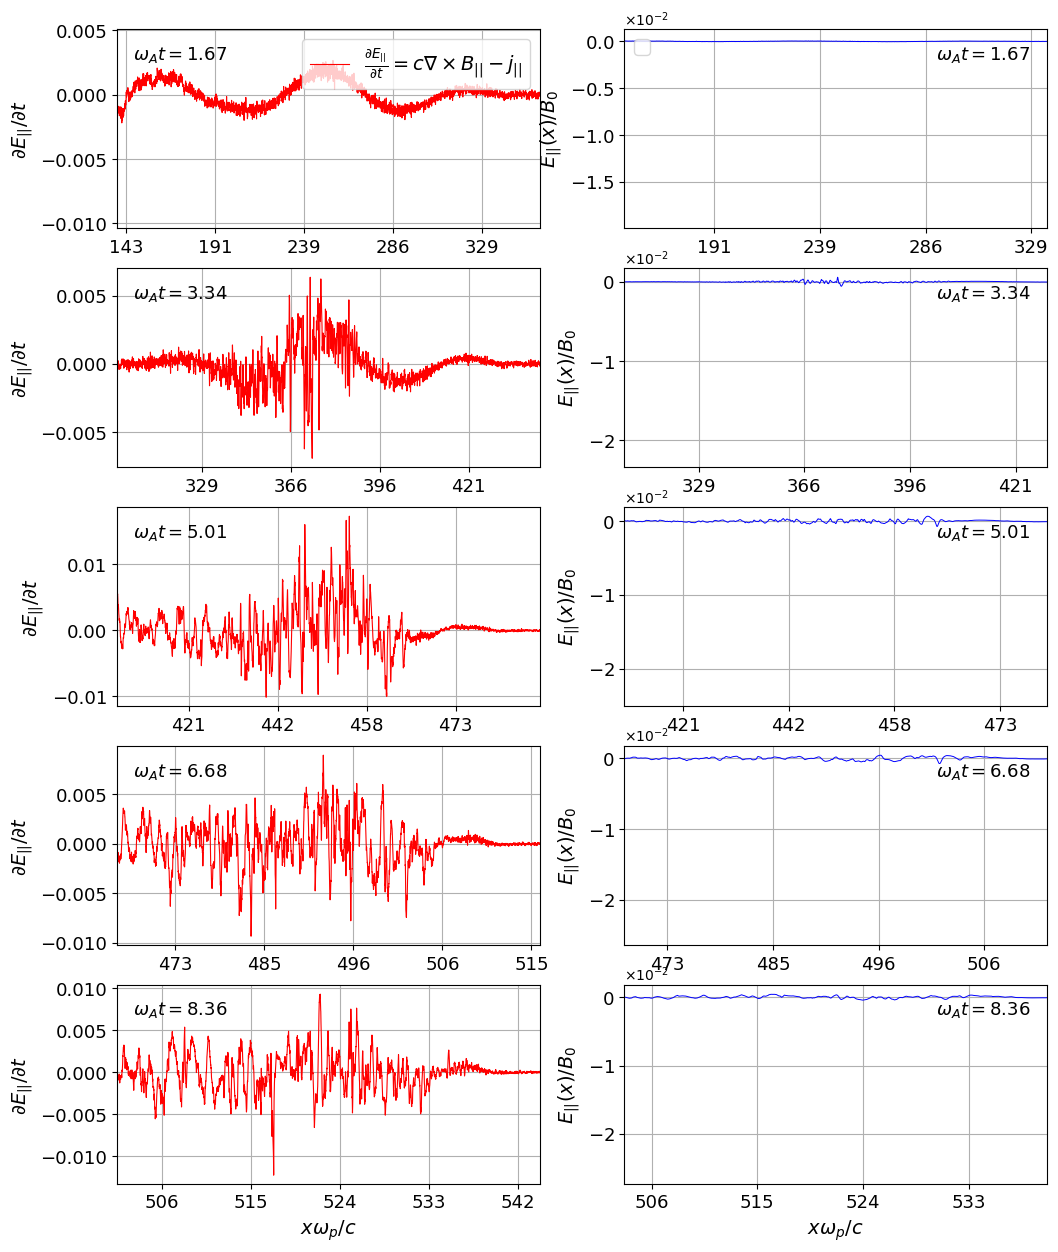

In [14]:
def animate_disp_current_2(ax2, frame):
    ax2.clear()
    
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) - 500)
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 9000 )
    
    j_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = (0, 1))[:]/B_norm
    j_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = (0, 1))[:]/B_norm
    j_parr = (j_x * np.cos(psi) + j_y * np.sin(psi)) / (ppc0 * weight_fac * unit_ch)

    bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)/B_norm
    del_x_bz     = np.gradient(bz, axis = 1) / (ppc0 * weight_fac * unit_ch)
    del_y_bz     = np.gradient(bz, axis = 0) / (ppc0 * weight_fac * unit_ch)
    curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)
    
    ax2.plot(xx, CC * curl_b_parr - j_parr, linewidth = 0.8, color = "red", label = r"$ \frac{\partial E_{||}}{\partial t} = c\nabla \times B_{||} - j_{||}$")
    # ax2.legend(fontsize = 14, markerscale=20)

    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
   
    ax2.set_ylabel(r"${\partial E_{||}}/{\partial t}$", fontsize = 14)
    ax2.text(0.15, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax2.transAxes)
    ax2.grid()

def animate_e_parr(ax2, frame):
    ax2.clear()
    
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) )
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 8000 ) 

    
    E_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["ex"][:,:,:], axis = (0, 1))[:]/B_norm
    E_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["ey"][:,:,:], axis = (0, 1))[:]/B_norm
    E_parr = E_x * np.cos(psi) + E_y * np.sin(psi)
    ax2.plot(xx, E_parr, color = 'blue', linewidth = 0.7)
        
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    # ax3.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(frame * interval * omegap0 * wA_wp), fontsize = 14)    
    ax2.set_ylabel(r"$E_{||}(x)/B_0$", fontsize = 14)
    
    ax2.grid() 
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

    ax2.text(0.85, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax2.transAxes)
    

N = 5 # no of snapshots
frames = np.linspace(100, 500, N, dtype = int)
print(frames)

fig, axes = plt.subplots(N, 2, figsize = (12,15))

for i in range(N):
    axes[i,0].tick_params(axis='both', which='major', labelsize=13)
    axes[i,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    animate_disp_current_2(axes[i,0], frames[i])

    axes[i,1].tick_params(axis='both', which='major', labelsize=13)
    
    animate_e_parr(axes[i,1], frames[i])

axes[-1,0].set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
axes[0,0].legend(loc="upper right", fontsize = 14, markerscale=30)

axes[-1,1].set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
axes[0,1].legend(loc="upper left", fontsize = 14, markerscale=30)
plt.show()

In [648]:
print(np.sin(np.arctan(15)))

0.9977851578566089


[600 700 800 900]


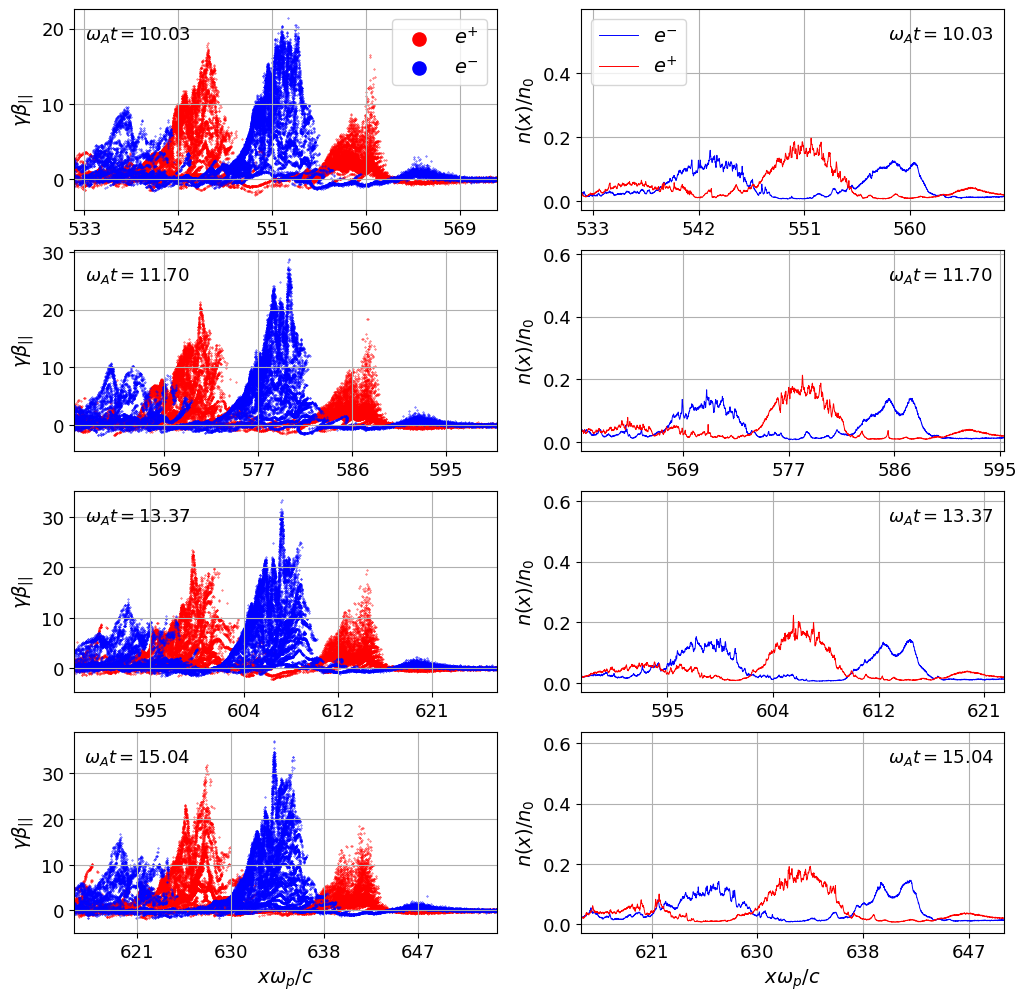

In [16]:
def animate_particle_2(ax1, frame):
    ax1.clear()
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']
    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) )
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 9000 )   
    sstride = 1
    ax1.scatter(x1[: : sstride], ux_1[: : sstride] * np.cos(psi) + uy_1[: : sstride] * np.sin(psi), s = 0.1, color = "red", label=r"$e^{+}$")
    ax1.scatter(x2[: : sstride], ux_2[: : sstride] * np.cos(psi) + uy_2[: : sstride] * np.sin(psi), s = 0.1, color = "blue", label=r"$e^{-}$")    
    ax1.set_xlim(x_lim_low, x_lim_high)    
    ax1.xaxis.set_major_formatter(ticks_x)    
    ax1.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
    ax1.text(0.15, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax1.transAxes)
    ax1.grid()

def animate_density_2(ax2, frame):
    ax2.clear()
    
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) )
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 8000 ) 

    
    n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) * 0.857
    ax2.plot(xx, n_e, color = 'blue', linewidth = 0.7, label = r'$e^{-}$')
    n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) * 0.857
    ax2.plot(xx, n_p, color = 'red', linewidth = 0.7, label = r'$e^{+}$')
    
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    # ax3.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(frame * interval * omegap0 * wA_wp), fontsize = 14)    
    ax2.set_ylabel(r"$n(x)/n_0$", fontsize = 14)
    
    ax2.grid()    

    ax2.text(0.85, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax2.transAxes)
    

N = 4 # no of snapshots
frames = np.linspace(600, 900, N, dtype = int)
print(frames)

fig, axes = plt.subplots(N, 2, figsize = (12,12))

for i in range(N):
    axes[i,0].tick_params(axis='both', which='major', labelsize=13)
    animate_particle_2(axes[i,0], frames[i])

    axes[i,1].tick_params(axis='both', which='major', labelsize=13)
    animate_density_2(axes[i,1], frames[i])

axes[-1,0].set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
axes[0,0].legend(loc="upper right", fontsize = 14, markerscale=30)

axes[-1,1].set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
axes[0,1].legend(loc="upper left", fontsize = 14, markerscale=30)
plt.show()

In [45]:
Spec = fetch_var_at_step(out_dir, "spec", 800, rad = True)
print(Spec.getTotal(s = 'r2'))
# plot(Spec.getByCoordinate(s = '1', xyz = (30000,50,0))[2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


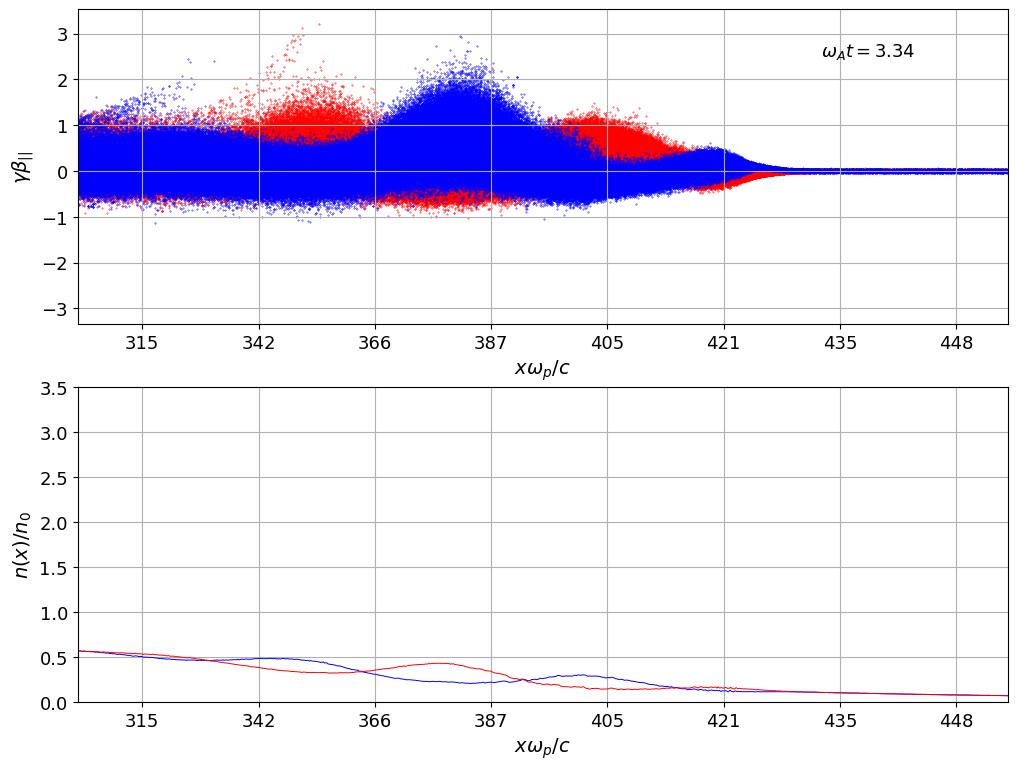

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
def animate_all(frame):
    ax1.clear()
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']
    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) )
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) + 4000 )   
    sstride = 1
    ax1.scatter(x1[: : sstride], ux_1[: : sstride] * np.cos(psi) + uy_1[: : sstride] * np.sin(psi), s = 0.1, color = "red", label=r"$e^{+}$")
    ax1.scatter(x2[: : sstride], ux_2[: : sstride] * np.cos(psi) + uy_2[: : sstride] * np.sin(psi), s = 0.1, color = "blue", label=r"$e^{-}$")    
    ax1.set_xlim(x_lim_low, x_lim_high)  
#     ax1.set_ylim(-1.5, 2)
    ax1.xaxis.set_major_formatter(ticks_x)    
    ax1.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
    ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
    ax1.text(0.85, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax1.transAxes)
    ax1.grid()

    ax2.clear()
    
   
    
    n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) / 3 #* 0.857
    ax2.plot(xx, n_e, color = 'blue', linewidth = 0.7, label = r'$e^{-}$')
    n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0,1))[:]/(ppc0 * weight_fac) / 3 #* 0.857
    ax2.plot(xx, n_p, color = 'red', linewidth = 0.7, label = r'$e^{+}$')
    
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    # ax3.set_xlabel(r"$x \omega_{p}/ c$, $\omega_A t$ = " + "{:.2f}".format(frame * interval * omegap0 * wA_wp), fontsize = 14)    
    ax2.set_ylabel(r"$n(x)/n_0$", fontsize = 14)
    ax2.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
    ax2.grid()    
    ax2.set_ylim(0, 3.5)

    # ax2.text(0.85, 0.85 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax2.transAxes)

# # animate_all(00)
# # Create the animation
# ani = FuncAnimation(fig, animate_all, frames=tqdm(range(900)), blit=False)

# # # Save the animation
# writer = FFMpegWriter(fps=20, bitrate=-1)
# ani.save("./phase_uni_B_amp = {:.2f}, dens1 = {:.1f}, dens2 = {:.1f}, angle = {:.2f}.mp4".format(B_amp, mult1, mult2, psi), 
#          writer=writer, dpi=400)
animate_all(1500)
plt.show()
# plt.show()

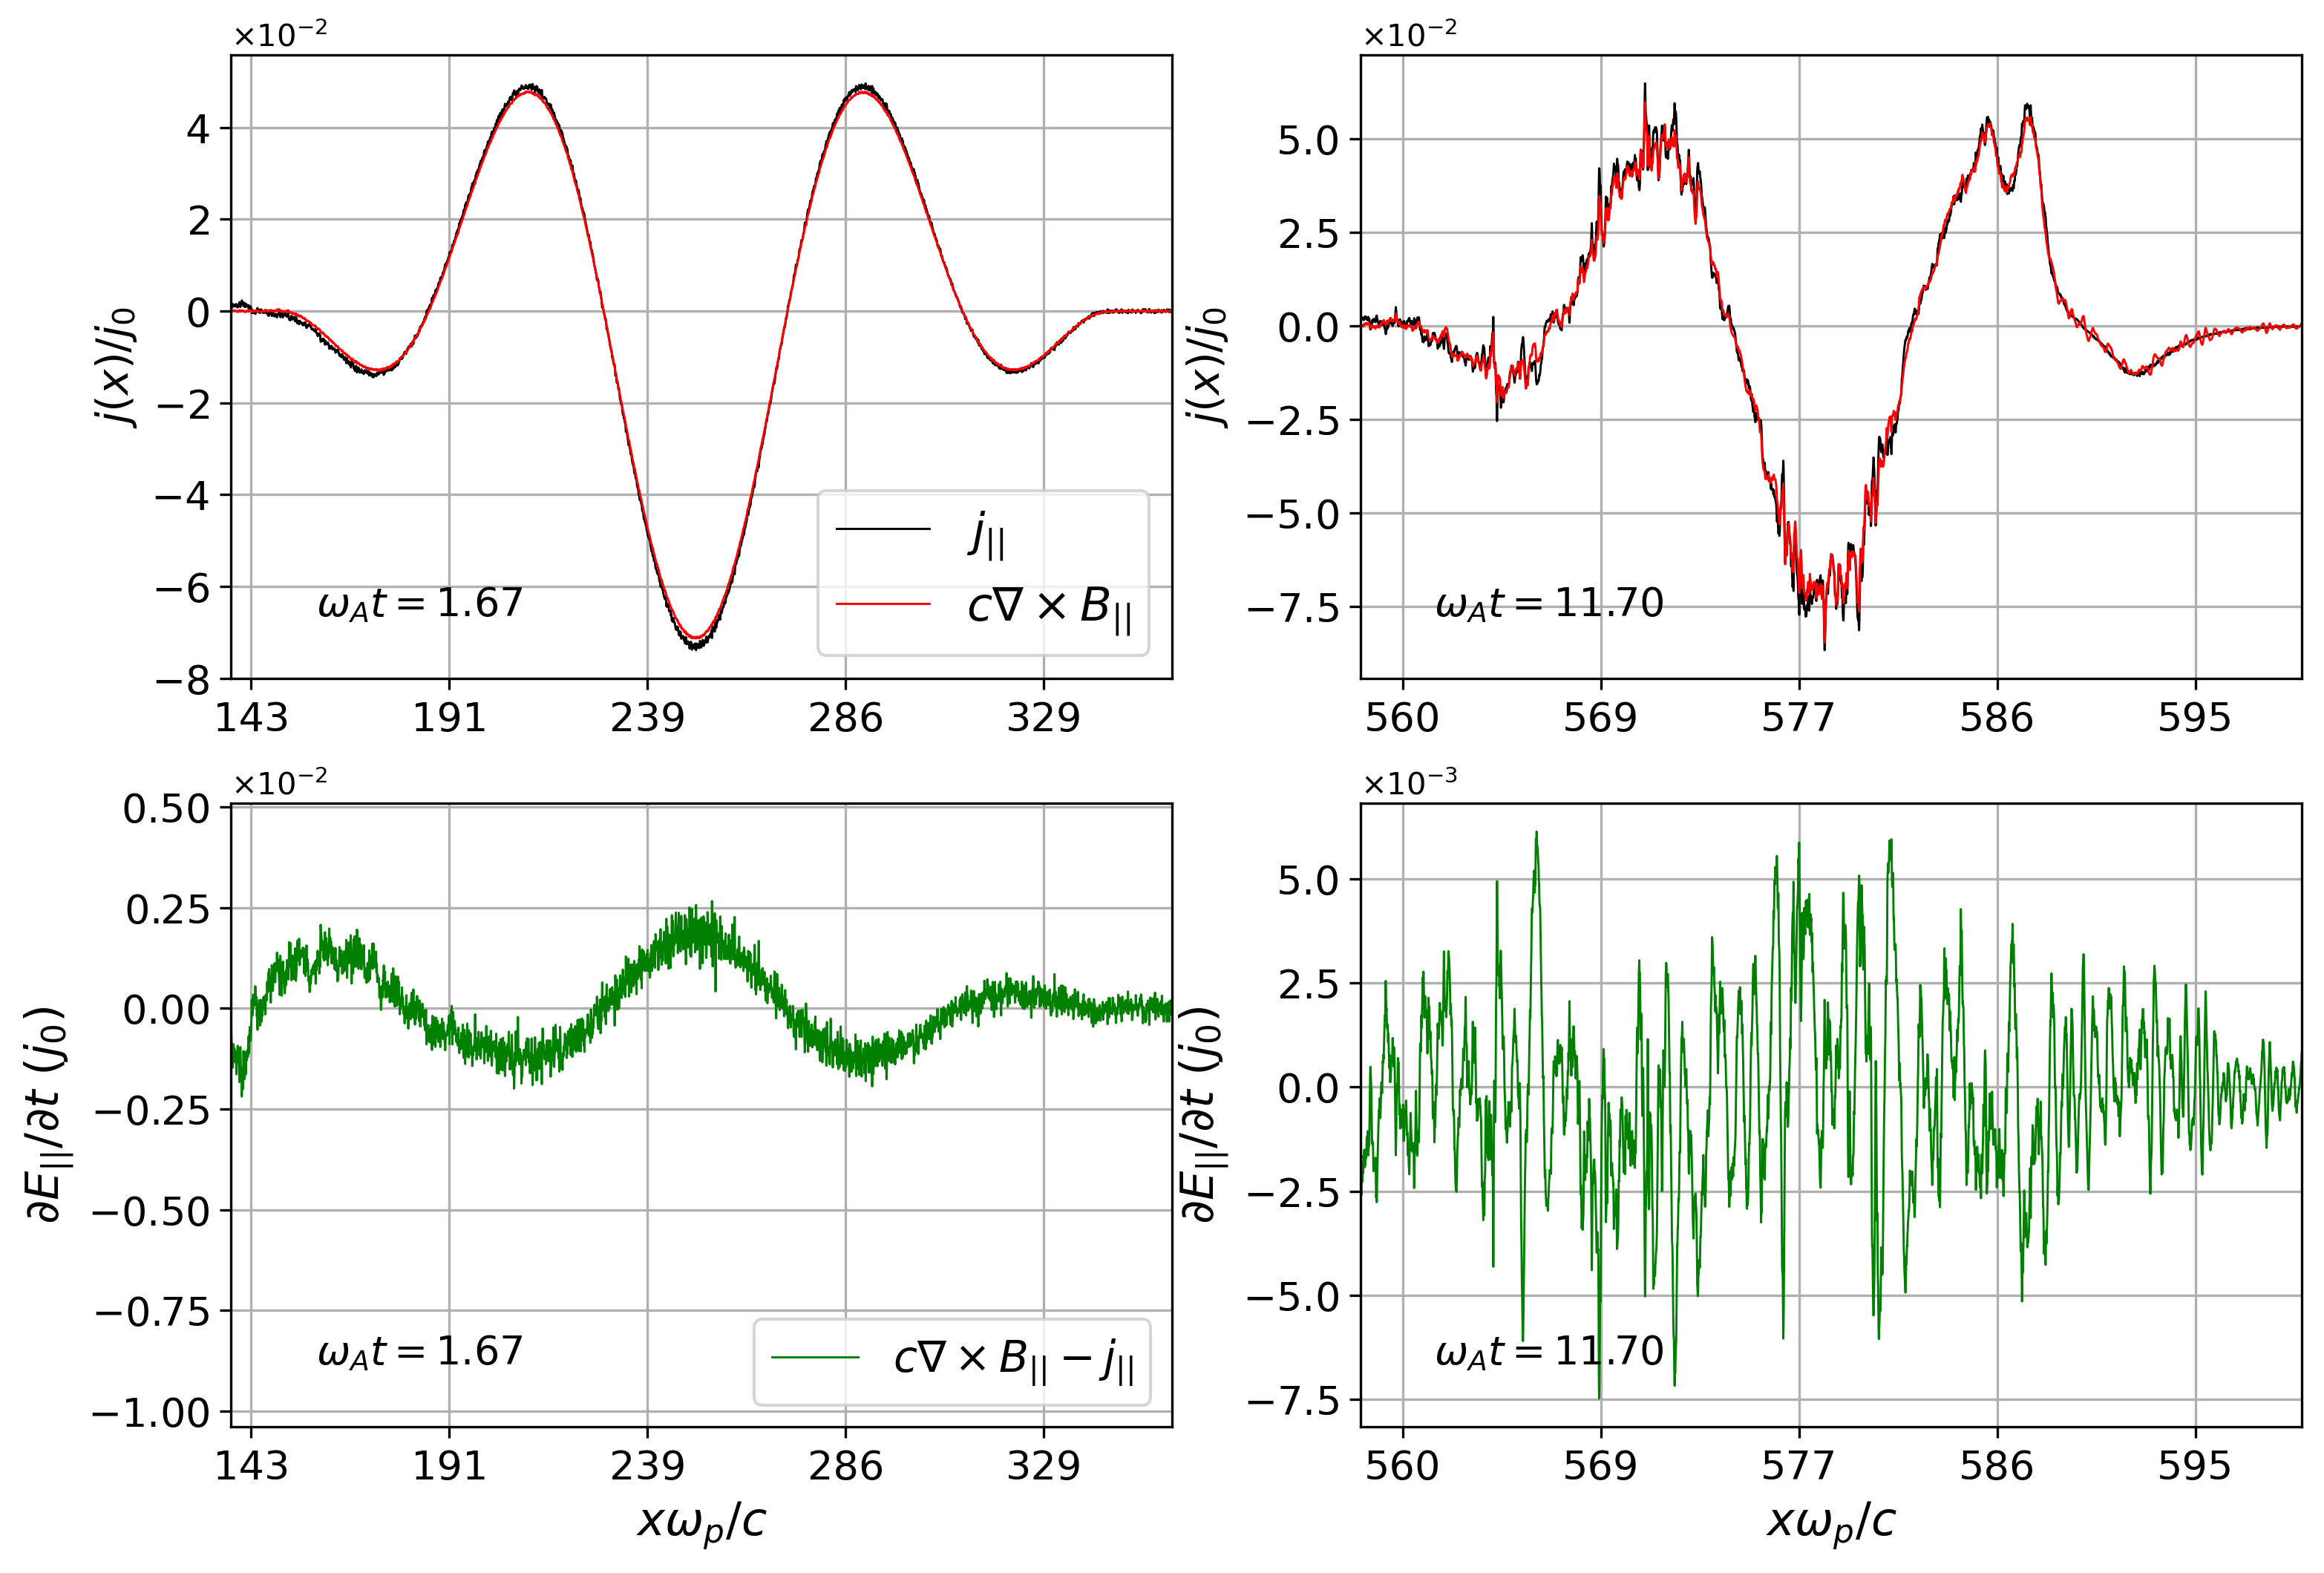

In [17]:
def animate_set(ax2, ax3, frame, isLegend = False, isYlabel = False):
    x_lim_low  = int(frame * CC * 1.025  * interval * np.cos(psi) -500)
    x_lim_high = int(frame * CC * 1.025  * interval * np.cos(psi) +9000 )
    ax2.clear()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    j_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = (0, 1))[:]/B_norm
    j_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = (0, 1))[:]/B_norm
    j_parr = (j_x * np.cos(psi) + j_y * np.sin(psi)) / (ppc0 * weight_fac * unit_ch)
    bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)/B_norm
    del_x_bz     = np.gradient(bz, axis = 1) / (ppc0 * weight_fac * unit_ch)
    del_y_bz     = np.gradient(bz, axis = 0) / (ppc0 * weight_fac * unit_ch)
    curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)    
    ax2.plot(xx, j_parr, linewidth = 0.7, color = "black", label = r"$j_{||}$")
    ax2.plot(xx, CC * curl_b_parr, linewidth = 0.7, color = "red", label = r"$c \nabla \times B_{||}$")
    if isLegend:
        ax2.legend(loc = "lower right", fontsize = 15, markerscale=20)   
    ax2.set_xlim(x_lim_low, x_lim_high)
    ax2.xaxis.set_major_formatter(ticks_x)
    if isYlabel:
        ax2.set_ylabel(r"$j(x)/j_0$", fontsize = 14)
    ax2.text(0.2, 0.1 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax2.transAxes)    
    ax2.grid()
    
    ax3.clear()
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax3.tick_params(axis='both', which='major', labelsize=13)
    ax3.plot(xx, CC * curl_b_parr - j_parr, linewidth = 0.7, color = "green", label = r"$c \nabla \times B_{||} - j_{||}$")
    ax3.set_xlim(x_lim_low, x_lim_high)
    ax3.xaxis.set_major_formatter(ticks_x)     
    if isYlabel:
        ax3.set_ylabel(r"${\partial E_{||}}/{\partial t}$ $(j_0)$", fontsize = 15)    
    ax3.grid() 
    ax3.text(0.2, 0.1 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax3.transAxes)
    if isLegend:
        ax3.legend(loc = "lower right", fontsize = 14, markerscale=20)
    
    # ax4.clear()    
    # E_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["ex"][:,:,:], axis = (0, 1))[:]/B_norm
    # E_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["ey"][:,:,:], axis = (0, 1))[:]/B_norm
    # E_parr = E_x * np.cos(psi) + E_y * np.sin(psi)
    # ax4.plot(xx, E_parr, color = 'blue', linewidth = 0.7, label = r"$E_{||}$")        
    # ax4.set_xlim(x_lim_low, x_lim_high)
    # ax4.xaxis.set_major_formatter(ticks_x)
    ax3.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 15)
    # if isYlabel:
    #     ax4.set_ylabel(r"$E_{||}(x)/B_0$", fontsize = 15)    
    # ax4.grid()
    # ax4.tick_params(axis='both', which='major', labelsize=13)
    # ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    # ax4.text(0.2, 0.1 , r'$\omega_A t = {:.2f}$'.format(frame * interval * omegap0 * wA_wp), ha='center', fontsize=13, transform = ax4.transAxes)
    # if isLegend:
    #     ax4.legend(loc = "lower right", fontsize = 14, markerscale=20)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi = 300)

animate_set(axes[0,0], axes[1,0], frame = 100, isLegend = True, isYlabel=True)
animate_set(axes[0,1], axes[1,1], frame = 700, isYlabel=True)
# animate_set(axes[0,2], axes[1,2], axes[2,2], frame = 600)
# plt.tight_layout()
plt.show()

In [14]:
import graphet
print(graphet.__file__)

/home1/10446/anindya_12/envs/tacc_jupyter_env/lib/python3.9/site-packages/graphet/__init__.py


In [4]:
import numpy as np
import graphet
# print(graphet.__file__)
from graphet import Data
from graphet.plugins import TristanV2


# Vectorized approach
def calculate_3_acceleration_fast(frame, species):
    d = Data(
    TristanV2,
    steps=range(frame-1, frame+2),  # Load the frames you need: frame-1, frame, frame+1
    path=out_dir,
    
    cfg_fname=input_file_name, # configuration file
    params=True,            # read configuration file
    # Add other parameters as needed
    )
    # Get particle data for all three frames
    particles_prev = d.particles[species].sel(t=frame-1)
    particles_curr = d.particles[species].sel(t=frame)
    particles_next = d.particles[species].sel(t=frame+1)
    
    # Get IDs from all frames
    prev_ids = set(particles_prev.idx.values)
    current_ids = set(particles_curr.idx.values)
    next_ids = set(particles_next.idx.values)
    
    # Find common IDs across all frames
    common_ids = list(prev_ids.intersection(current_ids).intersection(next_ids))
    
    # Convert to numpy arrays for faster operations
    common_ids_array = np.array(common_ids)
    
    # Create dictionaries mapping ID to index for fast lookup
    prev_id_to_idx = {id_val: i for i, id_val in enumerate(particles_prev.idx.values)}
    next_id_to_idx = {id_val: i for i, id_val in enumerate(particles_next.idx.values)}
    curr_id_to_idx = {id_val: i for i, id_val in enumerate(particles_curr.idx.values)}
    
    # Get indices in each frame's arrays for the common particles
    prev_indices = np.array([prev_id_to_idx[idx] for idx in common_ids])
    next_indices = np.array([next_id_to_idx[idx] for idx in common_ids])
    curr_indices = np.array([curr_id_to_idx[idx] for idx in common_ids])
    
    # Extract data using vectorized operations
    u_prev = particles_prev.u.values[prev_indices]
    v_prev = particles_prev.v.values[prev_indices]
    
    u_next = particles_next.u.values[next_indices]
    v_next = particles_next.v.values[next_indices]
    
    # Calculate parallel velocities (vectorized)
    v_parr_prev = u_prev * np.cos(psi) + v_prev * np.sin(psi)
    v_parr_next = u_next * np.cos(psi) + v_next * np.sin(psi)
    
    # Calculate acceleration (vectorized)
    acc_4 = CC * (v_parr_next - v_parr_prev) / (2 * interval * omegap0 * wA_wp)
    gamma = np.sqrt(1 + u_prev**2 + v_prev**2) 

    acc_3 = acc_4/gamma**4
    
    # Get current positions (vectorized)
    # x_positions = particles_curr.x.values[curr_indices]# / (ds/wA_wp)
    
    return acc_3, len(curr_indices)

frame = 600

# Calculating the second order derivative of the dipole moment of the radiating system.
acc_p, n_p = calculate_3_acceleration_fast(frame,1)
acc_e, n_e = calculate_3_acceleration_fast(frame,2)

dipole_d2t_av = (weight_fac * unit_ch/(4*np.pi)) * (np.average(acc_p) - np.average(acc_e))
P_rad = 2 / CC**2 / 3 * dipole_d2t_av**2 * stride * (n_p + n_e)

print(r"Total power radiated by particles in $m_e c^2 \omega_A$ = {}".format(P_rad / CC**2))

/home/anindya/anaconda3/lib/python3.12/site-packages/graphet/__init__.py
Total power radiated by particles in $m_e c^2 \omega_A$ = 4.144371073372861e-08


In [44]:
from graphet import Data
from graphet.plugins import TristanV2


bounds_x = [fin_x_boundary, grid_x]
bounds_y = [0, grid_y]


def farthest_pt(x_o):
    """
    Returns the coordinate of the farthest point of the simulation domain to observn. pt. x_o
    """
    farthest_dict = {"TL": np.array([max(bounds_x), min(bounds_y), 0]),
                     "TR": np.array([min(bounds_x), min(bounds_y), 0]),
                     "BL": np.array([max(bounds_x), max(bounds_y), 0]),
                     "BR": np.array([min(bounds_x), max(bounds_y), 0])}
    
    sector_code = ""
    
    if x_o[1] > sum(bounds_y)/2:
        sector_code += "T"
    else:
        sector_code += "B"
    
    if x_o[0] > sum(bounds_x)/2:
        sector_code += "R"
    else:
        sector_code += "L"
    
    return farthest_dict[sector_code]

def nearest_pt(x_o):
    """
    Returns the coordinate of the nearest point of the simulation domain to observn. pt. x_o
    """
    nearest_dict = {"TL": np.array([min(bounds_x), max(bounds_y), 0]),
                    "TC": np.array([x_o[0]       , max(bounds_y), 0]),
                    "TR": np.array([max(bounds_x), max(bounds_y), 0]),
                    "CL": np.array([min(bounds_x), x_o[1]       , 0]),
                    "CC": x_o,
                    "CR": np.array([max(bounds_x), x_o[1]       , 0]),
                    "BL": np.array([min(bounds_x), min(bounds_y), 0]),
                    "BC": np.array([x_o[0]       , min(bounds_y), 0]),
                    "BR": np.array([max(bounds_x), min(bounds_y), 0])}
    
    sector_code = ""

    if x_o[1] > max(bounds_y):
        sector_code += "T"
    elif x_o[1] < min(bounds_y):
        sector_code += "B"
    else:
        sector_code += "C"

    if x_o[0] > max(bounds_x):
        sector_code += "R"
    elif x_o[0] < min(bounds_x):
        sector_code += "L"
    else:
        sector_code += "C"

    return nearest_dict[sector_code]

metric = np.diag([-1, 1, 1, 1]) # Minkowskii

def delta_s2(x4_1, x4_2):
    x_diff = x4_1 - x4_2
    return np.einsum('ij,jk,ik->i', x_diff, metric, x_diff)

x_obs  = np.array([10 * grid_x, grid_y//2, 0]) # Observation point
x_near = nearest_pt(x_obs)
x_far  = farthest_pt(x_obs)

t_obs_start = np.linalg.norm(x_far - x_obs) / CC
t_sim       = lst_time
t_obs_end   = t_sim + np.linalg.norm(x_near - x_obs) / CC



t_par = 0.5  # Parametrized time between the start and end of viable simulation data for radiation calc.

t_obs = (1 - t_par) * t_obs_start + t_par * t_obs_end # Time coordinate of obsv. point

x4_obs = np.array([CC * t_obs,] + list(x_obs)) # 4-vector position of Obs. point

t_contact_i = t_obs - np.linalg.norm(x_near - x_obs) / CC
t_contact_f = t_obs - np.linalg.norm(x_far - x_obs) / CC

# # Sanity checks!!
# print("t_obs_start = ", t_obs_start)
# print("t_sim = ", t_sim)
# print("t_obs_end = ", t_obs_end)
# print("t_obs = ", t_obs)
# print(t_contact_i, t_contact_f)

frame_i = int(t_contact_i // interval + 1)
frame_f = int(t_contact_f // interval - 1)

d_init = Data(
    TristanV2,
    steps=[frame_f,],
    path=out_dir,    
    cfg_fname=input_file_name, # configuration file
    params=True,               # read configuration file    
    )

particles_p_curr = d_init.particles[1].sel(t=frame_f) # Positron data from first frame... frame_f
particles_e_curr = d_init.particles[2].sel(t=frame_f) # Electron data from first frame... frame_f

E_tot = 0
B_tot = 0

for frame in tqdm(range(frame_f, frame_i), desc = "Sweeping the light cone..."):    
    d = Data(
    TristanV2,
    steps=[frame,],
    path=out_dir,    
    cfg_fname=input_file_name, # configuration file
    params=True,               # read configuration file    
    )
    # Get particle data   
    particles_p_next = d.particles[1].sel(t=frame)
    particles_e_next = d.particles[2].sel(t=frame)
    
    current_p_ids = set(particles_p_curr.idx.values)
    current_e_ids = set(particles_e_curr.idx.values)
    
    next_p_ids = set(particles_p_next.idx.values)
    next_e_ids = set(particles_e_next.idx.values)
    
    # Find common IDs across all frames
    common_p_ids = list(current_p_ids.intersection(next_p_ids))
    common_e_ids = list(current_e_ids.intersection(next_e_ids))
    
    # Create dictionaries mapping ID to index for fast lookup   
    next_p_id_to_idx = {id_val: i for i, id_val in enumerate(particles_p_next.idx.values)}
    next_e_id_to_idx = {id_val: i for i, id_val in enumerate(particles_e_next.idx.values)}
    curr_p_id_to_idx = {id_val: i for i, id_val in enumerate(particles_p_curr.idx.values)}
    curr_e_id_to_idx = {id_val: i for i, id_val in enumerate(particles_e_curr.idx.values)}
    
    # Get indices in each frame's arrays for the common particles    
    next_p_indices = np.array([next_p_id_to_idx[idx] for idx in common_p_ids])
    next_e_indices = np.array([next_e_id_to_idx[idx] for idx in common_e_ids])
    curr_p_indices = np.array([curr_p_id_to_idx[idx] for idx in common_p_ids])
    curr_e_indices = np.array([curr_e_id_to_idx[idx] for idx in common_e_ids])

    curr_p_locs4 = np.column_stack((CC * (frame - 1) * interval * np.ones_like(curr_p_indices),
                                   particles_p_curr.x.values[curr_p_indices],
                                   particles_p_curr.y.values[curr_p_indices],
                                   particles_p_curr.z.values[curr_p_indices]))
    ds2_curr_p = delta_s2(curr_p_locs4, x4_obs)
    
    next_p_locs4 = np.column_stack((CC * frame * interval * np.ones_like(next_p_indices),
                                   particles_p_next.x.values[next_p_indices],
                                   particles_p_next.y.values[next_p_indices],
                                   particles_p_next.z.values[next_p_indices]))
    ds2_next_p = delta_s2(next_p_locs4, x4_obs)
    
    curr_e_locs4 = np.column_stack((CC * (frame - 1) * interval * np.ones_like(curr_e_indices),
                                   particles_e_curr.x.values[curr_e_indices],
                                   particles_e_curr.y.values[curr_e_indices],
                                   particles_e_curr.z.values[curr_e_indices]))
    ds2_curr_e = delta_s2(curr_e_locs4, x4_obs)
    
    next_e_locs4 = np.column_stack((CC * frame * interval * np.ones_like(next_e_indices),
                                   particles_e_next.x.values[next_e_indices],
                                   particles_e_next.y.values[next_e_indices],
                                   particles_e_next.z.values[next_e_indices]))
    ds2_next_e = delta_s2(next_e_locs4, x4_obs)

    light_cone_mask_p = (ds2_curr_p * ds2_next_p) <= 0
    light_cone_mask_e = (ds2_curr_e * ds2_next_e) <= 0

    p_lc_idx = np.where(light_cone_mask_p == True)
    e_lc_idx = np.where(light_cone_mask_e == True)

    p_lc_curr_locs3 = curr_p_locs4[p_lc_idx][:,1:]
    p_lc_next_locs3 = next_p_locs4[p_lc_idx][:,1:]
    p_lc_locs3_av = (p_lc_curr_locs3 + p_lc_next_locs3)/2
    p_lc_disps = x_obs - p_lc_locs3_av
    p_lc_dists = np.linalg.norm(p_lc_disps, axis = 1)
    p_lc_dirs = p_lc_disps / p_lc_dists[:, np.newaxis]    
    

    e_lc_curr_locs3 = curr_e_locs4[e_lc_idx][:,1:]
    e_lc_next_locs3 = next_e_locs4[e_lc_idx][:,1:]
    e_lc_locs3_av = (e_lc_curr_locs3 + e_lc_next_locs3)/2
    e_lc_disps = x_obs - e_lc_locs3_av
    e_lc_dists = np.linalg.norm(e_lc_disps, axis = 1)
    e_lc_dirs = e_lc_disps / e_lc_dists[:, np.newaxis]
   

    p_lc_curr_4vel = np.column_stack((particles_p_curr.u.values[curr_p_indices][p_lc_idx],
                                      particles_p_curr.v.values[curr_p_indices][p_lc_idx],
                                      particles_p_curr.w.values[curr_p_indices][p_lc_idx]))
    p_lc_next_4vel = np.column_stack((particles_p_next.u.values[next_p_indices][p_lc_idx],
                                      particles_p_next.v.values[next_p_indices][p_lc_idx],
                                      particles_p_next.w.values[next_p_indices][p_lc_idx]))

    e_lc_curr_4vel = np.column_stack((particles_e_curr.u.values[curr_e_indices][e_lc_idx],
                                      particles_e_curr.v.values[curr_e_indices][e_lc_idx],
                                      particles_e_curr.w.values[curr_e_indices][e_lc_idx]))
    e_lc_next_4vel = np.column_stack((particles_e_next.u.values[next_e_indices][e_lc_idx],
                                      particles_e_next.v.values[next_e_indices][e_lc_idx],
                                      particles_e_next.w.values[next_e_indices][e_lc_idx]))

    
    p_lc_curr_beta = p_lc_curr_4vel / np.sqrt(1 + np.linalg.norm(p_lc_curr_4vel, axis = 1)**2)[:, np.newaxis]
    p_lc_next_beta = p_lc_next_4vel / np.sqrt(1 + np.linalg.norm(p_lc_next_4vel, axis = 1)**2)[:, np.newaxis]
    p_lc_beta_av = (p_lc_curr_beta + p_lc_next_beta)/2

    
    e_lc_curr_beta = e_lc_curr_4vel / np.sqrt(1 + np.linalg.norm(e_lc_curr_4vel, axis = 1)**2)[:, np.newaxis]
    e_lc_next_beta = e_lc_next_4vel / np.sqrt(1 + np.linalg.norm(e_lc_next_4vel, axis = 1)**2)[:, np.newaxis]
    e_lc_beta_av = (e_lc_curr_beta + e_lc_next_beta)/2
    
    p_lc_beta_dot = (p_lc_next_beta - p_lc_curr_beta) / (interval * omegap0 * wA_wp)
    e_lc_beta_dot = (e_lc_next_beta - e_lc_curr_beta) / (interval * omegap0 * wA_wp)    

    E_fields_e_num = - weight_fac * unit_ch / (4*np.pi) / CC * np.cross(e_lc_dirs, np.cross(e_lc_dirs - e_lc_beta_av, e_lc_beta_dot))
    E_fields_e_deno = ((1 - np.einsum('ij,ij->i', e_lc_dirs, e_lc_beta_av))**3 * e_lc_dists)    
    E_fields_e = E_fields_e_num / E_fields_e_deno[:, np.newaxis]
    B_fields_e = np.cross(e_lc_dirs, E_fields_e)
    
    E_fields_p_num = weight_fac * unit_ch / (4*np.pi) / CC * np.cross(p_lc_dirs, np.cross(p_lc_dirs - p_lc_beta_av, p_lc_beta_dot))
    E_fields_p_deno = ((1 - np.einsum('ij,ij->i', p_lc_dirs, p_lc_beta_av))**3 * p_lc_dists)
    E_fields_p = E_fields_p_num / E_fields_p_deno[:, np.newaxis]
    B_fields_p = np.cross(p_lc_dirs, E_fields_p)

    E_tot += np.sum(E_fields_e, axis = 0) + np.sum(E_fields_p, axis = 0) 
    B_tot += np.sum(B_fields_e, axis = 0) + np.sum(B_fields_p, axis = 0) 

    particles_p_curr = particles_p_next
    particles_e_curr = particles_e_next

E_tot *= stride
B_tot *= stride

Poynting_vec = CC / (4*np.pi) * np.cross(E_tot, B_tot)
print(Poynting_vec)



Sweeping the light cone...: 100%|█████████████████████████████████████████████████████████████████████| 437/437 [29:47<00:00,  4.09s/it]

[ 1.86556501e-10 -2.87892385e-15  3.34893571e-15]


In [46]:
print(Poynting_vec * (weight_fac * stride)**2)

[ 6.96074833e-12 -1.07417669e-16  1.24954631e-16]


In [4]:
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import warnings
from numba import jit
warnings.filterwarnings('ignore')

from graphet import Data
from graphet.plugins import TristanV2

# Helper functions (unchanged)
bounds_x = [fin_x_boundary, grid_x]
bounds_y = [0, grid_y]

def farthest_pt(x_o):
    """
    Returns the coordinate of the farthest point of the simulation domain to observn. pt. x_o
    """
    farthest_dict = {"TL": np.array([max(bounds_x), min(bounds_y), 0]),
                     "TR": np.array([min(bounds_x), min(bounds_y), 0]),
                     "BL": np.array([max(bounds_x), max(bounds_y), 0]),
                     "BR": np.array([min(bounds_x), max(bounds_y), 0])}
    
    sector_code = ""
    
    if x_o[1] > sum(bounds_y)/2:
        sector_code += "T"
    else:
        sector_code += "B"
    
    if x_o[0] > sum(bounds_x)/2:
        sector_code += "R"
    else:
        sector_code += "L"
    
    return farthest_dict[sector_code]

def nearest_pt(x_o):
    """
    Returns the coordinate of the nearest point of the simulation domain to observn. pt. x_o
    """
    nearest_dict = {"TL": np.array([min(bounds_x), max(bounds_y), 0]),
                    "TC": np.array([x_o[0]       , max(bounds_y), 0]),
                    "TR": np.array([max(bounds_x), max(bounds_y), 0]),
                    "CL": np.array([min(bounds_x), x_o[1]       , 0]),
                    "CC": np.array([x_o[0]       , x_o[1]       , 0]),
                    "CR": np.array([max(bounds_x), x_o[1]       , 0]),
                    "BL": np.array([min(bounds_x), min(bounds_y), 0]),
                    "BC": np.array([x_o[0]       , min(bounds_y), 0]),
                    "BR": np.array([max(bounds_x), min(bounds_y), 0])}
    
    sector_code = ""

    if x_o[1] > max(bounds_y):
        sector_code += "T"
    elif x_o[1] < min(bounds_y):
        sector_code += "B"
    else:
        sector_code += "C"

    if x_o[0] > max(bounds_x):
        sector_code += "R"
    elif x_o[0] < min(bounds_x):
        sector_code += "L"
    else:
        sector_code += "C"

    return nearest_dict[sector_code]

metric = np.diag(np.array([-1, 1, 1, 1], dtype=np.float64))  # Minkowski, ensure float64

def delta_s2(x4_1, x4_2):
    """Optimized delta_s2 using matrix operations"""
    x_diff = x4_1 - x4_2
    return np.sum(x_diff * (metric @ x_diff.T).T, axis=1)

@jit(nopython=True)
def compute_fields_numba(dirs, beta_av, beta_dot, dists, charge_unit, weight_factor, CC):
    """Numba-accelerated field calculation with manual dot product"""
    n = dirs.shape[0]
    E_fields = np.zeros((n, 3), dtype=np.float64)
    B_fields = np.zeros((n, 3), dtype=np.float64)
    field_const = weight_factor * charge_unit / (4 * np.pi) / CC
    
    for i in range(n):
        n_minus_beta = dirs[i] - beta_av[i]
        cross_inner = np.cross(n_minus_beta, beta_dot[i])
        E_fields[i] = field_const * np.cross(dirs[i], cross_inner)
        # Manual dot product to avoid dtype issues
        dot_product = dirs[i][0] * beta_av[i][0] + dirs[i][1] * beta_av[i][1] + dirs[i][2] * beta_av[i][2]
        denom = (1 - dot_product)**3 * dists[i]
        if abs(denom) > 1e-15:
            E_fields[i] /= denom
        else:
            E_fields[i] = 0.0
        B_fields[i] = np.cross(dirs[i], E_fields[i])
    
    return np.sum(E_fields, axis=0), np.sum(B_fields, axis=0)

def process_particle_type_optimized(particles_curr, particles_next, frame, interval, CC, x4_obs, 
                                  omegap0, wA_wp, charge_unit, weight_factor):
    """Optimized processing of a single particle type with Numba"""
    
    # Ensure input arrays are float64
    curr_ids = particles_curr.idx.values
    next_ids = particles_next.idx.values
    curr_mask = np.isin(curr_ids, next_ids)
    
    if not np.any(curr_mask):
        return np.zeros(3, dtype=np.float64), np.zeros(3, dtype=np.float64)
    
    # Extract particle data with explicit float64 conversion
    curr_x = particles_curr.x.values[curr_mask].astype(np.float64)
    curr_y = particles_curr.y.values[curr_mask].astype(np.float64)
    curr_z = particles_curr.y.values[curr_mask].astype(np.float64)
    curr_u = particles_curr.u.values[curr_mask].astype(np.float64)
    curr_v = particles_curr.v.values[curr_mask].astype(np.float64)
    curr_w = particles_curr.w.values[curr_mask].astype(np.float64)
    
    next_mask = np.isin(next_ids, curr_ids[curr_mask])
    next_x = particles_next.x.values[next_mask].astype(np.float64)
    next_y = particles_next.y.values[next_mask].astype(np.float64)
    next_z = particles_next.z.values[next_mask].astype(np.float64)
    next_u = particles_next.u.values[next_mask].astype(np.float64)
    next_v = particles_next.v.values[next_mask].astype(np.float64)
    next_w = particles_next.w.values[next_mask].astype(np.float64)
    
    n_particles = len(curr_x)
    
    # Build 4D position arrays with float64
    curr_locs4 = np.column_stack((
        CC * frame * interval * np.ones(n_particles, dtype=np.float64),
        curr_x, curr_y, curr_z
    ))
    next_locs4 = np.column_stack((
        CC * (frame + 1) * interval * np.ones(n_particles, dtype=np.float64),
        next_x, next_y, next_z
    ))
    
    # Calculate light cone intersection
    ds2_curr = delta_s2(curr_locs4, x4_obs)
    ds2_next = delta_s2(next_locs4, x4_obs)
    light_cone_mask = (ds2_curr * ds2_next) <= 0
    
    if not np.any(light_cone_mask):
        return np.zeros(3, dtype=np.float64), np.zeros(3, dtype=np.float64)
    
    # Extract light cone data
    lc_curr_locs3 = curr_locs4[light_cone_mask, 1:]
    lc_next_locs3 = next_locs4[light_cone_mask, 1:]
    lc_curr_4vel = np.column_stack((curr_u[light_cone_mask], curr_v[light_cone_mask], curr_w[light_cone_mask])).astype(np.float64)
    lc_next_4vel = np.column_stack((next_u[light_cone_mask], next_v[light_cone_mask], next_w[light_cone_mask])).astype(np.float64)
    
    # Compute average positions and directions
    lc_locs3_av = 0.5 * (lc_curr_locs3 + lc_next_locs3)
    lc_disps = x4_obs[1:].astype(np.float64) - lc_locs3_av
    lc_dists = np.sqrt(np.sum(lc_disps**2, axis=1))
    
    # Filter out near-zero distances
    valid_dists = lc_dists > 1e-10
    if not np.any(valid_dists):
        return np.zeros(3, dtype=np.float64), np.zeros(3, dtype=np.float64)
    
    lc_disps = lc_disps[valid_dists]
    lc_dists = lc_dists[valid_dists]
    lc_curr_4vel = lc_curr_4vel[valid_dists]
    lc_next_4vel = lc_next_4vel[valid_dists]
    
    lc_dirs = lc_disps / lc_dists[:, np.newaxis]
    
    # Compute beta vectors
    lc_curr_beta = lc_curr_4vel / np.sqrt(1 + np.sum(lc_curr_4vel**2, axis=1))[:, np.newaxis]
    lc_next_beta = lc_next_4vel / np.sqrt(1 + np.sum(lc_next_4vel**2, axis=1))[:, np.newaxis]
    lc_beta_av = 0.5 * (lc_curr_beta + lc_next_beta)
    lc_beta_dot = (lc_next_beta - lc_curr_beta) / (interval * omegap0 * wA_wp) # beta dot calculated using dimensionless time (wA^-1)
    
    # Making distances dimensionless in units of c * wA^-1
    lc_dists_dim_less = lc_dists * omegap0 * wA_wp / CC
    
    # Compute fields using Numba
    E_fields, B_fields = compute_fields_numba(lc_dirs, lc_beta_av, lc_beta_dot, lc_dists_dim_less, 
                                             charge_unit, weight_factor, CC)
    
    return E_fields, B_fields

def process_frame_pair(frame_data, x4_obs, interval, CC, omegap0, wA_wp, unit_ch, weight_fac):
    """Process a pair of consecutive frames and return E and B field contributions"""
    try:
        frame, particles_p_curr, particles_e_curr, particles_p_next, particles_e_next = frame_data
        
        if particles_p_curr is None or particles_e_curr is None:
            return np.zeros(3), np.zeros(3)
        
        E_frame = np.zeros(3, dtype=np.float64)
        B_frame = np.zeros(3, dtype=np.float64)
        
        # Process positrons
        if len(particles_p_curr.idx.values) > 0 and len(particles_p_next.idx.values) > 0:
            E_p, B_p = process_particle_type_optimized(
                particles_p_curr, particles_p_next, frame, interval, CC, x4_obs, 
                omegap0, wA_wp, unit_ch, weight_fac
            )
            E_frame += E_p
            B_frame += B_p
        
        # Process electrons
        if len(particles_e_curr.idx.values) > 0 and len(particles_e_next.idx.values) > 0:
            E_e, B_e = process_particle_type_optimized(
                particles_e_curr, particles_e_next, frame, interval, CC, x4_obs, 
                omegap0, wA_wp, -unit_ch, weight_fac
            )
            E_frame += E_e
            B_frame += B_e
        
        return E_frame, B_frame
        
    except Exception as e:
        print(f"Error processing frame {frame}: {e}")
        return np.zeros(3, dtype=np.float64), np.zeros(3, dtype=np.float64)

def load_frame_data(frame_range, out_dir, input_file_name):
    """Pre-load all frame data to reduce I/O overhead"""
    frame_data = {}
    
    print("Pre-loading frame data...")
    for frame in tqdm(frame_range, desc="Loading frames"):
        try:
            d = Data(
                TristanV2,
                steps=[frame],
                path=out_dir,    
                cfg_fname=input_file_name,
                params=True,
            )
            frame_data[frame] = {
                'particles_p': d.particles[1].sel(t=frame),
                'particles_e': d.particles[2].sel(t=frame)
            }
        except Exception as e:
            print(f"Warning: Could not load frame {frame}: {e}")
            frame_data[frame] = {'particles_p': None, 'particles_e': None}
    
    return frame_data

def compute_radiation_fields_optimized(out_dir, input_file_name, frame_f, frame_i, 
                                     interval, CC, omegap0, wA_wp, unit_ch, weight_fac, 
                                     x4_obs, stride, n_processes=None, use_preloading=True):
    """
    Optimized radiation field computation with multiprocessing and memory management
    """
    
    frames = list(range(frame_f, frame_i))
    
    if n_processes is None:
        n_processes = min(cpu_count(), len(frames))
    
    print(f"Processing {len(frames)} frames using {n_processes} processes")
    
    if use_preloading and len(frames) < 100:
        frame_data_dict = load_frame_data(frames, out_dir, input_file_name)
        
        frame_pairs = []
        for i, frame in enumerate(frames[:-1]):
            curr_data = frame_data_dict[frame]
            next_data = frame_data_dict[frame + 1] if frame + 1 in frame_data_dict else frame_data_dict[frames[i + 1]]
            
            frame_pairs.append((
                frame,
                curr_data['particles_p'],
                curr_data['particles_e'],
                next_data['particles_p'],
                next_data['particles_e']
            ))
        
        process_func = partial(
            process_frame_pair,
            x4_obs=x4_obs,
            interval=interval,
            CC=CC,
            omegap0=omegap0,
            wA_wp=wA_wp,
            unit_ch=unit_ch,
            weight_fac=weight_fac
        )
        
        with Pool(processes=n_processes) as pool:
            results = pool.map(process_func, frame_pairs)
            
    else:
        results = process_frames_sequentially_parallel(
            frames, out_dir, input_file_name, x4_obs, interval, CC, 
            omegap0, wA_wp, unit_ch, weight_fac, n_processes
        )
    
    E_tot = np.zeros(3, dtype=np.float64)
    B_tot = np.zeros(3, dtype=np.float64)
    
    for E_frame, B_frame in results:
        E_tot += E_frame
        B_tot += B_frame
    
    E_tot *= stride
    B_tot *= stride
    
    return E_tot, B_tot

def process_frames_sequentially_parallel(frames, out_dir, input_file_name, x4_obs, interval, CC, 
                                       omegap0, wA_wp, unit_ch, weight_fac, n_processes):
    """Process frames in batches to manage memory for large datasets"""
    
    batch_size = max(1, len(frames) // n_processes)
    results = []
    
    d_init = Data(TristanV2, steps=[frames[0]], path=out_dir, cfg_fname=input_file_name, params=True)
    particles_p_curr = d_init.particles[1].sel(t=frames[0])
    particles_e_curr = d_init.particles[2].sel(t=frames[0])
    
    for frame in tqdm(frames[1:], desc="Processing frames"):
        try:
            d = Data(TristanV2, steps=[frame], path=out_dir, cfg_fname=input_file_name, params=True)
            particles_p_next = d.particles[1].sel(t=frame)
            particles_e_next = d.particles[2].sel(t=frame)
            
            frame_data = (frame, particles_p_curr, particles_e_curr, particles_p_next, particles_e_next)
            
            E_frame, B_frame = process_frame_pair(
                frame_data, x4_obs, interval, CC, omegap0, wA_wp, unit_ch, weight_fac
            )
            
            results.append((E_frame, B_frame))
            
            particles_p_curr = particles_p_next
            particles_e_curr = particles_e_next
            
        except Exception as e:
            print(f"Error processing frame {frame}: {e}")
            results.append((np.zeros(3, dtype=np.float64), np.zeros(3, dtype=np.float64)))
    
    return results

def main_radiation_calculation(r, theta, phi):
    """
    Main function that replaces the original for loop
    """
    x_origin = np.array([sum(bounds_x)/2, sum(bounds_y)/2, 0], dtype=np.float64)
    x_obs = x_origin + r * np.array([np.sin(theta) * np.cos(phi), 
                                        np.sin(theta) * np.sin(phi), 
                                        np.cos(theta)], 
                                        dtype=np.float64)
    x_near = nearest_pt(x_obs)
    x_far = farthest_pt(x_obs)

    t_obs_start = np.linalg.norm(x_far - x_obs) / CC
    t_sim = lst_time
    t_obs_end = t_sim + np.linalg.norm(x_near - x_obs) / CC

    
    t_par = 0.5
    t_obs = (1 - t_par) * t_obs_start + t_par * t_obs_end
    x4_obs = np.array([CC * t_obs,] + list(x_obs), dtype=np.float64)

    t_contact_i = t_obs - np.linalg.norm(x_near - x_obs) / CC
    t_contact_f = t_obs - np.linalg.norm(x_far - x_obs) / CC

    # Sanity checks!!
    print("x_obs = ", x_obs)
    # print("x_near = ", x_near)
    # print("x_far = ", x_far)
    # print("t_obs_start = ", t_obs_start)
    # print("t_sim = ", t_sim)
    # print("t_obs_end = ", t_obs_end)
    print("t_obs = ", t_obs)    
    print("t_contact_i = ", t_contact_i)
    print("t_contact_f = ", t_contact_f)

    frame_i = int(t_contact_i // interval + 1)
    frame_f = int(t_contact_f // interval - 1)
    
    E_tot, B_tot = compute_radiation_fields_optimized(
        out_dir=out_dir,
        input_file_name=input_file_name,
        frame_f=frame_f,
        frame_i=frame_i,
        interval=interval,
        CC=CC,
        omegap0=omegap0,
        wA_wp=wA_wp,
        unit_ch=unit_ch,
        weight_fac=weight_fac,
        x4_obs=x4_obs,
        stride=stride,
        n_processes=None,
        use_preloading=False
    )    
    Poynting_vec = CC / (4*np.pi) * np.cross(E_tot, B_tot)
    print("Poynting vector:", Poynting_vec)
    
    return Poynting_vec

# Usage
Poynting_vec = main_radiation_calculation(10*grid_x, np.pi/3, psi)

x_obs =  [201077.99918405 100846.72695703 120000.        ]
t_obs =  719518.6645134906
t_contact_i =  46733.55557845312
t_contact_f =  20766.444421546883
Processing 2599 frames using 128 processes



Processing frames:   0%|          | 0/2598 [00:00<?, ?it/s]

Processing frames:   0%|          | 1/2598 [00:08<6:10:48,  8.57s/it]

Processing frames:   0%|          | 2/2598 [00:18<6:49:11,  9.46s/it]

Processing frames:   0%|          | 3/2598 [00:22<5:04:57,  7.05s/it]

Processing frames:   0%|          | 4/2598 [00:32<5:54:09,  8.19s/it]


KeyboardInterrupt: 

In [5]:
pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 34.6 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numba]32m1/2 [numba]
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import scipy as sp
r = 10 * grid_x  # Sphere's radius
n = 5   # Quadrature order (e.g., 86 points)
x, w = sp.integrate.lebedev_rule(n)
x = x.T
theta = np.arccos(x[:, 2])
phi = np.mod(np.arctan2(x[:, 1], x[:, 0]), 2 * np.pi)
flux = 0.0
for i in range(len(w)):
    V_i = main_radiation_calculation(r, theta[i], phi[i])  # Returns [Vx, Vy, Vz]
    F_r_i = np.dot(V_i, x[i])  # Radial component
    flux += w[i] * F_r_i
flux *= (r * omegap0 * wA_wp / CC)**2
print(f"Total flux: {flux}")

x_obs =  [7.10802371e+05 5.00000000e+01 4.04133444e-11]
t_obs =  1975714.288359014
t_contact_i =  133421.80088941636
t_contact_f =  46578.199110583635
Processing 437 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 436/436 [10:49<00:00,  1.49s/it]


Poynting vector: [ 6.84636532e-11 -3.72402834e-15 -4.14750109e-15]
x_obs =  [-6.09197629e+05  5.00000000e+01  4.04133444e-11]
t_obs =  1975714.288359014
t_contact_i =  133421.80088941636
t_contact_f =  46578.199110583635
Processing 437 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 436/436 [09:30<00:00,  1.31s/it]


Poynting vector: [-1.13459276e-10 -3.46499900e-15 -5.84257885e-15]
x_obs =  [5.08023706e+04 6.60050000e+05 4.04133444e-11]
t_obs =  1975964.1989624097
t_contact_i =  90392.77039098111
t_contact_f =  89607.22960901889
Processing 5 frames using 5 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/it]


Poynting vector: [8.15566121e-13 3.62835768e-11 6.95174773e-14]
x_obs =  [ 5.08023706e+04 -6.59950000e+05  4.04133444e-11]
t_obs =  1975964.1989624097
t_contact_i =  90392.77039098111
t_contact_f =  89607.22960901889
Processing 5 frames using 5 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/it]


Poynting vector: [ 1.02750779e-11 -5.49496903e-10  3.92383145e-12]
x_obs =  [5.08023706e+04 5.00000000e+01 6.60000000e+05]
t_obs =  1975964.220595125
t_contact_i =  90249.9348808392
t_contact_f =  89750.0651191608
Processing 5 frames using 5 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


Poynting vector: [ 1.02663163e-12 -2.55259065e-13  1.09716455e-11]
x_obs =  [ 5.08023706e+04  5.00000000e+01 -6.60000000e+05]
t_obs =  1975964.220595125
t_contact_i =  90249.9348808392
t_contact_f =  89750.0651191608
Processing 5 frames using 5 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


Poynting vector: [ 1.00873959e-12  1.15480378e-12 -8.59565674e-11]
x_obs =  [431853.54827951 381101.17766515 381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.36497982219
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:26<00:00,  1.29s/it]


Poynting vector: [2.01480788e-10 2.06726309e-10 2.04852704e-10]
x_obs =  [-330248.80705079  381101.17766515  381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.364979821956
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:26<00:00,  1.29s/it]


Poynting vector: [-3.37538327e-09  3.47098791e-09  3.49190094e-09]
x_obs =  [ 431853.54827951 -381001.17766515  381051.17766515]
t_obs =  1976046.5097051016
t_contact_i =  115147.63502017804
t_contact_f =  64852.36497982172
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:23<00:00,  1.28s/it]


Poynting vector: [ 6.04226447e-12 -5.94423701e-12  5.98644094e-12]
x_obs =  [ 431853.54827951  381101.17766515 -381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.36497982219
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:18<00:00,  1.27s/it]


Poynting vector: [ 4.08590652e-12  4.07885814e-12 -4.19691042e-12]
x_obs =  [-330248.80705079 -381001.17766515  381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.364979821956
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:21<00:00,  1.28s/it]


Poynting vector: [-6.08673046e-11 -6.42153361e-11  6.50544571e-11]
x_obs =  [ 431853.54827951 -381001.17766515 -381051.17766515]
t_obs =  1976046.5097051016
t_contact_i =  115147.63502017804
t_contact_f =  64852.36497982172
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:21<00:00,  1.28s/it]


Poynting vector: [ 1.42615098e-10 -1.41354408e-10 -1.41856406e-10]
x_obs =  [-330248.80705079  381101.17766515 -381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.364979821956
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:18<00:00,  1.26s/it]


Poynting vector: [-1.68695720e-09  1.72608707e-09 -1.74193657e-09]
x_obs =  [-330248.80705079 -381001.17766515 -381051.17766515]
t_obs =  1976046.509705102
t_contact_i =  115147.63502017804
t_contact_f =  64852.364979821956
Processing 253 frames using 16 processes


Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [05:16<00:00,  1.26s/it]

Poynting vector: [-2.11630024e-12 -2.25030643e-12 -2.06084165e-12]
Total flux: 4287.877275087185


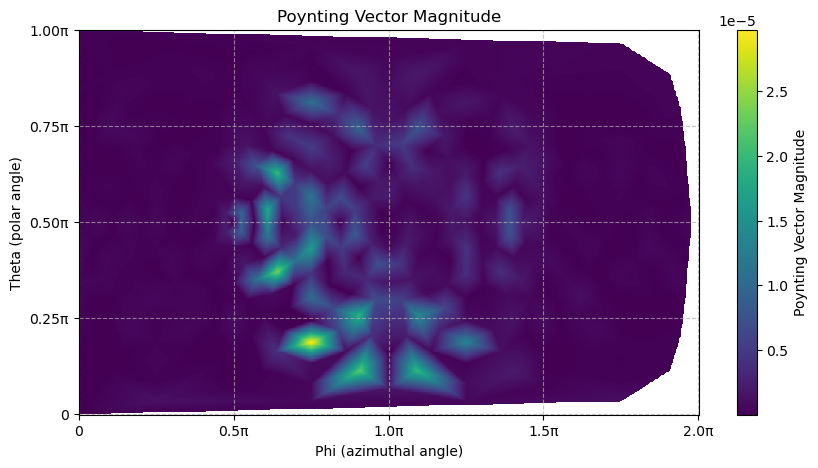

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import MultipleLocator, FuncFormatter

# Load the saved data
data = np.load('poynting_data_ord_35.npz')
theta = data['theta']
phi = data['phi']
poynting_magnitudes = data['poynting_radial']

# Create a grid for interpolation
phi_grid = np.linspace(0, 2*np.pi, 1000)
theta_grid = np.linspace(0, np.pi, 500)
PHI, THETA = np.meshgrid(phi_grid, theta_grid)

# Interpolate Poynting magnitudes onto the grid
points = np.vstack((phi, theta)).T
grid_values = griddata(points, poynting_magnitudes, (PHI, THETA), method='linear')

# Create 2D plot
fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.pcolormesh(PHI, THETA, grid_values, shading='auto', cmap='viridis')
ax.set_title('Poynting Vector Magnitude')
ax.set_xlabel('Phi (azimuthal angle)')
ax.set_ylabel('Theta (polar angle)')

# Format x-axis (phi) ticks as multiples of pi
ax.xaxis.set_major_locator(MultipleLocator(np.pi/2))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/np.pi:.1f}π' if x != 0 else '0'))

# Format y-axis (theta) ticks as multiples of pi
ax.yaxis.set_major_locator(MultipleLocator(np.pi/4))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/np.pi:.2f}π' if y != 0 else '0'))

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add a colorbar
fig.colorbar(cax, ax=ax, label='Poynting Vector Magnitude')

plt.show()

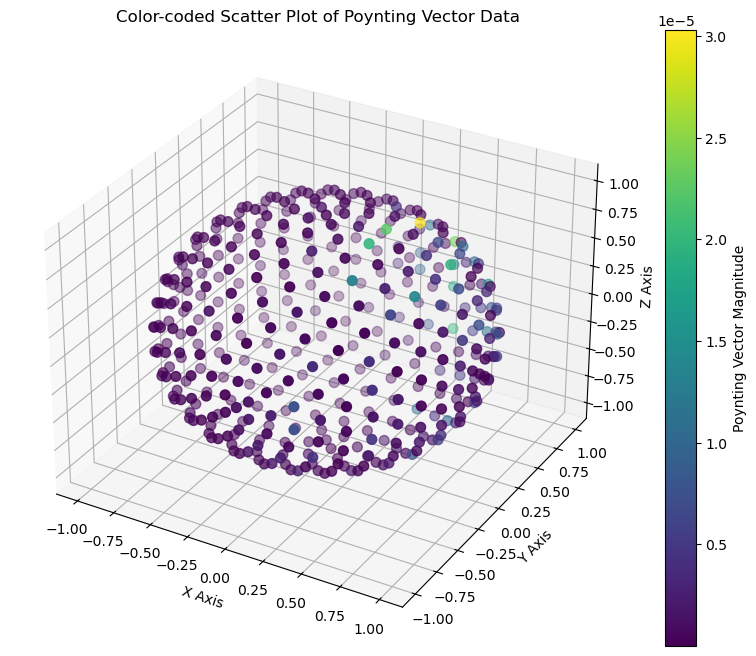

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data
data = np.load('poynting_data_ord_35.npz')
theta = data['theta']
phi = data['phi']
poynting_magnitudes = data['poynting_radial']

# Convert spherical to Cartesian coordinates
x = -np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=poynting_magnitudes, cmap='viridis', s=50)

# Customize the plot
ax.set_title('Color-coded Scatter Plot of Poynting Vector Data')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax, label='Poynting Vector Magnitude')

# Display the plot
plt.show()

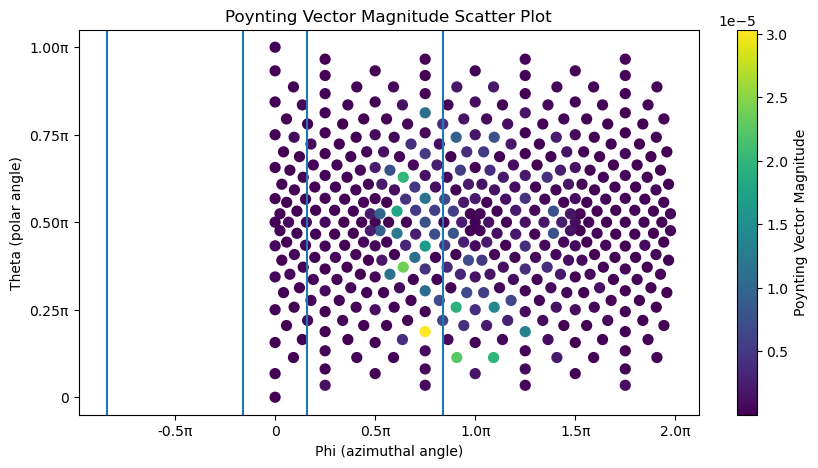

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
data = np.load('poynting_data_ord_35.npz')
theta = data['theta']
phi = data['phi']
poynting_magnitudes = data['poynting_radial']

# Create 2D scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(phi, theta, c=poynting_magnitudes, cmap='viridis', s=50)

# Customize the plot
ax.set_title('Poynting Vector Magnitude Scatter Plot')
ax.set_xlabel('Phi (azimuthal angle)')
ax.set_ylabel('Theta (polar angle)')

# Format x-axis (phi) ticks as multiples of pi
ax.xaxis.set_major_locator(MultipleLocator(np.pi/2))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/np.pi:.1f}π' if x != 0 else '0'))

# Format y-axis (theta) ticks as multiples of pi
ax.yaxis.set_major_locator(MultipleLocator(np.pi/4))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/np.pi:.2f}π' if y != 0 else '0'))
ax.axvline(psi)
ax.axvline(-psi)
ax.axvline(-np.pi + psi)
ax.axvline(np.pi - psi)
# Add a colorbar
fig.colorbar(scatter, ax=ax, label='Poynting Vector Magnitude')

plt.show()

In [9]:
print(4287.877275087185 / stride**2)

0.42878772750871846


In [13]:
print((grid_x-fin_x_boundary) / CC)
print(lst_time)

86843.59648937616
180000.0


In [ ]:
import numpy as np
from graphet import Data
from graphet.plugins import TristanV2
from tqdm import tqdm

class RadiationReactionCalculator:
    def __init__(self, out_dir, input_file_name, bounds_x, bounds_y, 
                 interval, omegap0, wA_wp, weight_fac, unit_ch, CC, stride):
        """
        Initialize the radiation reaction calculator
        
        Parameters:
        -----------
        out_dir : str
            Output directory path
        input_file_name : str  
            Configuration file name
        bounds_x, bounds_y : list
            Simulation domain boundaries
        interval : float
            Time interval between frames
        omegap0, wA_wp : float
            Plasma frequency parameters
        weight_fac, unit_ch : float
            Particle weight and unit charge
        CC : float
            Speed of light
        stride : int
            Stride factor for field calculation
        """
        self.out_dir = out_dir
        self.input_file_name = input_file_name
        self.bounds_x = bounds_x
        self.bounds_y = bounds_y
        self.interval = interval
        self.omegap0 = omegap0
        self.wA_wp = wA_wp
        self.weight_fac = weight_fac
        self.unit_ch = unit_ch
        self.CC = CC
        self.stride = stride
        self.metric = np.diag([-1, 1, 1, 1])  # Minkowski metric
        
    def get_test_particle(self, frame, species, particle_id=None, region=None):
        """
        Get test particle data at specified frame
        
        Parameters:
        -----------
        frame : int
            Frame number
        species : int
            Particle species (1 for positrons, 2 for electrons)
        particle_id : int, optional
            Specific particle ID to track
        region : dict, optional
            Region to randomly select from: {'x_range': [min,max], 'y_range': [min,max]}
        
        Returns:
        --------
        dict : Test particle data
        """
        d = Data(TristanV2, steps=[frame], path=self.out_dir, 
                cfg_fname=self.input_file_name, params=True)
        
        particles = d.particles[species].sel(t=frame)
        
        if particle_id is not None:
            # Find specific particle
            mask = particles.idx.values == particle_id
            if not np.any(mask):
                raise ValueError(f"Particle ID {particle_id} not found in frame {frame}")
            idx = np.where(mask)[0][0]
        elif region is not None:
            # Random particle in region
            x_mask = ((particles.x.values >= region['x_range'][0]) & 
                     (particles.x.values <= region['x_range'][1]))
            y_mask = ((particles.y.values >= region['y_range'][0]) & 
                     (particles.y.values <= region['y_range'][1]))
            region_mask = x_mask & y_mask
            
            if not np.any(region_mask):
                raise ValueError("No particles found in specified region")
            
            valid_indices = np.where(region_mask)[0]
            idx = np.random.choice(valid_indices)
        else:
            # Random particle from entire domain
            idx = np.random.randint(0, len(particles.idx.values))
        
        # Extract particle data
        test_particle = {
            'id': particles.idx.values[idx],
            'x': particles.x.values[idx],
            'y': particles.y.values[idx], 
            'z': particles.z.values[idx],
            'u': particles.u.values[idx],
            'v': particles.v.values[idx],
            'w': particles.w.values[idx],
            'species': species,
            'charge': self.unit_ch if species == 1 else -self.unit_ch
        }
        
        return test_particle
    
    def delta_s2(self, x4_1, x4_2):
        """Calculate spacetime interval squared using Minkowski metric"""
        x_diff = x4_1 - x4_2
        return np.einsum('ij,jk,ik->i', x_diff, self.metric, x_diff)

    def calculate_field_contribution_from_frame(self, test_particle, observation_frame, past_frame):
        """
        Calculate E and B field contribution from a single past frame
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data at observation frame
        observation_frame : int
            Frame when test particle is observed
        past_frame : int
            Past frame to calculate field contribution from
            
        Returns:
        --------
        tuple : (E_field_contribution, B_field_contribution) as 3D vectors
        """
        # Test particle 4-vector position at observation time
        test_pos_3d = np.array([test_particle['x'], test_particle['y'], test_particle['z']])
        x4_test = np.array([self.CC * observation_frame * self.interval, 
                           test_particle['x'], test_particle['y'], test_particle['z']])
        
        E_contribution = np.zeros(3)
        B_contribution = np.zeros(3)
        
        # Load particle data for this past frame and the next one
        try:
            d_curr = Data(TristanV2, steps=[past_frame], path=self.out_dir,
                         cfg_fname=self.input_file_name, params=True)
            d_next = Data(TristanV2, steps=[past_frame + 1], path=self.out_dir,
                         cfg_fname=self.input_file_name, params=True)
        except:
            return E_contribution, B_contribution  # Return zeros if data not available
        
        # Process both species
        for species in [1, 2]:
            particles_curr = d_curr.particles[species].sel(t=past_frame)
            particles_next = d_next.particles[species].sel(t=past_frame + 1)
            
            # Find common particle IDs
            current_ids = set(particles_curr.idx.values)
            next_ids = set(particles_next.idx.values)
            common_ids = list(current_ids.intersection(next_ids))
            
            if len(common_ids) == 0:
                continue
                
            # Remove test particle from calculation if in same species
            if test_particle['species'] == species:
                common_ids = [pid for pid in common_ids if pid != test_particle['id']]
            
            if len(common_ids) == 0:
                continue
            
            # Create index mappings
            curr_id_to_idx = {id_val: i for i, id_val in enumerate(particles_curr.idx.values)}
            next_id_to_idx = {id_val: i for i, id_val in enumerate(particles_next.idx.values)}
            
            curr_indices = np.array([curr_id_to_idx[idx] for idx in common_ids])
            next_indices = np.array([next_id_to_idx[idx] for idx in common_ids])
            
            # Construct 4-vector positions for light cone calculation
            curr_locs4 = np.column_stack((self.CC * past_frame * self.interval * np.ones_like(curr_indices),
                                         particles_curr.x.values[curr_indices],
                                         particles_curr.y.values[curr_indices],
                                         particles_curr.z.values[curr_indices]))
            
            next_locs4 = np.column_stack((self.CC * (past_frame + 1) * self.interval * np.ones_like(next_indices),
                                         particles_next.x.values[next_indices],
                                         particles_next.y.values[next_indices],
                                         particles_next.z.values[next_indices]))
            
            # Calculate spacetime intervals to test particle at observation time
            ds2_curr = self.delta_s2(curr_locs4, x4_test)
            ds2_next = self.delta_s2(next_locs4, x4_test)
            
            # Light cone intersection condition: ds2 changes sign between frames
            light_cone_mask = (ds2_curr * ds2_next) <= 0
            
            if not np.any(light_cone_mask):
                continue
            
            # Get indices of particles crossing light cone
            lc_indices = np.where(light_cone_mask)[0]
            lc_curr_indices = curr_indices[lc_indices]
            lc_next_indices = next_indices[lc_indices]
            
            # Get 3D positions of light cone particles
            lc_curr_pos = np.column_stack((particles_curr.x.values[lc_curr_indices],
                                         particles_curr.y.values[lc_curr_indices],
                                         particles_curr.z.values[lc_curr_indices]))
            lc_next_pos = np.column_stack((particles_next.x.values[lc_next_indices],
                                         particles_next.y.values[lc_next_indices],
                                         particles_next.z.values[lc_next_indices]))
            
            # Average positions and calculate distances
            lc_avg_pos = (lc_curr_pos + lc_next_pos) / 2
            lc_displacements = test_pos_3d - lc_avg_pos
            lc_distances = np.linalg.norm(lc_displacements, axis=1)
            
            # Calculate unit vectors from particles to test particle
            lc_unit_vectors = lc_displacements / lc_distances[:, np.newaxis]
            
            # Get 4-velocities of light cone particles
            lc_curr_4vel = np.column_stack((particles_curr.u.values[lc_curr_indices],
                                          particles_curr.v.values[lc_curr_indices],
                                          particles_curr.w.values[lc_curr_indices]))
            lc_next_4vel = np.column_stack((particles_next.u.values[lc_next_indices],
                                          particles_next.v.values[lc_next_indices],
                                          particles_next.w.values[lc_next_indices]))
            
            # Convert to beta (v/c)
            lc_curr_beta = lc_curr_4vel / np.sqrt(1 + np.linalg.norm(lc_curr_4vel, axis=1)**2)[:, np.newaxis]
            lc_next_beta = lc_next_4vel / np.sqrt(1 + np.linalg.norm(lc_next_4vel, axis=1)**2)[:, np.newaxis]
            lc_avg_beta = (lc_curr_beta + lc_next_beta) / 2
            lc_beta_dot = (lc_next_beta - lc_curr_beta) / (self.interval * self.omegap0 * self.wA_wp)
            
            # Calculate electric field contribution (Liénard-Wiechert fields)
            charge_sign = 1 if species == 1 else -1
            E_num = (charge_sign * self.weight_fac * self.unit_ch / (4*np.pi) / self.CC * 
                    np.cross(lc_unit_vectors, np.cross(lc_unit_vectors - lc_avg_beta, lc_beta_dot)))
            E_denom = ((1 - np.einsum('ij,ij->i', lc_unit_vectors, lc_avg_beta))**3 * lc_distances)
            
            # Avoid division by zero
            valid_mask = E_denom != 0
            if np.any(valid_mask):
                E_fields = np.zeros_like(E_num)
                E_fields[valid_mask] = E_num[valid_mask] / E_denom[valid_mask, np.newaxis]
                
                # Calculate magnetic field
                B_fields = np.cross(lc_unit_vectors, E_fields)
                
                # Sum contributions from this frame
                E_contribution += np.sum(E_fields, axis=0)
                B_contribution += np.sum(B_fields, axis=0)
        
        return E_contribution * self.stride, B_contribution * self.stride
    
    def calculate_radiation_reaction_force(self, test_particle, E_field, B_field):
        """
        Calculate radiation reaction force using Faraday tensor
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        E_field, B_field : array
            Electric and magnetic field vectors
            
        Returns:
        --------
        array : 4-force from radiation reaction
        """
        # Test particle 4-velocity
        u_4vel = np.array([test_particle['u'], test_particle['v'], test_particle['w']])
        gamma = np.sqrt(1 + np.linalg.norm(u_4vel)**2)
        u_mu = np.array([gamma, test_particle['u'], test_particle['v'], test_particle['w']])
        
        # Construct Faraday tensor F^μν
        F_tensor = np.zeros((4, 4))
        F_tensor[0, 1:4] = E_field
        F_tensor[1:4, 0] = -E_field
        F_tensor[1, 2] = B_field[2]
        F_tensor[2, 1] = -B_field[2]
        F_tensor[1, 3] = -B_field[1]
        F_tensor[3, 1] = B_field[1]
        F_tensor[2, 3] = B_field[0]
        F_tensor[3, 2] = -B_field[0]
        
        # Calculate F^μν u_ν
        F_dot_u = np.einsum('ij,j->i', F_tensor, u_mu)
        
        # Calculate (F_αβ u^β)^2
        F_dot_u_squared = np.einsum('i,ij,j', F_dot_u, self.metric, F_dot_u)
        
        # Radiation reaction 4-force: (2e²/3m²c³)[F^μν u_ν + (F_αβ u^β)² u^μ]
        e_squared = (test_particle['charge'])**2
        mass_squared = 1.0  # Normalized units
        prefactor = 2 * e_squared / (3 * mass_squared * self.CC**3)
        
        f_rad = prefactor * (F_dot_u + F_dot_u_squared * u_mu)
        
        return f_rad
    
    def calculate_lorentz_force(self, test_particle, E_field, B_field):
        """
        Calculate standard Lorentz force for comparison
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        E_field, B_field : array
            Electric and magnetic field vectors
            
        Returns:
        --------
        array : 4-force from Lorentz force
        """
        charge = test_particle['charge']
        u_3vel = np.array([test_particle['u'], test_particle['v'], test_particle['w']])
        gamma = np.sqrt(1 + np.linalg.norm(u_3vel)**2)
        
        # Lorentz force: q(E + v × B)
        v = u_3vel / gamma  # 3-velocity
        force_3d = charge * (E_field + np.cross(v, B_field))
        
        # Convert to 4-force
        f_lorentz = np.zeros(4)
        f_lorentz[0] = charge * np.dot(E_field, v)
        f_lorentz[1:4] = force_3d
        
        return f_lorentz
    
    def distance_analysis(self, test_particle, frame, max_frames_back, normalize=True):
        """
        Efficiently analyze how radiation reaction force varies with retarded time/distance
        Uses incremental field calculation to avoid repeated computations
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        frame : int
            Observation frame number
        max_frames_back : int
            Maximum number of past frames to include
        normalize : bool
            Whether to normalize by Lorentz force magnitude
            
        Returns:
        --------
        dict : Results containing forces vs retarded distance
        """
        frame_ranges = range(1, max_frames_back + 1)
        max_distances = np.array(frame_ranges) * self.interval * self.CC  # Convert frames to distance
        
        results = {
            'frames_back': list(frame_ranges),
            'max_distances': max_distances,
            'rad_reaction_magnitudes': [],
            'lorentz_magnitudes': [],
            'normalized_ratios': []
        }
        
        # Initialize cumulative fields
        E_total = np.zeros(3)
        B_total = np.zeros(3)
        
        for frames_back in tqdm(frame_ranges, desc="Incremental retarded time analysis"):
            # Calculate the NEW contribution from the most distant frame
            past_frame = frame - frames_back
            
            if past_frame >= 0:  # Only if frame exists
                E_new, B_new = self.calculate_field_contribution_from_frame(
                    test_particle, frame, past_frame)
                
                # Add to cumulative total
                E_total += E_new
                B_total += B_new
            
            # Calculate forces using current cumulative fields
            f_rad = self.calculate_radiation_reaction_force(test_particle, E_total, B_total)
            f_lorentz = self.calculate_lorentz_force(test_particle, E_total, B_total)
            
            # Calculate magnitudes
            rad_mag = np.linalg.norm(f_rad[1:4])  # Spatial components only
            lorentz_mag = np.linalg.norm(f_lorentz[1:4])
            
            results['rad_reaction_magnitudes'].append(rad_mag)
            results['lorentz_magnitudes'].append(lorentz_mag)
            
            # Normalized ratio
            if normalize and lorentz_mag > 0:
                results['normalized_ratios'].append(rad_mag / lorentz_mag)
            else:
                results['normalized_ratios'].append(rad_mag)
        
        return results

# Example usage function
def run_radiation_reaction_analysis(out_dir, input_file_name, bounds_x, bounds_y,
                                   interval, omegap0, wA_wp, weight_fac, unit_ch, 
                                   CC, stride, frame, species=2, max_frames_back=20):
    """
    Run complete radiation reaction analysis with proper retarded time
    
    Parameters:
    -----------
    All simulation parameters as in original code
    frame : int
        Observation frame to analyze
    species : int  
        Particle species (1=positron, 2=electron)
    max_frames_back : int
        Maximum number of past frames to include (controls max retarded distance)
    """
    
    # Initialize calculator
    calc = RadiationReactionCalculator(
        out_dir, input_file_name, bounds_x, bounds_y,
        interval, omegap0, wA_wp, weight_fac, unit_ch, CC, stride
    )
    
    # Get random test particle
    test_particle = calc.get_test_particle(frame, species, region = {'x_range':bounds_x, 'y_range':bounds_y})
    print(f"Selected test particle: ID={test_particle['id']}, "
          f"pos=({test_particle['x']:.2f}, {test_particle['y']:.2f}, {test_particle['z']:.2f})")
    
    # Run retarded time analysis
    results = calc.distance_analysis(test_particle, frame, max_frames_back)
    
    print(f"Analysis complete. Max retarded distance: {results['max_distances'][-1]:.2f}")
    
    return results, test_particle

In [8]:
from multiprocessing.dummy import Pool as ThreadPool
from functools import partial
import numpy as np
from graphet import Data
from graphet.plugins import TristanV2
from tqdm import tqdm
import time
import pickle

# # --- Helper function for multiprocessing ---
# def _field_contribution_worker(args):
#     """
#     Worker function for parallel field calculation.

#     Args:
#         args: tuple (calc_params, test_particle, obs_frame, past_frame)

#     Returns:
#         tuple: (E_field_contribution, B_field_contribution)
        
#     """
#     calc_params, test_particle, obs_frame, past_frame = args
#     print(f"Worker started for frame {past_frame}")
#     calc = RadiationReactionCalculator(**calc_params)

#     t0 = time.time()
#     E, B = calc.calculate_field_contribution_from_frame(test_particle, obs_frame, past_frame)
#     print(f"Worker finished frame {past_frame} in {time.time() - t0:.1f}s")

#     return E, B


class RadiationReactionCalculator:
    def __init__(self, out_dir, input_file_name, bounds_x, bounds_y, 
                 interval, omegap0, wA_wp, weight_fac, unit_ch, CC, stride):
        """
        Initialize the radiation reaction calculator
        
        Parameters:
        -----------
        out_dir : str
            Output directory path
        input_file_name : str  
            Configuration file name
        bounds_x, bounds_y : list
            Simulation domain boundaries
        interval : float
            Time interval between frames
        omegap0, wA_wp : float
            Plasma frequency parameters
        weight_fac, unit_ch : float
            Particle weight and unit charge
        CC : float
            Speed of light
        stride : int
            Stride factor for field calculation
        """
        self.out_dir = out_dir
        self.input_file_name = input_file_name
        self.bounds_x = bounds_x
        self.bounds_y = bounds_y
        self.interval = interval
        self.omegap0 = omegap0
        self.wA_wp = wA_wp
        self.weight_fac = weight_fac
        self.unit_ch = unit_ch
        self.CC = CC
        self.stride = stride
        self.metric = np.diag([-1, 1, 1, 1])  # Minkowski metric
        
    def get_test_particle(self, frame, species, particle_id=None, region=None):
        """
        Get test particle data at specified frame
        
        Parameters:
        -----------
        frame : int
            Frame number
        species : int
            Particle species (1 for positrons, 2 for electrons)
        particle_id : int, optional
            Specific particle ID to track
        region : dict, optional
            Region to randomly select from: {'x_range': [min,max], 'y_range': [min,max]}
        
        Returns:
        --------
        dict : Test particle data
        """
        d = Data(TristanV2, steps=[frame], path=self.out_dir, 
                cfg_fname=self.input_file_name, params=True)
        
        particles = d.particles[species].sel(t=frame)
        
        if particle_id is not None:
            # Find specific particle
            mask = particles.idx.values == particle_id
            if not np.any(mask):
                raise ValueError(f"Particle ID {particle_id} not found in frame {frame}")
            idx = np.where(mask)[0][0]
        elif region is not None:
            # Random particle in region
            x_mask = ((particles.x.values >= region['x_range'][0]) & 
                     (particles.x.values <= region['x_range'][1]))
            y_mask = ((particles.y.values >= region['y_range'][0]) & 
                     (particles.y.values <= region['y_range'][1]))
            region_mask = x_mask & y_mask
            
            if not np.any(region_mask):
                raise ValueError("No particles found in specified region")
            
            valid_indices = np.where(region_mask)[0]
            print(particles.x.values[valid_indices])
            print(particles.y.values[valid_indices])
            print(particles.idx.values[valid_indices])
            print(valid_indices)
            idx = valid_indices[1] #7400000000273 #np.random.choice(valid_indices)
        else:
            # Random particle from entire domain
            idx = np.random.randint(0, len(particles.idx.values))
        
        # Extract particle data
        test_particle = {
            'id': particles.idx.values[idx],
            'x': particles.x.values[idx],
            'y': particles.y.values[idx], 
            'z': particles.z.values[idx],
            'u': particles.u.values[idx],
            'v': particles.v.values[idx],
            'w': particles.w.values[idx],
            'species': species,
            'mass': 1 * self.weight_fac,
            'charge': self.unit_ch * self.weight_fac if species == 1 else -self.unit_ch * self.weight_fac
        }
        
        return test_particle
    
    def delta_s2(self, x4_1, x4_2):
        """Calculate spacetime interval squared using Minkowski metric"""
        x_diff = x4_1 - x4_2
        return np.einsum('ij,jk,ik->i', x_diff, self.metric, x_diff)

    def calculate_field_contribution_from_frame(self, test_particle, observation_frame, past_frame):
        """
        Calculate E and B field contribution from a single past frame
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data at observation frame
        observation_frame : int
            Frame when test particle is observed
        past_frame : int
            Past frame to calculate field contribution from
            
        Returns:
        --------
        tuple : (E_field_contribution, B_field_contribution) as 3D vectors
        """
        
        # Test particle 4-vector position at observation time
        test_pos_3d = np.array([test_particle['x'], test_particle['y'], test_particle['z']])
        x4_test = np.array([self.CC * observation_frame * self.interval, 
                           test_particle['x'], test_particle['y'], test_particle['z']])
        
        E_contribution = np.zeros(3)
        B_contribution = np.zeros(3)
        
        # Load particle data for this past frame and the next one
        try:
#             print("Field calculation...inside try")
            d_curr = Data(TristanV2, steps=[past_frame], path=self.out_dir,
                         cfg_fname=self.input_file_name, params=True)
            d_next = Data(TristanV2, steps=[past_frame + 1], path=self.out_dir,
                         cfg_fname=self.input_file_name, params=True)
#             print("Data loaded!")
        except:
            return E_contribution, B_contribution  # Return zeros if data not available
            print("Loading failed :( ")
        
        # Process both species
        for species in [1, 2]:
            particles_curr = d_curr.particles[species].sel(t=past_frame)
            particles_next = d_next.particles[species].sel(t=past_frame + 1)
            
            # Find common particle IDs
            current_ids = set(particles_curr.idx.values)
            next_ids = set(particles_next.idx.values)
            common_ids = list(current_ids.intersection(next_ids))
            
            if len(common_ids) == 0:
                continue
                
            # # Remove test particle from calculation if in same species
            # if test_particle['species'] == species:
            #     common_ids = [pid for pid in common_ids if pid != test_particle['id']]
            
            if len(common_ids) == 0:
                continue
            
            # Create index mappings
            curr_id_to_idx = {id_val: i for i, id_val in enumerate(particles_curr.idx.values)}
            next_id_to_idx = {id_val: i for i, id_val in enumerate(particles_next.idx.values)}
            
            curr_indices = np.array([curr_id_to_idx[idx] for idx in common_ids])
            next_indices = np.array([next_id_to_idx[idx] for idx in common_ids])
            
            # Construct 4-vector positions for light cone calculation
            curr_locs4 = np.column_stack((self.CC * past_frame * self.interval * np.ones_like(curr_indices),
                                         particles_curr.x.values[curr_indices],
                                         particles_curr.y.values[curr_indices],
                                         particles_curr.z.values[curr_indices]))
            
            next_locs4 = np.column_stack((self.CC * (past_frame + 1) * self.interval * np.ones_like(next_indices),
                                         particles_next.x.values[next_indices],
                                         particles_next.y.values[next_indices],
                                         particles_next.z.values[next_indices]))
            
            # Calculate spacetime intervals to test particle at observation time
            ds2_curr = self.delta_s2(curr_locs4, x4_test)
            ds2_next = self.delta_s2(next_locs4, x4_test)
            
            # Light cone intersection condition: ds2 changes sign between frames
            light_cone_mask = (ds2_curr * ds2_next) <= 0
            
            if not np.any(light_cone_mask):
                continue
            
            # Get indices of particles crossing light cone
            lc_indices = np.where(light_cone_mask)[0]
            lc_curr_indices = curr_indices[lc_indices]
            lc_next_indices = next_indices[lc_indices]
            
            # Get 3D positions of light cone particles
            lc_curr_pos = np.column_stack((particles_curr.x.values[lc_curr_indices],
                                         particles_curr.y.values[lc_curr_indices],
                                         particles_curr.z.values[lc_curr_indices]))
            lc_next_pos = np.column_stack((particles_next.x.values[lc_next_indices],
                                         particles_next.y.values[lc_next_indices],
                                         particles_next.z.values[lc_next_indices]))
            
            # Average positions and calculate distances
            lc_avg_pos = (lc_curr_pos + lc_next_pos) / 2
            lc_displacements = test_pos_3d - lc_avg_pos
            lc_distances = np.linalg.norm(lc_displacements, axis=1)
            
            # Calculate unit vectors from particles to test particle
            lc_unit_vectors = lc_displacements / lc_distances[:, np.newaxis]
            
            # Get 4-velocities of light cone particles
            lc_curr_4vel = np.column_stack((particles_curr.u.values[lc_curr_indices],
                                          particles_curr.v.values[lc_curr_indices],
                                          particles_curr.w.values[lc_curr_indices]))
            lc_next_4vel = np.column_stack((particles_next.u.values[lc_next_indices],
                                          particles_next.v.values[lc_next_indices],
                                          particles_next.w.values[lc_next_indices]))
            
            # Convert to beta (v/c)
            lc_curr_beta = lc_curr_4vel / np.sqrt(1 + np.linalg.norm(lc_curr_4vel, axis=1)**2)[:, np.newaxis]
            lc_next_beta = lc_next_4vel / np.sqrt(1 + np.linalg.norm(lc_next_4vel, axis=1)**2)[:, np.newaxis]
            lc_avg_beta = (lc_curr_beta + lc_next_beta) / 2
            lc_avg_gamma = 1 / np.sqrt(1 - np.linalg.norm(lc_avg_beta, axis = 1)**2)
            lc_beta_dot = (lc_next_beta - lc_curr_beta) / self.interval
            
            # Calculate electric field contribution (Liénard-Wiechert fields)
            charge_sign = 1 if species == 1 else -1
            E_acc_num = (charge_sign * self.weight_fac * self.unit_ch / self.CC * 
                    np.cross(lc_unit_vectors, np.cross(lc_unit_vectors - lc_avg_beta, lc_beta_dot)))
            E_acc_denom = ((1 - np.einsum('ij,ij->i', lc_unit_vectors, lc_avg_beta))**3 * lc_distances)
            
            E_vel_num = charge_sign * self.weight_fac * self.unit_ch * (lc_unit_vectors - lc_avg_beta)
            E_vel_denom = E_acc_denom * lc_distances * lc_avg_gamma**2 

            # Avoid division by zero
            valid_mask = (E_acc_denom != 0) & (E_vel_denom != 0)
            if np.any(valid_mask):
                E_fields = np.zeros_like(E_acc_num)
                E_fields[valid_mask] = E_acc_num[valid_mask] / E_acc_denom[valid_mask, np.newaxis] + E_vel_num[valid_mask] / E_vel_denom[valid_mask, np.newaxis]
                
                # Calculate magnetic field
                B_fields = np.cross(lc_unit_vectors, E_fields)
                
                # Sum contributions from this frame
                E_contribution += np.sum(E_fields, axis=0)
                B_contribution += np.sum(B_fields, axis=0)
        
        return E_contribution * self.stride, B_contribution * self.stride
    
    def calculate_forces(self, test_particle, E_field, B_field):
        """
        Calculate radiation reaction force using Faraday tensor
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        E_field, B_field : array
            Electric and magnetic field vectors
            
        Returns:
        --------
        array : 4-force from radiation reaction
        """
        # Test particle 4-velocity
        u_4vel = np.array([test_particle['u'], test_particle['v'], test_particle['w']])
        gamma = np.sqrt(1 + np.linalg.norm(u_4vel)**2)
        u_mu = np.array([gamma, test_particle['u'], test_particle['v'], test_particle['w']]) # u^\mu
        
        # Construct Faraday tensor F_μν
        F_tensor = np.zeros((4, 4))
        F_tensor[0, 1:4] = E_field
        F_tensor[1:4, 0] = -E_field
        F_tensor[1, 2] = B_field[2]
        F_tensor[2, 1] = -B_field[2]
        F_tensor[1, 3] = -B_field[1]
        F_tensor[3, 1] = B_field[1]
        F_tensor[2, 3] = B_field[0]
        F_tensor[3, 2] = -B_field[0]

        F_contra_tensor = np.einsum('ij,jk,kl->il', self.metric, F_tensor, self.metric)
        
        # Calculate F_μν u^ν
        F_dot_u = np.einsum('ij,j->i', F_tensor, u_mu)
        
        # Calculate (F_αβ u^β)^2
        F_dot_u_squared = np.einsum('i,ij,j', F_dot_u, self.metric, F_dot_u)

        # Calculate F^αβ F_βν u^ν
        F_dot_F_dot_u = np.einsum('ij,j->i', F_contra_tensor, F_dot_u)
        
        # Radiation reaction 4-force: (2e^4/3m^2)[F^αβ F_βν u^ν + (F_μν u^ν)² u^α]        
        mass_squared = test_particle['mass']**2  # Normalized units
        prefactor = 2 * (test_particle['charge'])**4 / (3 * mass_squared)
        
        f_rad = prefactor * (F_dot_F_dot_u + F_dot_u_squared * u_mu)

        f_lorentz = test_particle['charge'] * np.einsum('ij,j->i', self.metric, F_dot_u)
        
        return f_rad, f_lorentz
    
    
    
    def distance_analysis(self, test_particle, frame, max_frames_back, normalize=True):
        """
        Efficiently analyze how radiation reaction force varies with retarded time/distance
        Uses incremental field calculation to avoid repeated computations
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        frame : int
            Observation frame number
        max_frames_back : int
            Maximum number of past frames to include
        normalize : bool
            Whether to normalize by Lorentz force magnitude
            
        Returns:
        --------
        dict : Results containing forces vs retarded distance
        """
        frame_ranges = range(1, max_frames_back + 1)
        max_distances = np.array(frame_ranges) * self.interval * self.CC  # Convert frames to distance
        
        results = {
            'test_particle': test_particle,
            'frames_back': list(frame_ranges),
            'max_distances': max_distances,
            'f_rad': [],
            'f_lorentz': []            
        }
        
        # Initialize cumulative fields
        E_total = np.zeros(3)
        B_total = np.zeros(3)
        
        for frames_back in tqdm(frame_ranges, desc="Incremental retarded time analysis"):
            # Calculate the NEW contribution from the most distant frame
            past_frame = frame - frames_back
            
            if past_frame >= 0:  # Only if frame existsfrom multiprocessing.dummy import Pool as ThreadPool
                E_new, B_new = self.calculate_field_contribution_from_frame(
                    test_particle, frame, past_frame)
                
                # Add to cumulative total
                E_total += E_new
                B_total += B_new
            
            # Calculate forces using current cumulative fields
            f_rad, f_lorentz = self.calculate_forces(test_particle, E_total, B_total)            
            results['f_rad'] = f_rad
            results['f_lorentz'] = f_lorentz            
            
#             # Normalized ratio
#             if normalize and lorentz_mag > 0:
#                 results['normalized_ratios'].append(rad_mag / lorentz_mag)
#             else:
#                 results['normalized_ratios'].append(rad_mag)        
        
        return results
    


    # Inside RadiationReactionCalculator class
    def distance_analysis2(self, test_particle, frame, max_frames_back, normalize=True, num_processes=None):
        """
        Efficiently analyze how radiation reaction force varies with retarded time/distance
        Uses incremental field calculation to avoid repeated computations
        
        Parameters:
        -----------
        test_particle : dict
            Test particle data
        frame : int
            Observation frame number
        max_frames_back : int
            Maximum number of past frames to include
        normalize : bool
            Whether to normalize by Lorentz force magnitude
        num_processes : int
            Number of processes for multiprocessing E and B calulcation across frames            
        Returns:
        --------
        dict : Results containing forces vs retarded distance
        """
        if num_processes is None:
            num_processes = multiprocessing.cpu_count() - 1  # Leave one core free

        frame_ranges = range(1, max_frames_back + 1)
        max_distances = np.array(frame_ranges) * self.interval * self.CC

        results = {
            'test_particle': test_particle,
            'frames_back': list(frame_ranges),
            'max_distances': max_distances,
            'f_rad': [],
            'f_lorentz': []            
        }
        

        # List of past frames, ordered from most recent (frame-1) to oldest (frame-max_frames_back)
        past_frames = [frame - i for i in frame_ranges if frame - i >= 0]

        if not past_frames:
            return results

        # Partial function for parallel mapping (fixes test_particle and frame)
        calc_func = partial(self.calculate_field_contribution_from_frame, test_particle, frame)

        # Parallel computation of contributions
        with multiprocessing.Pool(processes=num_processes) as pool:
            # Use imap for ordered results; tqdm for progress
            contribs = list(tqdm(pool.imap(calc_func, past_frames), total=len(past_frames), desc="Parallel field contributions"))

        # Now serially accumulate and compute forces (fast)
        E_total = np.zeros(3)
        B_total = np.zeros(3)

        for E_new, B_new in contribs:
            E_total += E_new
            B_total += B_new

            f_rad, f_lorentz = self.calculate_forces(test_particle, E_total, B_total)
            
            results['f_rad'] = f_rad
            results['f_lorentz'] = f_lorentz            
            
#             rad_mag = np.linalg.norm(f_rad[1:4])
#             lorentz_mag = np.linalg.norm(f_lorentz[1:4])

#             results['rad_reaction_magnitudes'].append(rad_mag)
#             results['lorentz_magnitudes'].append(lorentz_mag)

#             if normalize and lorentz_mag > 0:
#                 results['normalized_ratios'].append(rad_mag / lorentz_mag)
#             else:
#                 results['normalized_ratios'].append(rad_mag)

        return results
    def distance_analysis3(self, test_particle, frame, max_frames_back, normalize=True, num_processes=None):
        """
        Parallelized version of distance_analysis.

        Uses multiprocessing to compute field contributions from past frames
        in parallel. Each process constructs its own RadiationReactionCalculator
        to avoid pickling large state.

        Parameters
        ----------
        test_particle : dict
            Test particle data.
        frame : int
            Observation frame number.
        max_frames_back : int
            Maximum number of past frames to include.
        normalize : bool
            Whether to normalize forces (unused, kept for API consistency).
        num_processes : int
            Number of processes (defaults to CPU count - 1).

        Returns
        -------
        dict
            Results containing forces vs. retarded distance.
        """
        if num_processes is None:
            num_processes = max(1, multiprocessing.cpu_count() - 1)

        frame_ranges = range(1, max_frames_back + 1)
        max_distances = np.array(frame_ranges) * self.interval * self.CC

        results = {
            "test_particle": test_particle,
            "frames_back": list(frame_ranges),
            "max_distances": max_distances,
            "f_rad": [],
            "f_lorentz": [],
        }

        # Prepare arguments for workers
        past_frames = [frame - i for i in frame_ranges if frame - i >= 0]
        if not past_frames:
            return results

        calc_params = {
            "out_dir": self.out_dir,
            "input_file_name": self.input_file_name,
            "bounds_x": self.bounds_x,
            "bounds_y": self.bounds_y,
            "interval": self.interval,
            "omegap0": self.omegap0,
            "wA_wp": self.wA_wp,
            "weight_fac": self.weight_fac,
            "unit_ch": self.unit_ch,
            "CC": self.CC,
            "stride": self.stride,
        }

        # Build argument list for all past frames
        args = [(calc_params, test_particle, frame, pf) for pf in past_frames]

        # --- Parallel computation ---
        print(f"Running threaded field contributions on {num_processes} workers...")
        with ThreadPool(num_processes) as pool:
            contribs = list(
                tqdm(pool.imap(_field_contribution_worker, args),
                     total=len(args),
                     desc="Parallel field contributions (threads)")
            )

        # --- Sequential accumulation and force computation ---
        E_total = np.zeros(3)
        B_total = np.zeros(3)

        for E_new, B_new in contribs:
            E_total += E_new
            B_total += B_new

            f_rad, f_lorentz = self.calculate_forces(test_particle, E_total, B_total)

            results["f_rad"].append(f_rad)
            results["f_lorentz"].append(f_lorentz)

        return results

# Example usage function
def run_radiation_reaction_analysis(out_dir, input_file_name, bounds_x, bounds_y,
                                   interval, omegap0, wA_wp, weight_fac, unit_ch, 
                                   CC, stride, frame, species=2, max_frames_back=20):
    """
    Run complete radiation reaction analysis with proper retarded time
    
    Parameters:
    -----------
    All simulation parameters as in original code
    frame : int
        Observation frame to analyze
    species : int  
        Particle species (1=positron, 2=electron)
    max_frames_back : int
        Maximum number of past frames to include (controls max retarded distance)
    """
    
    # Initialize calculator
    calc = RadiationReactionCalculator(
        out_dir, input_file_name, bounds_x, bounds_y,
        interval, omegap0, wA_wp, weight_fac, unit_ch, CC, stride
    )
    
    # Get random test particle
    test_particle = calc.get_test_particle(frame, species, region = {'x_range':bounds_x, 'y_range':bounds_y})
    print(f"Selected test particle: ID={test_particle['id']}, "
          f"pos=({test_particle['x']:.2f}, {test_particle['y']:.2f}, {test_particle['z']:.2f})")
    results = []
    # Run retarded time analysis
#     results = calc.distance_analysis(test_particle, frame, max_frames_back)
#     results = calc.distance_analysis(test_particle, frame, max_frames_back)
#     with open('rad_rxn_output.pkl', 'wb') as f:
#         pickle.dump(results, f)
#         f.close()

#     print(f"Analysis complete. Max retarded distance: {results['max_distances'][-1]:.2f}")
    
    return results, test_particle




if __name__ == "__main__":
    
    out_dir = "/scratch/10446/anindya_12/tristan_mp_v2/vault/output_psi0.5_mul1_3_mul2_0.1_TT_1.9e-4_rad_drag/"
    input_file_name = out_dir + "temp_input_psi0.5_mul13_mul20.1_TT1.9e-4.in"
    
    # Parse input parameters to extract values
    import tristanVis.isolde as isolde
    input_params = isolde.parseInput(input_file_name)
    
    interval = input_params["output"]["interval"]
    lst_time = input_params["time"]["last"]
    grid_x = int(input_params["grid"]["mx0"])
    grid_y = int(input_params["grid"]["my0"])
    CC = input_params["algorithm"]["c"]
    COMP = input_params["plasma"]["c_omp"]
    ppc0 = input_params["plasma"]["ppc0"]
    stride = input_params["output"]["stride"]
    wA_wp = input_params["problem"]["wA_wp"]
    mode = input_params["problem"]["mode"]
    ramp_width = input_params["problem"]["ramp_width"]
    
    # Derived parameters
    unit_ch = CC**2 / (ppc0 * COMP**2)
    weight_fac = 2.0473518E-03  # From your notebook
    ds = wA_wp * 2 * np.pi / mode
    omegap0 = CC / ds
    init_x_boundary = int(5 * np.pi / mode) + 1
    fin_x_boundary = init_x_boundary + ramp_width * (2 * np.pi / mode)
    
    # Set analysis parameters (modify these as needed)
    bounds_x = [10220, 10250]  # e.g., [init_x_boundary, fin_x_boundary]
    bounds_y = [1040, 1070]  # e.g., [0, grid_y]
    frame = 2400  # e.g., 100 or int(lst_time // interval) // 2
    species = 2  # 1 for positrons, 2 for electrons
    max_frames_back = 150  # Maximum retarded time frames
    
#     print(f"Grid size: {grid_x} x {grid_y}")
#     print(f"Boundaries calculated: x=[{init_x_boundary}, {fin_x_boundary}]")
   
    
    results, test_particle = run_radiation_reaction_analysis(
        out_dir=out_dir,
        input_file_name=input_file_name, 
        bounds_x=bounds_x,
        bounds_y=bounds_y,
        interval=interval,
        omegap0=omegap0,
        wA_wp=wA_wp,
        weight_fac=weight_fac,
        unit_ch=unit_ch,
        CC=CC,
        stride=stride,
        frame=frame,
        species=species,
        max_frames_back=max_frames_back
    )



[10226.325  10248.324  10240.106  10222.374  10228.311  10226.303
 10228.808  10230.199  10225.0205 10225.309 ]
[1041.9053 1047.6799 1059.8616 1050.6611 1048.8605 1063.3688 1061.7341
 1060.99   1057.9078 1054.3301]
[ 6800000000273  7400000000273 10180000000273 12900000000273
  5260000000273  6700000000273  9940000000273 14260000000273
 13080000000273  1940000000193]
[1060720 1060751 1060753 1060763 1060774 1060783 1060796 1060814 1060822
 1060833]
Selected test particle: ID=7400000000273, pos=(10248.32, 1047.68, 0.50)


Incremental retarded time analysis:   0%|          | 0/150 [00:00<?, ?it/s]

Incremental retarded time analysis:   1%|          | 1/150 [00:12<32:16, 13.00s/it]

Incremental retarded time analysis:   1%|▏         | 2/150 [00:25<31:36, 12.82s/it]

Incremental retarded time analysis:   2%|▏         | 3/150 [00:38<31:17, 12.77s/it]

Incremental retarded time analysis:   3%|▎         | 4/150 [00:51<31:17, 12.86s/it]

Incremental retarded time analysis:   3%|▎         | 5/150 [01:04<31:11, 12.91s/it]

Incremental retarded time analysis:   4%|▍         | 6/150 [01:17<31:11, 13.00s/it]

Incremental retarded time analysis:   5%|▍         | 7/150 [01:30<30:55, 12.98s/it]

Incremental retarded time analysis:   5%|▌         | 8/150 [01:43<30:45, 13.00s/it]

Incremental retarded time analysis:   6%|▌         | 9/150 [01:56<30:40, 13.05s/it]

Incremental retarded time analysis:   7%|▋         | 10/150 [02:11<31:22, 13.45s/it]

Incremental retarded time analysis:   7%|▋         | 11/150 [02:24<30:59, 13.38s/it]

Incremental retarded time analysis:   8%|▊         | 12/150 [02:37<30:35, 13.30s/it]

Incremental retarded time analysis:   9%|▊         | 13/150 [02:50<30:19, 13.28s/it]

Incremental retarded time analysis:   9%|▉         | 14/150 [03:03<30:03, 13.26s/it]

Incremental retarded time analysis:  10%|█         | 15/150 [03:17<29:52, 13.28s/it]

Incremental retarded time analysis:  11%|█         | 16/150 [03:30<29:38, 13.27s/it]

Incremental retarded time analysis:  11%|█▏        | 17/150 [03:43<29:26, 13.28s/it]

Incremental retarded time analysis:  12%|█▏        | 18/150 [03:56<29:08, 13.25s/it]

Incremental retarded time analysis:  13%|█▎        | 19/150 [04:10<28:56, 13.25s/it]

Incremental retarded time analysis:  13%|█▎        | 20/150 [04:23<28:40, 13.24s/it]

Incremental retarded time analysis:  14%|█▍        | 21/150 [04:36<28:42, 13.35s/it]

Incremental retarded time analysis:  15%|█▍        | 22/150 [04:50<28:26, 13.33s/it]

Incremental retarded time analysis:  15%|█▌        | 23/150 [05:03<28:08, 13.29s/it]

Incremental retarded time analysis:  16%|█▌        | 24/150 [05:17<28:05, 13.38s/it]

Incremental retarded time analysis:  17%|█▋        | 25/150 [05:30<27:49, 13.35s/it]

Incremental retarded time analysis:  17%|█▋        | 26/150 [05:43<27:34, 13.34s/it]

Incremental retarded time analysis:  18%|█▊        | 27/150 [05:57<27:25, 13.38s/it]

Incremental retarded time analysis:  19%|█▊        | 28/150 [06:10<27:16, 13.42s/it]

Incremental retarded time analysis:  19%|█▉        | 29/150 [06:24<27:06, 13.44s/it]

Incremental retarded time analysis:  20%|██        | 30/150 [06:37<26:50, 13.42s/it]

Incremental retarded time analysis:  21%|██        | 31/150 [06:50<26:24, 13.31s/it]

Incremental retarded time analysis:  21%|██▏       | 32/150 [07:03<26:07, 13.28s/it]

Incremental retarded time analysis:  22%|██▏       | 33/150 [07:16<25:47, 13.22s/it]

Incremental retarded time analysis:  23%|██▎       | 34/150 [07:30<25:37, 13.25s/it]

Incremental retarded time analysis:  23%|██▎       | 35/150 [07:43<25:33, 13.33s/it]

Incremental retarded time analysis:  24%|██▍       | 36/150 [07:57<25:27, 13.40s/it]

Incremental retarded time analysis:  25%|██▍       | 37/150 [08:10<25:02, 13.30s/it]

Incremental retarded time analysis:  25%|██▌       | 38/150 [08:23<24:46, 13.27s/it]

Incremental retarded time analysis:  26%|██▌       | 39/150 [08:38<25:45, 13.92s/it]

Incremental retarded time analysis:  27%|██▋       | 40/150 [08:52<25:28, 13.90s/it]

Incremental retarded time analysis:  27%|██▋       | 41/150 [09:06<25:08, 13.84s/it]

Incremental retarded time analysis:  28%|██▊       | 42/150 [09:19<24:35, 13.66s/it]

Incremental retarded time analysis:  29%|██▊       | 43/150 [09:32<24:04, 13.50s/it]

Incremental retarded time analysis:  29%|██▉       | 44/150 [09:46<23:52, 13.51s/it]

Incremental retarded time analysis:  30%|███       | 45/150 [09:59<23:36, 13.49s/it]

Incremental retarded time analysis:  31%|███       | 46/150 [10:13<23:28, 13.55s/it]

Incremental retarded time analysis:  31%|███▏      | 47/150 [10:26<22:57, 13.38s/it]

Incremental retarded time analysis:  32%|███▏      | 48/150 [10:39<22:35, 13.29s/it]

Incremental retarded time analysis:  33%|███▎      | 49/150 [10:52<22:18, 13.25s/it]

Incremental retarded time analysis:  33%|███▎      | 50/150 [11:06<22:07, 13.28s/it]

Incremental retarded time analysis:  34%|███▍      | 51/150 [11:19<22:08, 13.42s/it]

Incremental retarded time analysis:  35%|███▍      | 52/150 [11:32<21:46, 13.33s/it]

Incremental retarded time analysis:  35%|███▌      | 53/150 [11:46<21:30, 13.31s/it]

Incremental retarded time analysis:  36%|███▌      | 54/150 [12:00<21:49, 13.65s/it]

Incremental retarded time analysis:  37%|███▋      | 55/150 [12:13<21:19, 13.47s/it]

Incremental retarded time analysis:  37%|███▋      | 56/150 [12:27<21:01, 13.42s/it]

Incremental retarded time analysis:  38%|███▊      | 57/150 [12:40<20:37, 13.30s/it]

Incremental retarded time analysis:  39%|███▊      | 58/150 [12:53<20:16, 13.22s/it]

Incremental retarded time analysis:  39%|███▉      | 59/150 [13:06<20:07, 13.27s/it]

Incremental retarded time analysis:  40%|████      | 60/150 [13:19<19:53, 13.27s/it]

Incremental retarded time analysis:  41%|████      | 61/150 [13:32<19:41, 13.27s/it]

Incremental retarded time analysis:  41%|████▏     | 62/150 [13:46<19:28, 13.28s/it]

Incremental retarded time analysis:  42%|████▏     | 63/150 [14:00<19:41, 13.58s/it]

Incremental retarded time analysis:  43%|████▎     | 64/150 [14:13<19:23, 13.53s/it]

Incremental retarded time analysis:  43%|████▎     | 65/150 [14:27<18:59, 13.41s/it]

Incremental retarded time analysis:  44%|████▍     | 66/150 [14:40<18:51, 13.48s/it]

Incremental retarded time analysis:  45%|████▍     | 67/150 [14:54<18:40, 13.50s/it]

Incremental retarded time analysis:  45%|████▌     | 68/150 [15:07<18:23, 13.45s/it]

Incremental retarded time analysis:  46%|████▌     | 69/150 [15:20<18:03, 13.37s/it]

Incremental retarded time analysis:  47%|████▋     | 70/150 [15:34<17:49, 13.37s/it]

Incremental retarded time analysis:  47%|████▋     | 71/150 [15:47<17:35, 13.36s/it]

Incremental retarded time analysis:  48%|████▊     | 72/150 [16:00<17:22, 13.37s/it]

Incremental retarded time analysis:  49%|████▊     | 73/150 [16:14<17:05, 13.32s/it]

Incremental retarded time analysis:  49%|████▉     | 74/150 [16:27<16:55, 13.37s/it]

Incremental retarded time analysis:  50%|█████     | 75/150 [16:40<16:42, 13.37s/it]

Incremental retarded time analysis:  51%|█████     | 76/150 [16:54<16:35, 13.46s/it]

Incremental retarded time analysis:  51%|█████▏    | 77/150 [17:07<16:16, 13.37s/it]

Incremental retarded time analysis:  52%|█████▏    | 78/150 [17:21<16:03, 13.38s/it]

Incremental retarded time analysis:  53%|█████▎    | 79/150 [17:34<15:57, 13.48s/it]

Incremental retarded time analysis:  53%|█████▎    | 80/150 [17:48<15:41, 13.45s/it]

Incremental retarded time analysis:  54%|█████▍    | 81/150 [18:02<15:46, 13.72s/it]

Incremental retarded time analysis:  55%|█████▍    | 82/150 [18:16<15:36, 13.77s/it]

Incremental retarded time analysis:  55%|█████▌    | 83/150 [18:30<15:17, 13.69s/it]

Incremental retarded time analysis:  56%|█████▌    | 84/150 [18:43<15:01, 13.67s/it]

Incremental retarded time analysis:  57%|█████▋    | 85/150 [18:57<14:46, 13.63s/it]

Incremental retarded time analysis:  57%|█████▋    | 86/150 [19:11<14:41, 13.78s/it]

Incremental retarded time analysis:  58%|█████▊    | 87/150 [19:25<14:29, 13.79s/it]

Incremental retarded time analysis:  59%|█████▊    | 88/150 [19:38<14:14, 13.78s/it]

Incremental retarded time analysis:  59%|█████▉    | 89/150 [19:52<14:05, 13.86s/it]

Incremental retarded time analysis:  60%|██████    | 90/150 [20:06<13:50, 13.84s/it]

Incremental retarded time analysis:  61%|██████    | 91/150 [20:20<13:39, 13.89s/it]

Incremental retarded time analysis:  61%|██████▏   | 92/150 [20:34<13:19, 13.78s/it]

Incremental retarded time analysis:  62%|██████▏   | 93/150 [20:48<13:06, 13.79s/it]

Incremental retarded time analysis:  63%|██████▎   | 94/150 [21:02<12:55, 13.84s/it]

Incremental retarded time analysis:  63%|██████▎   | 95/150 [21:16<12:50, 14.01s/it]

Incremental retarded time analysis:  64%|██████▍   | 96/150 [21:30<12:35, 14.00s/it]

Incremental retarded time analysis:  65%|██████▍   | 97/150 [21:44<12:18, 13.93s/it]

Incremental retarded time analysis:  65%|██████▌   | 98/150 [21:57<11:58, 13.81s/it]

Incremental retarded time analysis:  66%|██████▌   | 99/150 [22:11<11:43, 13.79s/it]

Incremental retarded time analysis:  67%|██████▋   | 100/150 [22:25<11:27, 13.75s/it]

Incremental retarded time analysis:  67%|██████▋   | 101/150 [22:38<11:13, 13.74s/it]

Incremental retarded time analysis:  68%|██████▊   | 102/150 [22:52<10:56, 13.67s/it]

Incremental retarded time analysis:  69%|██████▊   | 103/150 [23:06<10:45, 13.74s/it]

Incremental retarded time analysis:  69%|██████▉   | 104/150 [23:20<10:32, 13.76s/it]

Incremental retarded time analysis:  70%|███████   | 105/150 [23:34<10:21, 13.81s/it]

Incremental retarded time analysis:  71%|███████   | 106/150 [23:47<10:07, 13.81s/it]

Incremental retarded time analysis:  71%|███████▏  | 107/150 [24:01<09:54, 13.82s/it]

Incremental retarded time analysis:  72%|███████▏  | 108/150 [24:15<09:38, 13.78s/it]

Incremental retarded time analysis:  73%|███████▎  | 109/150 [24:29<09:25, 13.80s/it]

Incremental retarded time analysis:  73%|███████▎  | 110/150 [24:42<09:11, 13.78s/it]

Incremental retarded time analysis:  74%|███████▍  | 111/150 [24:56<08:57, 13.77s/it]

Incremental retarded time analysis:  75%|███████▍  | 112/150 [25:10<08:42, 13.75s/it]

Incremental retarded time analysis:  75%|███████▌  | 113/150 [25:23<08:27, 13.71s/it]

Incremental retarded time analysis:  76%|███████▌  | 114/150 [25:37<08:09, 13.60s/it]

Incremental retarded time analysis:  77%|███████▋  | 115/150 [25:50<07:56, 13.60s/it]

Incremental retarded time analysis:  77%|███████▋  | 116/150 [26:04<07:42, 13.59s/it]

Incremental retarded time analysis:  78%|███████▊  | 117/150 [26:18<07:28, 13.59s/it]

Incremental retarded time analysis:  79%|███████▊  | 118/150 [26:32<07:18, 13.69s/it]

Incremental retarded time analysis:  79%|███████▉  | 119/150 [26:46<07:08, 13.83s/it]

Incremental retarded time analysis:  80%|████████  | 120/150 [26:59<06:51, 13.72s/it]

Incremental retarded time analysis:  81%|████████  | 121/150 [27:13<06:37, 13.72s/it]

Incremental retarded time analysis:  81%|████████▏ | 122/150 [27:27<06:27, 13.85s/it]

Incremental retarded time analysis:  82%|████████▏ | 123/150 [27:41<06:13, 13.82s/it]

Incremental retarded time analysis:  83%|████████▎ | 124/150 [27:54<05:57, 13.75s/it]

Incremental retarded time analysis:  83%|████████▎ | 125/150 [28:08<05:44, 13.79s/it]

Incremental retarded time analysis:  84%|████████▍ | 126/150 [28:22<05:33, 13.90s/it]

Incremental retarded time analysis:  85%|████████▍ | 127/150 [28:36<05:17, 13.79s/it]

Incremental retarded time analysis:  85%|████████▌ | 128/150 [28:50<05:02, 13.75s/it]

Incremental retarded time analysis:  86%|████████▌ | 129/150 [29:04<04:50, 13.81s/it]

Incremental retarded time analysis:  87%|████████▋ | 130/150 [29:17<04:34, 13.74s/it]

Incremental retarded time analysis:  87%|████████▋ | 131/150 [29:31<04:20, 13.73s/it]

Incremental retarded time analysis:  88%|████████▊ | 132/150 [29:45<04:07, 13.73s/it]

Incremental retarded time analysis:  89%|████████▊ | 133/150 [29:58<03:51, 13.64s/it]

Incremental retarded time analysis:  89%|████████▉ | 134/150 [30:13<03:44, 14.01s/it]

Incremental retarded time analysis:  90%|█████████ | 135/150 [30:26<03:28, 13.87s/it]

Incremental retarded time analysis:  91%|█████████ | 136/150 [30:40<03:12, 13.77s/it]

Incremental retarded time analysis:  91%|█████████▏| 137/150 [30:56<03:08, 14.53s/it]

Incremental retarded time analysis:  92%|█████████▏| 138/150 [31:10<02:50, 14.22s/it]

Incremental retarded time analysis:  93%|█████████▎| 139/150 [31:24<02:36, 14.19s/it]

Incremental retarded time analysis:  93%|█████████▎| 140/150 [31:37<02:20, 14.02s/it]

Incremental retarded time analysis:  94%|█████████▍| 141/150 [31:51<02:05, 13.98s/it]

Incremental retarded time analysis:  95%|█████████▍| 142/150 [32:05<01:51, 13.88s/it]

Incremental retarded time analysis:  95%|█████████▌| 143/150 [32:19<01:36, 13.78s/it]

Incremental retarded time analysis:  96%|█████████▌| 144/150 [32:32<01:22, 13.75s/it]

Incremental retarded time analysis:  97%|█████████▋| 145/150 [32:46<01:08, 13.69s/it]

Incremental retarded time analysis:  97%|█████████▋| 146/150 [33:00<00:55, 13.92s/it]

Incremental retarded time analysis:  98%|█████████▊| 147/150 [33:14<00:41, 13.88s/it]

Incremental retarded time analysis:  99%|█████████▊| 148/150 [33:28<00:27, 13.86s/it]

Incremental retarded time analysis:  99%|█████████▉| 149/150 [33:42<00:13, 13.88s/it]

Incremental retarded time analysis: 100%|██████████| 150/150 [33:55<00:00, 13.57s/it]

Analysis complete. Max retarded distance: 525.00


In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the results from the pickle file
with open('final_radiation_results.pkl', 'rb') as f:
# with open('rad_rxn_output.pkl', 'rb') as f:
    results = pickle.load(f)

# print(results)
# Extract data
test_particle = results['test_particle']
max_distances = np.array(results['max_distances']) / (CC / omegap0 * np.sqrt(bg_density_scaled(0)/bg_density_scaled(test_particle['x'])))

# Calculate magnitudes
f_rad = results['f_rad']
f_lorentz = results['f_lorentz']
rad_reaction_magnitudes = np.array([np.linalg.norm(f_rad[i][1:4]) for i in range(len(f_rad))])  # Spatial components only
lorentz_magnitudes = np.array([np.linalg.norm(f_lorentz[i][1:4]) for i in range(len(f_lorentz))])
normalized_ratios = rad_reaction_magnitudes/lorentz_magnitudes

# results['rad_reaction_magnitudes'].append(rad_mag)
# results['lorentz_magnitudes'].append(lorentz_mag)

# rad_reaction_magnitudes = np.array(results['rad_reaction_magnitudes'])
# lorentz_magnitudes = np.array(results['lorentz_magnitudes'])
# normalized_ratios = np.array(results['normalized_ratios'])

# Print summary info
print(f"Test particle: ID={test_particle['id']}, Species={test_particle['species']}")
print(f"Position: ({test_particle['x']:.2f}, {test_particle['y']:.2f}, {test_particle['z']:.2f})")
print(f"Max retarded distance: {max_distances[-1]:.2f}")
print(f"Total frames analyzed: {len(max_distances)}")

# Create figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

# Plot 1: Radiation reaction force vs retarded distance
ax1.plot(max_distances[:], normalized_ratios[:], 'b-', linewidth=2, label='Radiation Reaction Force')
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('$|F_{rad}|/|F_{lor}|$', fontsize = 14)
ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
ax1.set_title('Radiation Reaction Force vs Retarded Distance', fontsize = 16)
ax1.grid(True, alpha=0.3)
# ax1.legend()

# # Plot 2: Lorentz force vs retarded distance
# ax2.plot(max_distances, lorentz_magnitudes, 'r-', linewidth=2, label='Lorentz Force')
# ax2.set_ylabel('Force Magnitude')
# ax2.set_title('Lorentz Force vs Retarded Distance')
# ax2.grid(True, alpha=0.3)
# ax2.legend()

# # Plot 3: Normalized ratio vs retarded distance
# ax3.plot(max_distances, normalized_ratios, 'g-', linewidth=2, label='Rad. Reaction / Lorentz')
# ax3.set_ylabel('Normalized Ratio')
# ax3.set_xlabel('Retarded Distance')
# ax3.set_title('Normalized Radiation Reaction Force vs Retarded Distance')
# ax3.grid(True, alpha=0.3)
# ax3.legend()

# Log scale for y-axes if magnitudes span large ranges
if np.max(rad_reaction_magnitudes) / np.min(rad_reaction_magnitudes[np.nonzero(rad_reaction_magnitudes)]) > 100:
    ax1.set_yscale('log')
if np.max(lorentz_magnitudes) / np.min(lorentz_magnitudes[np.nonzero(lorentz_magnitudes)]) > 100:
    ax2.set_yscale('log')
if np.max(normalized_ratios) / np.min(normalized_ratios[np.nonzero(normalized_ratios)]) > 100:
    ax3.set_yscale('log')

plt.tight_layout()
plt.savefig('radiation_reaction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print some statistics
print(f"\nStatistics:")
print(f"Peak radiation reaction force: {np.max(rad_reaction_magnitudes):.2e}")
print(f"Peak Lorentz force: {np.max(lorentz_magnitudes):.2e}")
print(f"Max normalized ratio: {np.max(normalized_ratios):.2e}")

print("psi(f_rad) = {}".format(np.arctan(f_rad[-1][2]/f_rad[-1][1])))
print("psi(f_lorentz) = {}".format(np.arctan(f_lorentz[-1][2]/f_lorentz[-1][1])))

Test particle: ID=7400000000273, Species=2
Position: (10248.32, 1047.68, 0.50)
Max retarded distance: 8.36
Total frames analyzed: 150



Statistics:
Peak radiation reaction force: 3.21e-04
Peak Lorentz force: 1.60e-03
Max normalized ratio: 2.01e-01
psi(f_rad) = 0.5068257771447826
psi(f_lorentz) = 0.5271650743534836


In [ ]:
import os


In [601]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots()

# Function to update the frame
# def animate_phase(frame):
#     ax.clear()
#     # ax.scatter(0, -0.2)
#     # ax.scatter(0, 0.2)
#     ax.scatter(X1[frame, :], ux_1[frame, :], s = 0.01, color = "red", label="positrons")
#     ax.scatter(X2[frame, :], ux_2[frame, :], s = 0.01, color = "blue", label="electrons")    
#     ax.text(0, 0, "t=" + str(frame * interval), fontsize=10, transform=ax.transAxes)
#     ax.legend(loc="upper left")
#     return ax.lines + [ax.texts[-1]]  # Return a list of Artists
def animate_hist(frame, x_loc, delta_x = 100):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']

    mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
    mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)

    
    # ax.hist(ux_1[:] * np.cos(psi) + uy_1[:] * np.sin(psi), bins = 30, color = "red", label="positrons")
    # ax.hist(ux_2[:] * np.cos(psi) + uy_2[:] * np.sin(psi), bins = 30, color = "blue", label="electrons")
    ax.hist(ux_1[mask1] * np.cos(psi) + uy_1[mask1] * np.sin(psi), bins = 20, color = "red", 
            fill = False, histtype='step', label="positrons")
    ax.hist(ux_2[mask2] * np.cos(psi) + uy_2[mask2] * np.sin(psi), bins = 20, color = "blue", 
            fill = False, histtype='step', label="electrons")
    ax.text(0, 0, "$t$ = " + "{:.2f}".format(frame * interval), fontsize=10, transform=ax.transAxes)
    ax.set_xlabel(r"$\gamma \beta_{||}$")
    # ax.set_xlim(-0.5, 0.5)
    ax.set_ylabel("$\Delta N$")
    ax.legend(loc="upper left")
    return ax.lines + [ax.texts[-1]]  # Return a list of Artists

# # Create the animation
# ani = FuncAnimation(fig, animate_hist, frames=tqdm(range(Nsteps)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=1800)
# ani.save("/home/nuclear/tristan-v2/vault_out/Wave_embed/hist_PARAMS_B_amp_plasma_15 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
#          writer=writer, dpi=400)

frame = 800
x_loc1 = frame * CC * interval * np.cos(psi) + 14000
delta_x = 2000

animate_hist(frame, x_loc1)
plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10155/2925252588.py:41: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta N$")


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


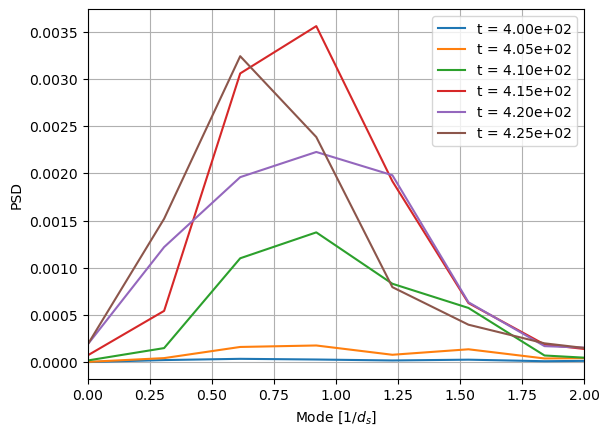

In [518]:
from scipy import signal

fs = ds#COMP / np.sqrt(weight_fac)  # Calculate sampling frequency

fig, ax = plt.subplots()

def x_low(frame):
    return int(400 * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) + 12000)
def x_high(frame):
    return int(400 * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) + 13000)

def PSD(frame):
    data = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0, 1))[x_low(frame):x_high(frame)]
    data = data / (ppc0 * weight_fac)
    f, Pxx = signal.welch(data, fs)
    return f, Pxx

for frame in tqdm(range(400, 430, 5)):    
    f, Pxx = PSD(frame)
    ax.plot(f, Pxx, label = r"t = {:.2e}".format(frame ))#* interval * omegap0

# data = np.average(fetch_var_at_step(out_dir, "flds", 15)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(15 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 20)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(20 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 25)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(25 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(30 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 35)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(35 * interval))

ax.set_xlabel(r'Mode [$1/d_s$]')
ax.set_xlim(0, 2)
ax.set_ylabel('PSD')
# ax.set_yscale('log')
ax.grid()
ax.legend()
plt.show()

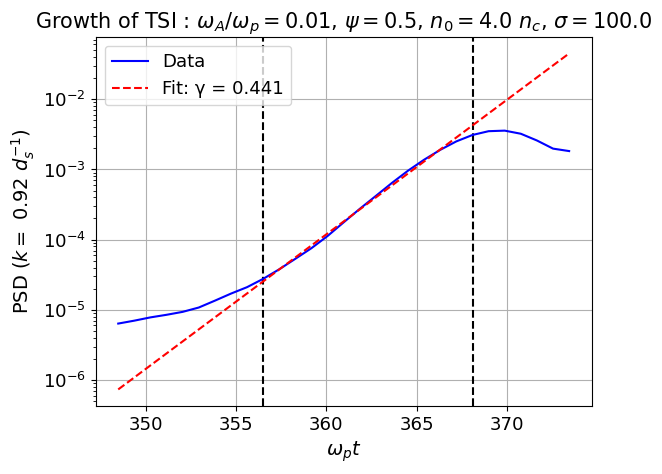

In [521]:
fs = ds #COMP/ np.sqrt(weight_fac)

# data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = PSD(frame = 415) #signal.welch(data, fs)

# To find the dominant peak (highest amplitude)
dominant_peak_idx = np.argmax(Pxx) 

# PSD_peak_val = []
# time_stamps = []
# for i in tqdm(range(380, 420)):
#     # data = np.average(fetch_var_at_step(out_dir, "flds", i)["dens1"][:,:,:], axis = 0)[0]
#     f, Pxx = PSD(i)#signal.welch(data, fs)
#     PSD_peak_val.append(Pxx[dominant_peak_idx])
#     time_stamps.append(i * interval * omegap0)


# time_stamps = np.array(time_stamps)
# PSD_peak_val = np.array(PSD_peak_val)

# # print(PSD_peak_val)

# # Take log of PSD values for linear fit
# log_PSD = np.log(PSD_peak_val)

# Fit a line to the log data
coeffs = np.polyfit(time_stamps[20:33], log_PSD[20:33], 1)

growth_rate = coeffs[0]  # This is your growth rate

# Generate fitted curve
fit_curve = np.exp(coeffs[1]) * np.exp(growth_rate * time_stamps)

# Your existing plotting code with added fit line
fig, ax = plt.subplots()
ax.axvline(x = time_stamps[20], c = "black", linestyle = "--")
ax.axvline(x = time_stamps[33], c = "black", linestyle = "--")
ax.plot(time_stamps[11:], PSD_peak_val[11:], 'b-', label='Data')
ax.plot(time_stamps[11:], fit_curve[11:], 'r--', label=f'Fit: γ = {growth_rate:.3f}')
ax.grid()
ax.set_xlabel(r"$\omega_{p} t$", fontsize = 14)
ax.set_ylabel(r"PSD ($k =$ {:.2f}".format(f[dominant_peak_idx]) + r" $d_s^{-1}$)", fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize = 13)
ax.set_title(r"Growth of TSI : $\omega_A / \omega_p = {0}$, $\psi = {1}$, $n_0 = {2}$ $n_c$, $\sigma = {3}$".format(wA_wp, psi, mult1, SIGMA),
            fontsize = 15)
# Optional: set y-axis to log scale to better see exponential behavior
ax.set_yscale('log')
plt.savefig(r"Growth of TSI : wA_wp = {0}$, psi = {1}, n_0 = {2}n_c, sigma = {3}.png".format(wA_wp, psi, mult1, SIGMA),dpi = 400)
plt.show()

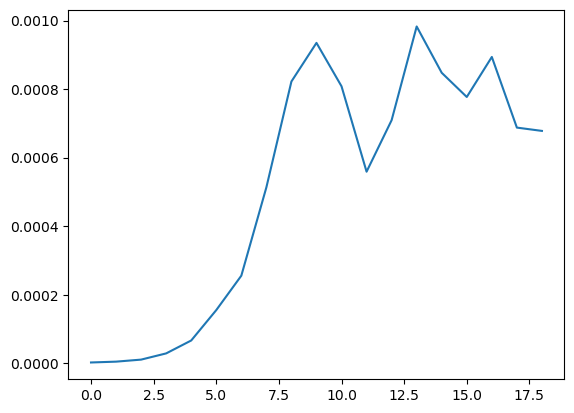

In [257]:
plt.plot(PSD_peak_val)

Text(0, 0.5, 'Max growth rate (${\\omega_p}^{-1}$)')

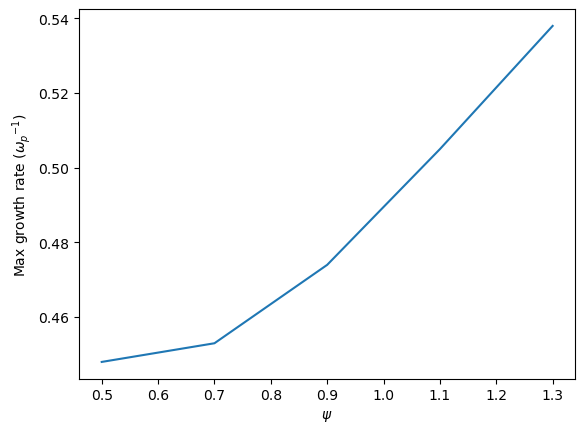

In [4]:
angles = [0.5, 0.7, 0.9, 1.1, 1.3]
grs_angles = [0.448, 0.453, 0.474, 0.505, 0.538]
plt.plot(angles, grs_angles)
plt.xlabel(r"$\psi$")
plt.ylabel(r"Max growth rate (${\omega_p}^{-1}$)")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]


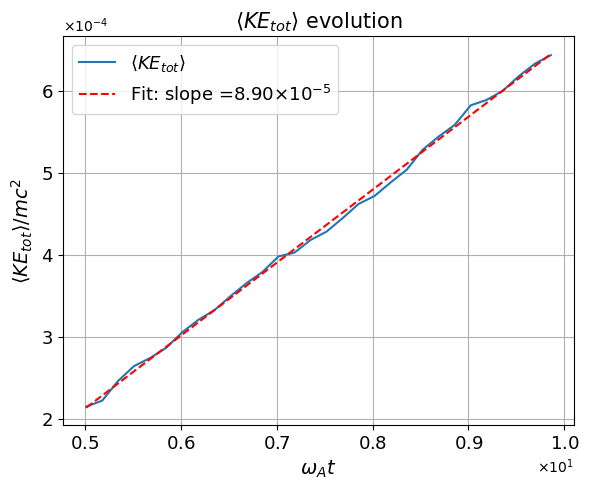

In [40]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
# from numba import jit 
# weight = 1.944037
# Precompute constants to avoid repeated calculations
# m1_CC2 = weight * m1 * CC**2
# m2_CC2 = weight * m2 * CC**2

w_m1 = weight_fac * m1
w_m2 = weight_fac * m2

def x_low(frame):
    return 0#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) - 500)  #+ 7000)
def x_high(frame):
    return grid_x#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) +17000) #+ 8700)

def calc_KE(frame):
    
    x_loc = (x_low(frame) + x_high(frame))//2
    delta_x = x_high(frame) - x_low(frame)
    
    # Fetch data for species 1 and species 2
    data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
    data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

    x1, x2 = data_1["x"], data_2["x"]
    mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
    mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)
    
    ux_1, uy_1 = data_1['u'][mask1], data_1['v'][mask1]
    ux_2, uy_2 = data_2['u'][mask2], data_2['v'][mask2]
    
    # # Calculate mod_u directly without creating intermediate arrays
    # mod_u_1 = np.sqrt(ux_1**2 + uy_1**2)
    # mod_u_2 = np.sqrt(ux_2**2 + uy_2**2)

    # # Calculate gamma and kinetic energy directly
    # gamma_1 = 1 / np.abs(np.cos(np.arctan(mod_u_1)))
    # gamma_2 = 1 / np.abs(np.cos(np.arctan(mod_u_2)))
    gamma_1 = np.sqrt(1 + ux_1**2 + uy_1**2)
    gamma_2 = np.sqrt(1 + ux_2**2 + uy_2**2)

    # plt.hist(gamma_1)

    # Calculate KE directly without creating intermediate arrays
    KE_1 = np.average((gamma_1 - 1)) *  w_m1 #* stride / ppc0/ (grid_y * (x_high(frame) - x_low(frame)))#/ux_1.shape[0]
    KE_2 = np.average((gamma_2 - 1)) *  w_m2 #* stride /ppc0/ (grid_y * (x_high(frame) - x_low(frame)))#/ux_2.shape[0]

    # bulk_gamma_1 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_1)**2 + np.average(uy_1)**2))))
    # bulk_gamma_2 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_2)**2 + np.average(uy_2)**2))))

    # bulk_gamma_1 = np.sqrt(1 + np.average(ux_1)**2 + np.average(uy_1)**2)
    # bulk_gamma_2 = np.sqrt(1 + np.average(ux_2)**2 + np.average(uy_2)**2)

    # bulk_KE_1 =  np.sum((bulk_gamma_1 - 1) * m1_CC2)# * ux_1.shape[0]
    # bulk_KE_2 =  np.sum((bulk_gamma_2 - 1) * m2_CC2)# * ux_2.shape[0]

    return (KE_1, KE_2)#, bulk_KE_1, bulk_KE_2)


# calc_KE(400)
# Optimize the computation over multiple frames
frames = np.arange(start = 300, stop = 600, step = 10)



KEs = np.array(Parallel(n_jobs=10)(delayed(calc_KE)(frame) for frame in tqdm(frames)))#np.array([calc_KE(frame) for frame in tqdm(frames)])
# KEs = KEs * stride #/ppc0/(grid_x * grid_y)
# KEs = KEs * CC**2
# Plot the result
t_steps = frames * interval * omegap0 * wA_wp
KE_tot = KEs[:,0] + KEs[:,1]

coeffs = np.polyfit(t_steps, KE_tot, 1)
fit_curve = coeffs[1] + t_steps * coeffs[0]


# plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
# plt.plot(frames * interval * omegap0, KEs[:,2] + KEs[:,3], label = "Bulk KE")
# plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1] - (KEs[:,2] + KEs[:,3]), label = "Thermal KE")

fig, ax = plt.subplots(figsize = (6, 5))
ax.set_xlabel(r"$\omega_{A}t$", fontsize = 14)
ax.plot(t_steps, KE_tot, label = r"$\langle KE_{tot} \rangle$")
ax.plot(t_steps, fit_curve, 'r--', label=r'Fit: slope ='+ sci_notation(coeffs[0], sig_fig = 2))
ax.set_ylabel(r"$\langle KE_{tot} \rangle/mc^2$", fontsize=14)
ax.set_title(r"$\langle KE_{tot} \rangle$ evolution", fontsize = 15)
ax.grid()
ax.legend(fontsize = 13)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()


# Generate fitted curve

# gain_rate1, _ = np.polyfit(t_steps[1:7], KE_tot[1:7], 1)
# print("Gain rate = {}".format(gain_rate1))
# gain_rate2, _ = np.polyfit(t_steps[-20:], KE_tot[-20:], 1)
# print("Gain rate = {}".format(gain_rate2))
# print("Gain rate_rat = {}".format(gain_rate1/gain_rate2))


In [371]:
print(stride)

100.0


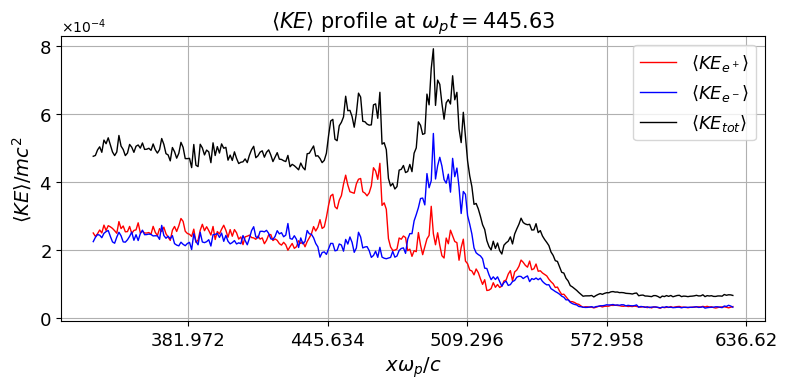

5.928407548981704e-07


In [526]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# No need for Parallel/joblib since we're only processing a single frame

def x_low(frame):
    return int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) - 4000)  #+ 7000)
def x_high(frame):
    return int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) +19000) #+ 8700)

w_m1 = weight_fac * m1
w_m2 = weight_fac * m2

def calc_KE_profile(frame, num_bins=200):
    # Get spatial range for this frame
    x_min = x_low(frame)
    x_max = x_high(frame)
    
    
    # Create spatial bins
    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    
    # Fetch data for both species
    data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
    data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]
    
    # Extract positions and velocities
    x1, x2 = data_1["x"], data_2["x"]
    ux_1, uy_1 = data_1['u'], data_1['v']
    ux_2, uy_2 = data_2['u'], data_2['v']
    
    # Calculate gamma factors for each particle
    gamma_1 = np.sqrt(1 + ux_1**2 + uy_1**2)
    gamma_2 = np.sqrt(1 + ux_2**2 + uy_2**2)
    
    # Create arrays to store KE for each bin
    KE1_profile = np.zeros(num_bins)
    KE2_profile = np.zeros(num_bins)
    
    # Bin particles by position and calculate KE in each bin
    for i in range(num_bins):
        bin_mask1 = (x1 >= x_bins[i]) & (x1 < x_bins[i+1])
        bin_mask2 = (x2 >= x_bins[i]) & (x2 < x_bins[i+1])
        
        # Sum KE for particles in this bin
        if np.any(bin_mask1):
            KE1_profile[i] = np.average((gamma_1[bin_mask1] - 1) * w_m1)
        if np.any(bin_mask2):
            KE2_profile[i] = np.average((gamma_2[bin_mask2] - 1) * w_m2)
    
    # Apply scaling factors
    KE1_profile = KE1_profile #* stride #* CC**2
    KE2_profile = KE2_profile #* stride #* CC**2
    
    return bin_centers, KE1_profile, KE2_profile

# Choose a single frame to analyze
single_frame = 500  # Change this to the frame you want to analyze

# Calculate KE profile
x_positions, KE1, KE2 = calc_KE_profile(single_frame, num_bins=300)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_positions, KE1, c = 'red', linewidth = 1, label=r"$\langle KE_{e^+} \rangle$")
ax.plot(x_positions, KE2, c = 'blue', linewidth = 1, label=r"$\langle KE_{e^-} \rangle$")
ax.plot(x_positions, KE1 + KE2, c = 'black', linewidth = 1,  label=r"$\langle KE_{tot} \rangle$")
ax.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_ylabel(r"$\langle KE \rangle/mc^2$", fontsize=14)
ax.set_title(r"$\langle KE \rangle$ profile at $\omega_p t =$"+ f"{single_frame * interval * omegap0:.2f}", fontsize = 15)
ax.grid()
ax.legend(fontsize = 13)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

tot_KE = KE1 + KE2

# density =  weight_fac * ppc0 #np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0,1))[x_low(single_frame):x_high(single_frame)] + np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0,1))[x_low(single_frame):x_high(single_frame)]

heating_rate = (np.average(tot_KE[0:10]) - tot_KE[-1]) * CC * np.cos(psi) * omegap0 
print(heating_rate)

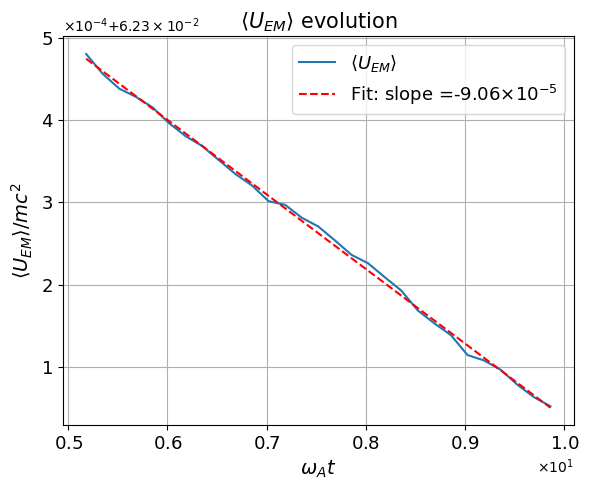

In [60]:
# x_loc = grid_x//2
# delta_x = grid_x
frames = np.arange(start = 300, stop = 600, step = 10)

def x_low(frame):
    return 0#int(frame * CC * 1  * interval * np.cos(psi) - 500)  #+ 7000)
def x_high(frame):
    return grid_x#int(frame * CC * 1  * interval * np.cos(psi) +17000) #+ 8700)
    
def calc_FE(frame):
    x_loc = (x_low(frame) + x_high(frame))//2
    delta_x = x_high(frame) - x_low(frame)
    
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    E_field_energy =    np.sum(data_1["ex"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2 + 
                             data_1["ey"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2  + 
                             data_1["ez"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2) *(CC**(-2) * COMP)**2 / (grid_y * (x_high(frame) - x_low(frame)))
    # print(E_field_energy)
    
    Bw_field_energy =  np.sum(#data_1["bx"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2 +
                              #data_1["by"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2 + 
                              data_1["bz"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2)*(CC**(-2) * COMP)**2 / (grid_y * (x_high(frame) - x_low(frame)))
    
    return (E_field_energy , Bw_field_energy)

# FEs = np.array(Parallel(n_jobs=10)(delayed(calc_FE)(frame) for frame in tqdm(frames)))#np.array([calc_FE(frame) for frame in tqdm(frames)])#/(grid_x * grid_y)

# plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
# plt.plot(frames[1:] * interval * omegap0, FEs[1:,0] +  FEs[1:,1] , label = "EM avg. energy density")
# # plt.plot(frames * interval * omegap0, (KEs[:,0] + KEs[:,1]) + (FEs[:,0] + FEs[:,1])* B_norm**2 - 0.029 , label = "Total energy - C")
# # plt.plot(frames * interval * omegap0, FEs[:,0] , label = "E field energy")
# # plt.plot(frames * interval * omegap0, FEs[:,1] , label = r"$B_w$ field energy")
# plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
# plt.ylabel(r"$\langle U_EM \rangle$", fontsize = 13)
# plt.legend()
# plt.grid()
# plt.show()

tot_E = (FEs[1:,0] +  FEs[1:,1]) #* grid_x * grid_y 
t_steps = frames[1:] * interval * omegap0 * wA_wp
coeffs = np.polyfit(t_steps, tot_E, 1)
fit_curve = coeffs[1] + t_steps * coeffs[0]

fig, ax = plt.subplots(figsize = (6, 5))
ax.set_xlabel(r"$\omega_{A}t$", fontsize = 14)
ax.plot(t_steps, tot_E, label = r"$\langle  U_{EM} \rangle$")
ax.plot(t_steps, fit_curve, 'r--', label=r'Fit: slope ='+ sci_notation(coeffs[0], sig_fig = 2))
ax.set_ylabel(r"$\langle  U_{EM} \rangle/mc^2$", fontsize=14)
ax.set_title(r"$\langle  U_{EM} \rangle$ evolution", fontsize = 15)
ax.grid()
ax.legend(fontsize = 13)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax.ticklabel_format(axis='y', useOffset=0.0623)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

# loss_rate1, _ = np.polyfit(t_steps[:10], tot_E[:10], 1)
# print("Loss rate1 = {}".format(loss_rate1))
# loss_rate, _ = np.polyfit(t_steps[-20:], tot_E[-20:], 1)
# print("Loss rate2 = {}".format(loss_rate))
# print("Loss rate_rat = {}".format(loss_rate1/loss_rate2))

In [375]:
print(B_norm)

0.18848531023509577


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [02:28<00:00,  2.18s/it]


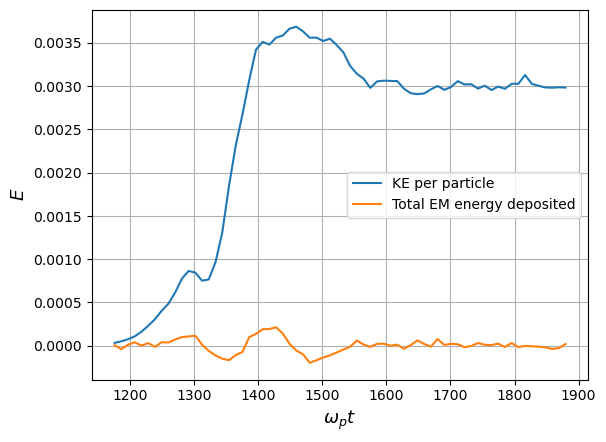

In [183]:
x_loc = 6000
delta_x = 25
frames = np.arange(start = 560, stop = 900, step = 5)

def calc_E_in_out(frame):
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    # ex = data_1["ex"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    ey = data_1["ey"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    ez = data_1["ez"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    
    # bx = data_1["bx"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    by = data_1["by"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    bz = data_1["bz"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]

    # Cross product to get the Poynting vector components
    Sx = (ey * bz - ez * by)
    # Sy = (ez * bx - ex * bz)
    # Sz = (ex * by - ey * bx)

    #Incoming:
    incoming = np.sum(Sx[:, :, 0])
    outgoing = np.sum(Sx[:, :, -1])
    
    return (incoming , outgoing)
    

E_io_s = np.array([calc_E_in_out(frame) for frame in tqdm(frames)])
plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE per particle")
plt.plot(frames * interval * omegap0, E_io_s[:,0] - E_io_s[:,1] , label = "Total EM energy deposited")
# plt.plot(frames * interval * omegap0, FEs[:,0] , label = "E field energy")
# plt.plot(frames * interval * omegap0, FEs[:,1] , label = r"$B_w$ field energy")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$E$", fontsize = 13)
plt.legend()
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:23<00:00,  2.92it/s]


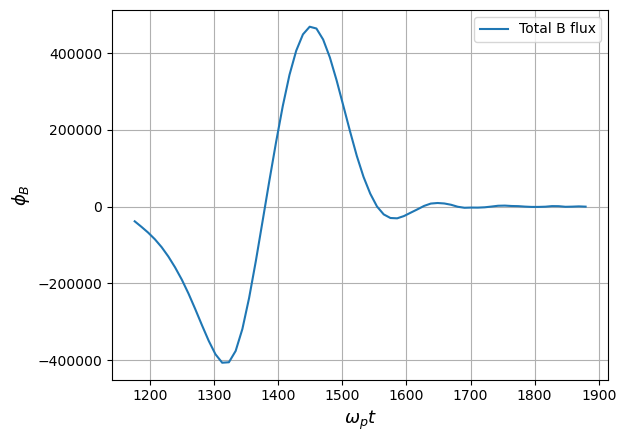

In [180]:
#div B check

x_loc = 6000
delta_x = 25
frames = np.arange(start = 560, stop = 900, step = 5)

def calc_Bflux(frame):
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    flux_x = 0*np.sum(data_1["bx"][:,:,x_loc + delta_x//2] * grid_y * 1 - data_1["bx"][:,:,x_loc - delta_x//2] * grid_y * 1)
    flux_y = 0*np.sum(data_1["by"][:, -1 ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * 1 
                   - data_1["by"][:, 0 ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * 1 )
    flux_z = np.sum(data_1["bz"][-1, : ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * grid_y 
                    - 0 * data_1["bz"][0, : ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * grid_y )
      
    return (flux_x + flux_y + flux_z)

Fluxs = np.array([calc_Bflux(frame) for frame in tqdm(frames)])

plt.plot(frames * interval * omegap0, Fluxs[:] , label = "Total B flux")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$\phi_{B}$", fontsize = 13)
plt.legend()
plt.grid()
plt.show()

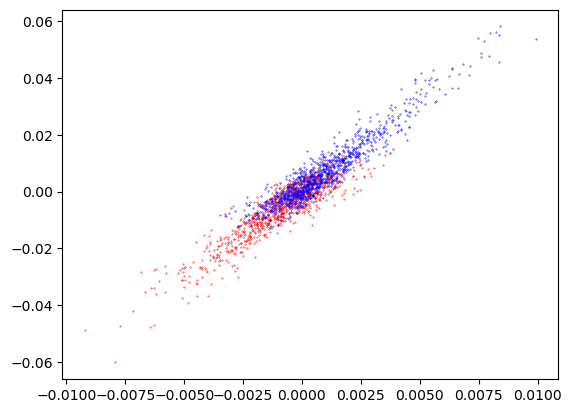

In [108]:
x_loc = 3000
delta_x = 10
frame = 190


data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

x1, x2 = data_1["x"], data_2["x"]
mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)
    
ux_1, uy_1 = data_1['u'][mask1], data_1['v'][mask1]
ux_2, uy_2 = data_2['u'][mask2], data_2['v'][mask2]

plt.figure()
plt.scatter(ux_1, uy_1, s=0.1, c = 'r')
# plt.figure()
plt.scatter(ux_2, uy_2, s=0.1, c = 'b')

In [319]:
t_series = [np.average(fetch_var_at_step(out_dir, "flds", frame)['ex'][0,:,4000]) for frame in tqdm(range(20, 100))]



100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [01:53<00:00,  1.42s/it]


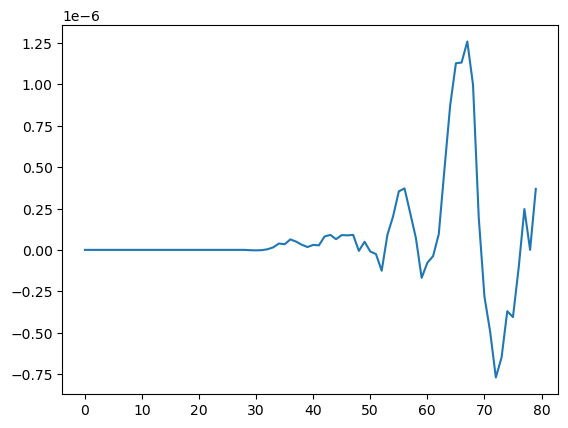

In [320]:
plt.plot(t_series)